# Data Cleaning

_Author: Nathan Robertson_

Now that I have the webscraped data, I need to clean this up and make it ready for analysis and model creation.

# Step 0: Import the packages.

Let's import the packages I need to begin.

In [1]:
# For wrangling data.
import pandas as pd
import numpy as np
import json

# For pulling datatypes out of strings.
import ast

# For regexing out values.
import re

# Make it easier to view dataframes (mine has a lot of columns!)
pd.set_option('display.max_columns', None)

# Data visualization.
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'monospace'

# For progress tracking.
from tqdm import tqdm

# Step 1: Import and Assess the Data

Reading in the data, it looks like it is _mostly_ in fair shape. But there are some issues that can be seen at a quick glance:



<div class="alert alert-block alert-info">
<li>Some columns have a high level of null values. There is a chance these could be imputed or estimated.</li>
<li>Some columns have ranges that are suspicious (supposedly there is a house with 22 fireplaces...not impossible, but seems unlikely!)</li>
</div>

I'll need to go column by column and assess the listings.

In [2]:
# Read in dataframe from backup file.
df = pd.read_csv('BACKUP zillow_listing_data.csv')

<ipython-input-2-1c68cbc98853>:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/backup/BACKUP zillow_listing_data.csv')


In [3]:
# Take a peek at the data.
df.head()

,zillowId,homeStatus,streetAdress,city,state,zipcode,price,bedrooms,bathrooms,yearBuilt,zestimate,homeType,pricePerSquareFoot,livingArea,basementYN,hasGarage,parkingCapacity,listingTerms,schools,sewer,patioAndPorchFeatures,hasHeating,fireplaces,hasWaterfrontView,isSeniorCommunity,levels,lotSize,hoaFee,buyersFeePerc,daysOnZillow,views,favorites,latitude,longitude,mainPhoto,brokerage,percSellFaster,propertyTax,mortgageRate,listingUserId,agentName,agentRating,agentRecentSales,agentReviewsCount,photosList,isForeclosure,isFSBO,isBankOwned,isZillowOwned,rentZestimate,totalActualRent,annual_house_insurance,price_history,description,hasPrivatePool,attic,similarHomes
0,2091638544,FOR_SALE,0 Wavecrest Avenue NE,Poulsbo,WA,98370,35500,NaN,NaN,NaN,NaN,VacantLand,NaN,NaN,False,False,0.0,"Cash Out,Owner Will Carry,See Remarks","[{""distance"": 2.5, ""name"": ""Kingston Middle Sc...","[""Not Available""]",NaN,NaN,NaN,NaN,NaN,NaN,0.33 Acres,$28 monthly,NaN,267.0,468.0,24.0,47.762417,-122.545630,https://photos.zillowstatic.com/fp/7ea447eb095...,"John L. Scott, Inc.",0.23,0.78,5.991,X1-ZUtne0nxxhbrih_2xcn4,Matt LaMagna,0.0,0.0,0.0,"[""https://photos.zillowstatic.com/fp/7ea447eb0...",False,False,False,False,1708.0,NaN,149.1,"[[""2023-11-10"", 35500], [""2023-10-02"", 39000],...",Use our house plans or build your own custom h...,NaN,NaN,"[2056447004, 2068262125, 226729280, 2056334568..."
1,23390459,FOR_SALE,8636 Southridge Place,Anacortes,WA,98221,349000,NaN,NaN,NaN,NaN,VacantLand,NaN,NaN,False,False,0.0,"Cash Out,Conventional","[{""distance"": 1.2, ""name"": ""Fidalgo Elementary...","[""On Property""]",NaN,NaN,NaN,NaN,NaN,NaN,1.81 Acres,$600 annually,NaN,156.0,311.0,20.0,48.448980,-122.557820,https://photos.zillowstatic.com/fp/a0d56cae812...,Windermere Bellevue Commons,0.00,0.83,6.308,X1-ZUy79m3wd7x2bt_a3ta0,Soli Snyder,5.0,1.0,259.0,"[""https://photos.zillowstatic.com/fp/a0d56cae8...",False,False,False,False,2064.0,NaN,1465.8,"[[""2023-07-19"", 349000], [""2021-07-16"", 310000]]","Beautiful 1.8 acre Fidalgo Island, Anacortes p...",NaN,NaN,"[306013245, 2069501860, 2055962600, 203945085,..."
2,23352313,FOR_SALE,7001 Palm Lane,Anacortes,WA,98221,2498000,4.0,3.0,2000.0,NaN,SingleFamily,659.0,"3,788 sqft",False,True,4.0,"Cash Out,Conventional","[{""distance"": 0.5, ""name"": ""Fidalgo Elementary...","[""Septic Tank"", ""Company: Septic System""]",NaN,True,2.0,NaN,NaN,One,10.30 Acres,NaN,2.5,125.0,1219.0,40.0,48.441994,-122.591225,https://photos.zillowstatic.com/fp/8a6b6abe798...,COMPASS,0.25,0.83,6.606,X1-ZUyt9ezy9pvtop_61q4w,Eileen Hebert,5.0,1.0,259.0,"[""https://photos.zillowstatic.com/fp/8a6b6abe7...",False,False,False,False,NaN,NaN,10491.6,"[[""2023-10-11"", 2498000], [""1994-06-27"", 308000]]",Exquisite Equestrian Oasis. The perfect blend ...,NaN,NaN,"[84763318, 23352179, 23377656, 23387845, 20536..."
3,23380009,FOR_SALE,14820 Gibralter Road,Anacortes,WA,98221,5300000,5.0,6.0,2001.0,NaN,SingleFamily,950.0,"5,577 sqft",False,True,4.0,"Cash Out,Conventional","[{""distance"": 1.2, ""name"": ""Fidalgo Elementary...","[""Septic Tank"", ""Company: Septic - On Site""]",NaN,True,4.0,NaN,NaN,One,17.01 Acres,NaN,2.5,276.0,2146.0,127.0,48.429980,-122.587870,https://photos.zillowstatic.com/fp/3a101f623ea...,"Windermere R.E. Northeast, Inc",0.22,0.83,6.606,X1-ZUz3sd58bhvnd5_3qul1,bryanloveless5250,5.0,0.0,9.0,"[""https://photos.zillowstatic.com/fp/3a101f623...",False,False,False,False,NaN,NaN,22260.0,"[[""2023-03-21"", 5300000], [""2015-11-30"", 21500...",Saratoga Stables–a magnificent gated 17+ acre ...,NaN,NaN,"[2055432779, 2053658449, 228491857, 82573373, ..."
4,23352179,FOR_SALE,7270 Old Brook Lane,Anacortes,WA,98221,1499000,5.0,4.0,1983.0,1391500.0,SingleFamily,505.0,"2,968 sqft",False,True,2.0,"Cash Out,Conventional","[{""distance"": 1, ""name"": ""Fidalgo Elementary S...","[""Septic Tank"", ""Company: City of Anacortes""]",NaN,True,2.0,NaN,NaN,Two,9.01 Acres,NaN,2.5,94.0,936.0,29.0,48.460000,-122.587746,https://photos.zillowstatic.com/fp/99488e836da

In [4]:
# Get some quick summary statistics for the values.
df.describe()

,zillowId,price,bedrooms,bathrooms,yearBuilt,zestimate,pricePerSquareFoot,parkingCapacity,fireplaces,daysOnZillow,views,favorites,latitude,longitude,percSellFaster,propertyTax,mortgageRate,agentRating,agentRecentSales,agentReviewsCount,rentZestimate,totalActualRent,annual_house_insurance,hasPrivatePool,attic
count,2.653080e+05,2.653080e+05,184603.000000,201416.000000,1.764860e+05,1.268580e+05,1.714210e+05,265308.000000,78357.000000,262209.000000,265220.000000,265220.000000,264716.000000,264716.000000,234774.000000,261037.000000,225835.000000,228253.000000,227995.000000,228253.000000,194931.000000,1.412800e+04,2.318910e+05,0.0,0.0
mean,1.055101e+09,6.008873e+05,3.284107,2.409357,2.078922e+03,6.337066e+05,5.530429e+02,1.434389,0.810381,134.418536,512.163773,24.714282,36.633515,-95.020250,0.494272,1.006158,6.281934,4.174618,0.706195,74.151069,2883.452037,2.074891e+03,2.480674e+03,NaN,NaN
std,9.804711e+08,2.453333e+06,4.793433,9.150604,4.594174e+04,1.354973e+06,2.425706e+04,16.713920,0.854287,198.790241,875.893430,47.370543,5.653321,15.564612,0.297469,0.476772,0.249895,1.821233,9.008863,193.031127,5869.655214,8.495422e+04,1.092932e+04,NaN,NaN
min,6.586100e+04,0.000000e+00,0.000000,0.000000,0.000000e+00,1.120000e+04,0.000000e+00,-16.000000,0.000000,-28.000000,0.000000,0.000000,24.690960,-124.478160,0.000000,0.000000,5.902000,0.000000,0.000000,0.000000,52.000000,0.000000e+00,4.200000e-03,NaN,NaN
25%,7.445818e+07,1.499000e+05,3.000000,2.000000,1.971000e+03,2.732000e+05,1.610000e+02,0.000000,0.000000,35.000000,54.000000,2.000000,32.674084,-107.981346,0.240000,0.640000,5.991000,4.900000,0.000000,3.000000,1474.500000,0.000000e+00,5.250000e+02,NaN,NaN
50%,3.361598e+08,3.400000e+05,3.000000,2.000000,2.001000e+03,4.092000e+05,2.180000e+02,1.000000,1.000000,74.000000,221.000000,9.000000,36.156265,-90.966390,0.470000,0.910000,6.301000,5.000000,0.000000,19.000000,2048.000000,0.000000e+00,1.297800e+03,NaN,NaN
75%,2.057078e+09,5.950000e+05,4.000000,3.000000,2.023000e+03,6.386000e+05,3.230000e+02,2.000000,1.000000,155.000000,643.000000,29.000000,40.794960,-82.350066,0.770000,1.230000,6.523000,5.000000,1.000000,69.000000,2920.000000,0.000000e+00,2.394000e+03,NaN,NaN
max,2.146983e+09,9.417250e+08,1536.000000,3600.000000,1.930200e+07,1.869439e+08,7.199996e+06,4848.000000,22.000000,6480.000000,64320.000000,3200.000000,49.392990,-67.070854,0.990000,3.890000,7.057000,5.000000,429.000000,5322.000000,739019.000000,1.000094e+07,3.955245e+06,NaN,NaN


In [5]:
# Check nullness and data types.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265308 entries, 0 to 265307
Data columns (total 57 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   zillowId                265308 non-null  int64  
 1   homeStatus              265308 non-null  object 
 2   streetAdress            265306 non-null  object 
 3   city                    265308 non-null  object 
 4   state                   265308 non-null  object 
 5   zipcode                 265295 non-null  object 
 6   price                   265308 non-null  int64  
 7   bedrooms                184603 non-null  float64
 8   bathrooms               201416 non-null  float64
 9   yearBuilt               176486 non-null  float64
 10  zestimate               126858 non-null  float64
 11  homeType                265308 non-null  object 
 12  pricePerSquareFoot      171421 non-null  float64
 13  livingArea              175431 non-null  object 
 14  basementYN          

# Step 2: Clean data, column by column

Looking at each column one at a time, I am going to figure out what needs to be done to clean and transform the data in preparation for model creation. Let's get to work.

#### Helper functions

I'll put together a few helper functions that will speed up my work.

In [6]:
"""
groupit

A function that prints a sorted grouped DataFrame to see the most common values in 
a DataFrame for a given column.

    Args:
        x: the column being assessed.
        df: the DataFrame being used.
        
    Returns:
        Prints the number of times each value in the DataFrame occurs, sorted in 
        descending order.
"""

def groupit(x, df=df):
    print(df[[x]].groupby(x).size().sort_values(ascending=False))


"""
nullcheck

A function that quickly assesses the nulls for a specific column.

    Args:
        x: the column being assessed.
        df: the DataFrame being used.
        
    Returns:
        Prints the number of null values for that column in
        the DataFrame.
"""

def nullcheck(x, df=df):
    null_values = len(df[df[x].isnull()])
    print(x)
    print('Nulls:', null_values)
    
    
"""
histogram

Create a histogram of a certain dataset. Flexible to accomodate a number of different
underlying data types while providing consistent styling.

    Args:
        column: Variable to put in histogram.
        title: Title of chart.
        xlabel: X label title.
        ylabel: Y label title.
        log: Whether or not Y axis is log scale.
        df: The data that will be used.
        xtickformat: Transforms the xtick formatting based on the underlying data.
        bins: Determines the number of bins.
        
    Returns:
        Renders a matplotlib chart with specific styling requirements.
        This gets rid of a lot of duplicative matplotlib code later in
        the notebook.
"""

def histogram(column, title, xlabel, ylabel, log, df, xtickformat=None, bins=40):
    
    # Increase the image resolution.
    plt.figure(dpi=200)

    # Histogram on the variable.
    ax = df[column].hist(bins=bins, log=log, color='#003f5c')
    ax.set_facecolor('#EBEBF1')

    # Set accurate x and y tick labels based on the desired format.
    if xtickformat==None:
        plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
        plt.gca().set_xticklabels([round(float(x),1) for x in plt.gca().get_xticks()])
    elif xtickformat =='USD Millions':
        plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
        plt.gca().set_xticklabels([str(int(x/1000000)) + 'M' for x in plt.gca().get_xticks()])
    elif xtickformat == 'USD Thousands':
        plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
        plt.gca().set_xticklabels([str(int(x/1000)) + 'K' for x in plt.gca().get_xticks()])
    elif xtickformat == 'Percentage Conversion':
        plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
        plt.gca().set_xticklabels([round(float(x)*100,1) for x in plt.gca().get_xticks()])

    # Label plot.
    plt.title(title, fontweight='bold',loc='left')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

    # Show plot.
    plt.show()

### Zillow ID

<div class="alert alert-block alert-info"><b>Definition: </b> Zillow ID is the anonymous identifier for that home listing on zillow.com. </div> 

The web scraper was designed to minimize duplicate web scraping. But, it looks like there were still some listings that got scraped twice. I'll drop the duplicates, keeping the first record scraped.

In [7]:
# Quick groupby.
groupit('zillowId')

zillowId
2055634191    4
245562735     4
2130398046    4
101255472     4
2054367713    4
             ..
98500718      1
98500721      1
98500799      1
98500961      1
2146982595    1
Length: 264498, dtype: int64


In [8]:
# Drop duplicates on zillowID.
print('Prior to dropping duplicates of zillowId:', len(df))
df.drop_duplicates(subset='zillowId', keep='first', inplace=True)
print('Post dropping duplicates of zillowId:', len(df))

Prior to dropping duplicates of zillowId: 265308
Post dropping duplicates of zillowId: 264498


### Home Status

<div class="alert alert-block alert-info"><b>Definition: </b> Home Status is the part of the sales cycle the home is in. Is it for sale? for rent? Is it sold?</div> 

I picked an area of Zillow's website that was focused on currently for sale homes. The vast majority of the data I scraped fits that definition, with the value `FOR_SALE` being the most common label. There are a handful of different types that leaked through, but they represent <10 records in the entire dataset. I'll drop the minority classes.

In [9]:
# Quick groupby.
groupit('homeStatus')

homeStatus
FOR_SALE           264491
OTHER                   5
FOR_RENT                1
PRE_FORECLOSURE         1
dtype: int64


In [10]:
# Drop listings where homeStatus does not equal FOR_SALE.
print('Prior to dropping outlier classes of homeStatus:', len(df))
df = df[df['homeStatus'] == 'FOR_SALE']
print('After dropping outlier classes of homeStatus:', len(df))

Prior to dropping outlier classes of homeStatus: 264498
After dropping outlier classes of homeStatus: 264491


### Street Address

<div class="alert alert-block alert-info"><b>Definition: </b> Street Address is the address of where the home can be found in its given city / state.</div> 

Do nothing here! I don't have a way to vet this data's accuracy, nor do I expect it will be relied upon for the model.

### City

<div class="alert alert-block alert-info"><b>Definition: </b> City is the U.S City where the home can be found</div> 

Similar to `Street Address`. I might do some simple groupby analyses with this data, but I have no way of vetting its accuracy in a programmatic way (nor do I need to for the model I expect to design). 

### State: Removing Canada / Mexico Listings

<div class="alert alert-block alert-info"><b>Definition: </b> State is the U.S State where the home can be found</div> 

While I did my best to limit the webscraper to only US listings, it occasionally hit mapboxes with homes right over the border. Let's make sure all of the listings are in one of the 50 states of the United States.

In [11]:
us_state_codes = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 
    'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 
    'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 
    'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 
    'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'
]

In [12]:
# Quick groupby for states not in the `us_state_codes` list.
groupit('state',df=df[~df['state'].isin(us_state_codes)])

state
BC    2709
ON    1495
SK      43
DC       7
NB       7
AB       4
dtype: int64


In [13]:
# Drop listings where State is not in the list `us_state_codes`.
print('Prior to dropping non-US listings:', len(df))
df = df[df['state'].isin(us_state_codes)]
print('After dropping non-US listings:', len(df))

Prior to dropping non-US listings: 264491
After dropping non-US listings: 260226


### Zipcode

<div class="alert alert-block alert-info"><b>Definition: </b> Zipcode is the U.S Postal Code where the home can be found</div> 


I just need to trust the validity of this data and move on, as I lack the time to validate it. Additionally, I don't expect this feature to play a major role in the models I build. The only thing I'll do is drop the records where `zipcode` is null.

In [14]:
# Quick null check.
nullcheck('zipcode')

zipcode
Nulls: 13


In [15]:
# Drop records where zipcode is null.
print('Prior to dropping null zipcodes:', len(df))
df.dropna(subset=['zipcode'], inplace=True)
print('After to dropping null zipcodes:', len(df))

Prior to dropping null zipcodes: 260226
After to dropping null zipcodes: 260213


### Price

<div class="alert alert-block alert-info"><b>Definition: </b> Price is the cost in USD to purchase this listing from its current owner.</div> 


There is one listing that is for sale for 941 million dollars (!). it is a 1,883~ acre ranch investment opportunity in Arizona. Let's drop that one record. We'll also drop records with a price less than $1,000, as manual review suggests these are all errors or incomplete data. Otherwise, I will keep the rest.

<ipython-input-6-e8e7d24ab219>:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([str(int(x/1000000)) + 'M' for x in plt.gca().get_xticks()])


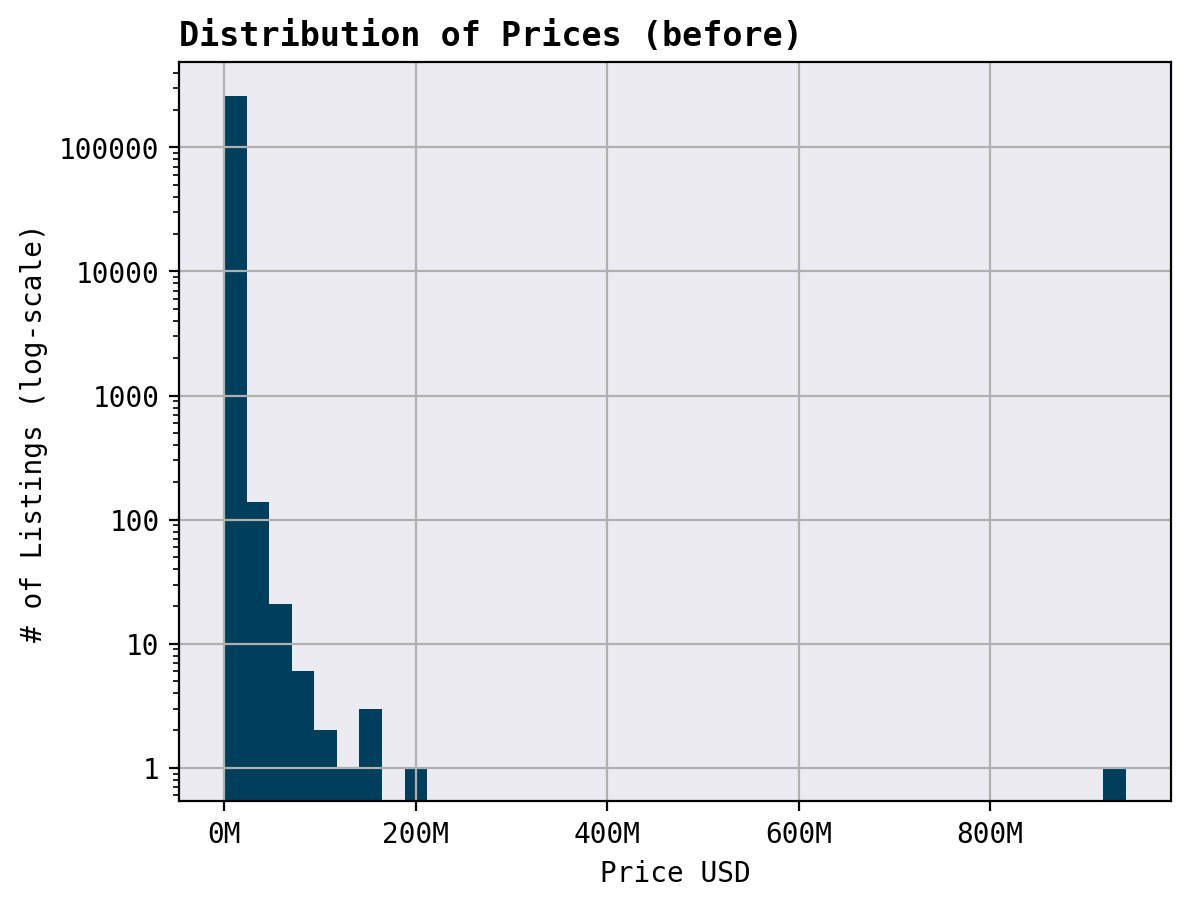

In [16]:
# Visualize data.
column='price'
title='Distribution of Prices (before)'
xlabel='Price USD'
ylabel='# of Listings (log-scale)'
log=True
xtickformat='USD Millions'


histogram(column, title, xlabel, ylabel, log, df, xtickformat)

In [17]:
# Get Max price.
df['price'].max()

941725000

In [18]:
# Look at the listing with the max price -- it is a VacantLand hometype of 1,883 acres. 
df[df['price']==(df['price'].max())]

,zillowId,homeStatus,streetAdress,city,state,zipcode,price,bedrooms,bathrooms,yearBuilt,zestimate,homeType,pricePerSquareFoot,livingArea,basementYN,hasGarage,parkingCapacity,listingTerms,schools,sewer,patioAndPorchFeatures,hasHeating,fireplaces,hasWaterfrontView,isSeniorCommunity,levels,lotSize,hoaFee,buyersFeePerc,daysOnZillow,views,favorites,latitude,longitude,mainPhoto,brokerage,percSellFaster,propertyTax,mortgageRate,listingUserId,agentName,agentRating,agentRecentSales,agentReviewsCount,photosList,isForeclosure,isFSBO,isBankOwned,isZillowOwned,rentZestimate,totalActualRent,annual_house_insurance,price_history,description,hasPrivatePool,attic,similarHomes
89377,2076153703,FOR_SALE,0 N Frontier Rd,Mc Neal,AZ,85617,941725000,0.0,0.0,0.0,NaN,VacantLand,NaN,NaN,False,False,0.0,NaN,"[{""distance"": 15.2, ""name"": ""Lowell School"", ""...",NaN,NaN,NaN,0.0,True,NaN,NaN,"1,883 Acres",NaN,NaN,4.0,474.0,3.0,31.61294,-109.75001,https://photos.zillowstatic.com/fp/429786052b1...,United Country Real Estate/Stockmen's Realty,0.78,0.69,6.553,X1-ZUyscfby7a7jm1_90hcs,Nancy Belt,4.9,1.0,299.0,"[""https://photos.zillowstatic.com/fp/429786052...",False,False,False,False,756.0,NaN,3955245.0,"[[""2023-12-21"", 941725000], [""2019-10-04"", 470...",Explore this ranching and investment opportuni...,NaN,NaN,NaN


In [19]:
# There are also a number of listings less than zero. Most of these upon review look like errors,
# or suspicious listings that might be false.
len(df[df['price']<=1000])

435

Prior to dropping outlier / null prices: 260213
After to dropping outlier / null prices: 259777


<ipython-input-6-e8e7d24ab219>:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([str(int(x/1000000)) + 'M' for x in plt.gca().get_xticks()])


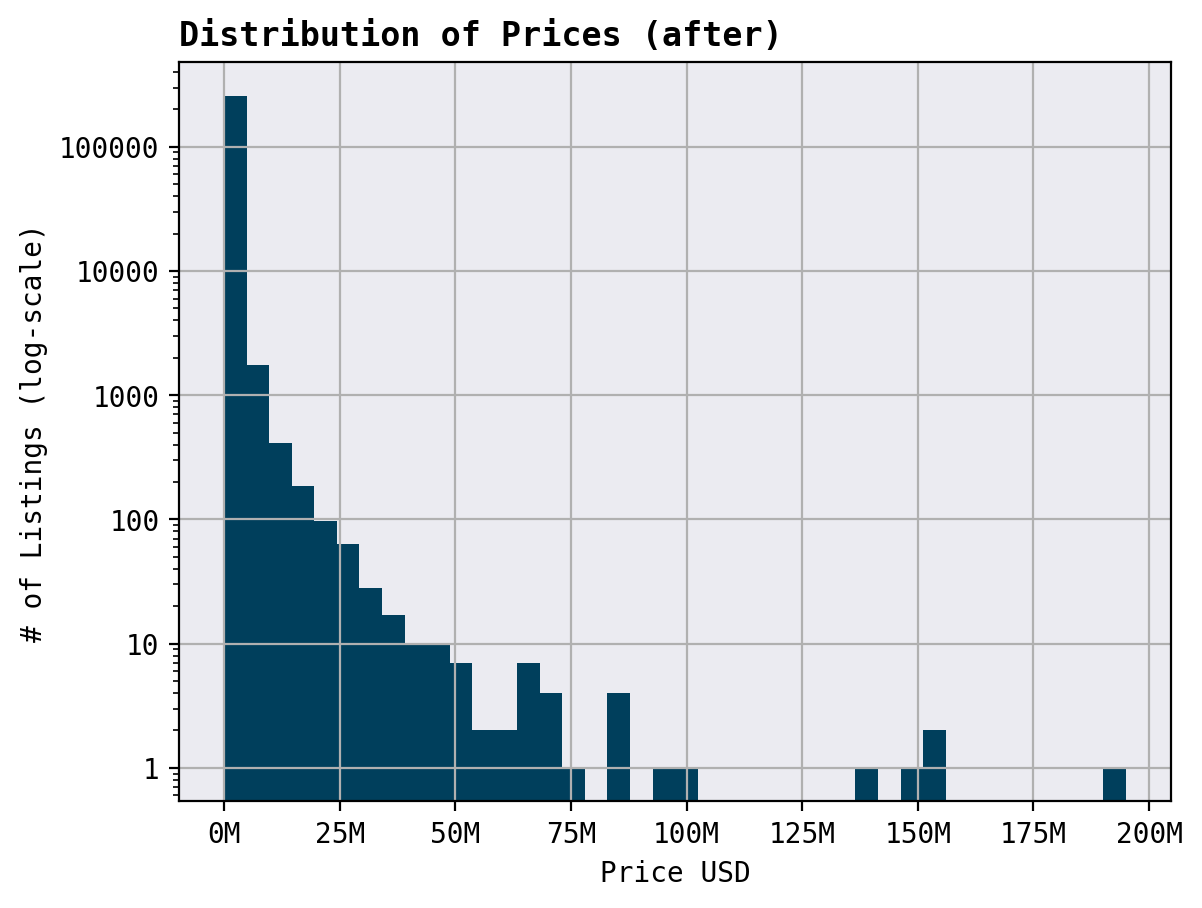

In [20]:
# Drop the outliers.
print('Prior to dropping outlier / null prices:', len(df))
df = df[df['price'] <= 900000000]
df = df[df['price'] > 1000]
print('After to dropping outlier / null prices:', len(df))

# Visualize data.
column='price'
title='Distribution of Prices (after)'
xlabel='Price USD'
ylabel='# of Listings (log-scale)'
log=True
xtickformat='USD Millions'

histogram(column, title, xlabel, ylabel, log, df, xtickformat)

### Bedrooms

<div class="alert alert-block alert-info"><b>Definition: </b> Bedrooms is the number of rooms that can be used for sleeping. In the US, this is typically defined as rooms with a window and closet, and that aren't being used for other purposes.</div> 

There are a high percentage of listings that have no bedrooms. The explanation: they are vacant land.

However, there is also a minority of listings where the either the web scraper failed, or the listing didn't provide information on the bedrooms. Upon review, most of these are listings that Zillow's website tags as missing too much data to provide an accurate zestimate.

Finally, there are a couple listings that accidentally put the square footage as the number of bedrooms (1,000+ bedrooms!) -- we'll go in and update those entries based on what their description on Zillow says.

In [21]:
# Quick groupby.
groupit('bedrooms')

bedrooms
3.0       73523
4.0       48955
2.0       28888
5.0       14635
1.0        6021
0.0        5440
6.0        3866
7.0        1056
8.0         634
9.0         259
10.0        145
12.0        117
11.0         76
16.0         47
13.0         40
14.0         32
15.0         22
18.0         19
20.0         18
17.0         14
24.0         13
22.0          8
19.0          6
32.0          5
21.0          5
25.0          5
30.0          4
23.0          4
46.0          3
44.0          3
48.0          3
36.0          3
42.0          3
27.0          3
28.0          3
35.0          2
37.0          2
40.0          2
71.0          1
1204.0        1
108.0         1
93.0          1
91.0          1
88.0          1
80.0          1
77.0          1
56.0          1
62.0          1
34.0          1
55.0          1
26.0          1
47.0          1
29.0          1
33.0          1
1536.0        1
dtype: int64


In [22]:
# Quick null check.
nullcheck('bedrooms')

bedrooms
Nulls: 80597


<ipython-input-6-e8e7d24ab219>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([round(float(x),1) for x in plt.gca().get_xticks()])


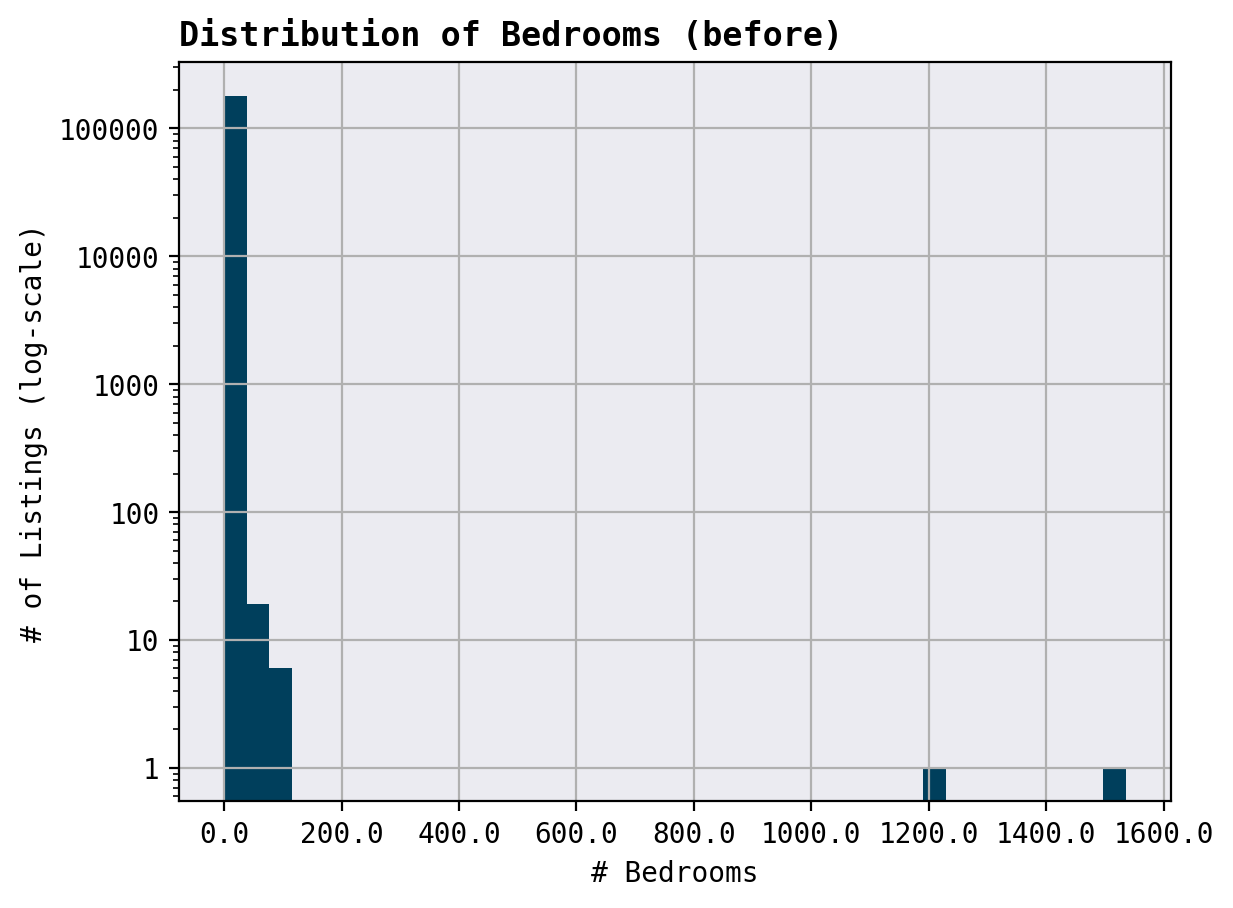

In [23]:
# Visualize data.
column='bedrooms'
title='Distribution of Bedrooms (before)'
xlabel='# Bedrooms'
ylabel='# of Listings (log-scale)'
log=True


histogram(column, title, xlabel, ylabel, log, df)

In [24]:
# Insight: The majority of records with a null value for bedrooms are VacantLand hometypes.
df[df['bedrooms'].isnull()][['homeType']].groupby('homeType').size().sort_values(ascending=False)

homeType
VacantLand            76926
MultiFamily            1600
SingleFamily           1152
Condo                   145
MobileManufactured       64
Cooperative              33
Townhouse                 7
Apartment                 1
dtype: int64

In [25]:
# Problem to solve: there are still a number of records where the number of bedrooms are unknown.
# After reviewing these records, a lot of these are listings with incomplete data warnings on Zillow's
# website. We'll drop these listings.
subsetColumns = ['zillowId','homeType','price','bedrooms','description']
df[(df['bedrooms'].isnull()) & (df['homeType'] != 'VacantLand')][subsetColumns]

,zillowId,homeType,price,bedrooms,description
661,2055025853,MultiFamily,2050000,NaN,"30 Gardiner Ave is situated on 5, 253 square f..."
677,2088019771,MultiFamily,1475000,NaN,Small and easy to manage property in an excell...
689,2096959538,MultiFamily,2800000,NaN,520 8th Ave is a well maintained three-story a...
735,2067405436,MultiFamily,4300000,NaN,"637-639 and 645-647 Clement Street, San Franci..."
737,2101515057,MultiFamily,5150000,NaN,Incredible opportunity to purchase a trophy 1...
...,...,...,...,...,...
264764,53995095,MultiFamily,4499900,NaN,Stunning + modern new construction 29-unit apa...
264806,2066342692,MultiFamily,239900,NaN,Please do not bother homeowner at 2406 SE 139t...
265000,126695935,SingleFamily,795000,NaN,Good farm ground with a new center pivot sprin...
265228,74208136,MultiFamily,229900,NaN,Take a look at this great investment opportuni...


In [26]:
# Rewrite the bedroom value for Vacant Land listings to 0.
df.loc[(df['bedrooms'].isnull()) & (df['homeType'] == 'VacantLand'), 'bedrooms'] = 0

In [27]:
# Check to make sure the results worked.
nullcheck('bedrooms',df=df)

bedrooms
Nulls: 3002


In [28]:
# Drop records that don't have bedrooms -- most of these have incomplete Zillow data.
df.dropna(subset=['bedrooms'], inplace=True)

In [29]:
# Check to make sure the results worked.
nullcheck('bedrooms',df=df)

bedrooms
Nulls: 0


In [30]:
# Look at the homes with ridiculously high bedrooms. Insight: reading the listings, they put their
# square footage in accidentally for bedrooms. Some of the others also have high values.
df[df['bedrooms'] > 1000]

,zillowId,homeStatus,streetAdress,city,state,zipcode,price,bedrooms,bathrooms,yearBuilt,zestimate,homeType,pricePerSquareFoot,livingArea,basementYN,hasGarage,parkingCapacity,listingTerms,schools,sewer,patioAndPorchFeatures,hasHeating,fireplaces,hasWaterfrontView,isSeniorCommunity,levels,lotSize,hoaFee,buyersFeePerc,daysOnZillow,views,favorites,latitude,longitude,mainPhoto,brokerage,percSellFaster,propertyTax,mortgageRate,listingUserId,agentName,agentRating,agentRecentSales,agentReviewsCount,photosList,isForeclosure,isFSBO,isBankOwned,isZillowOwned,rentZestimate,totalActualRent,annual_house_insurance,price_history,description,hasPrivatePool,attic,similarHomes
66434,102169691,FOR_SALE,246 Harmon St,Forest City,NC,28043,400000,1536.0,2.0,1930.0,396500.0,SingleFamily,260.0,"1,536 sqft",False,False,0.0,"Cash,Conventional","[{""distance"": 1.5, ""name"": ""Forest City-Dunbar...","[""Public Sewer""]",NaN,True,NaN,NaN,NaN,NaN,2.21 Acres,NaN,3,4.0,170.0,4.0,35.327255,-81.86589,https://photos.zillowstatic.com/fp/a39dcc1a35f...,Keller Williams Realty Mountain Partners,0.86,0.67,6.376,X1-ZUz6544lui31mx_5dugv,Joseph Hencoski,5.0,0.0,17.0,"[""https://photos.zillowstatic.com/fp/a39dcc1a3...",False,False,False,False,2697.0,NaN,1680.00,"[[""2023-12-22"", 400000], [""2022-05-04"", 112500...",Here is a great investment opportunity! You ge...,NaN,NaN,"[2056926147, 2061653899, 214060035]"
239261,59812119,FOR_SALE,5531 Gateridge Ln,Indianapolis,IN,46237,184900,1204.0,2.0,2000.0,NaN,Condo,154.0,"1,202 sqft",False,True,1.0,NaN,"[{""distance"": 0.8, ""name"": ""Arlington Elementa...",NaN,NaN,True,0.0,NaN,NaN,One,NaN,$160 monthly,3,33.0,2199.0,52.0,39.686836,-86.07977,https://photos.zillowstatic.com/fp/43ab2a3895c...,"Hoosier, REALTORS®",0.75,0.93,NaN,X1-ZU10cpiwozchmo9_634pd,NaN,5.0,1.0,94.0,"[""https://photos.zillowstatic.com/fp/43ab2a389...",False,False,False,False,NaN,NaN,776.58,"[[""2023-11-27"", 184900]]","Beautiful condo, located in a 55 and over comm...",NaN,NaN,[1290640]


In [31]:
# Rewrite the number of bedrooms for these two outliers.
df.loc[(df['bedrooms'] == 1536), 'bedrooms'] = 6
df.loc[(df['bedrooms'] == 1204), 'bedrooms'] = 2

<ipython-input-6-e8e7d24ab219>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([round(float(x),1) for x in plt.gca().get_xticks()])


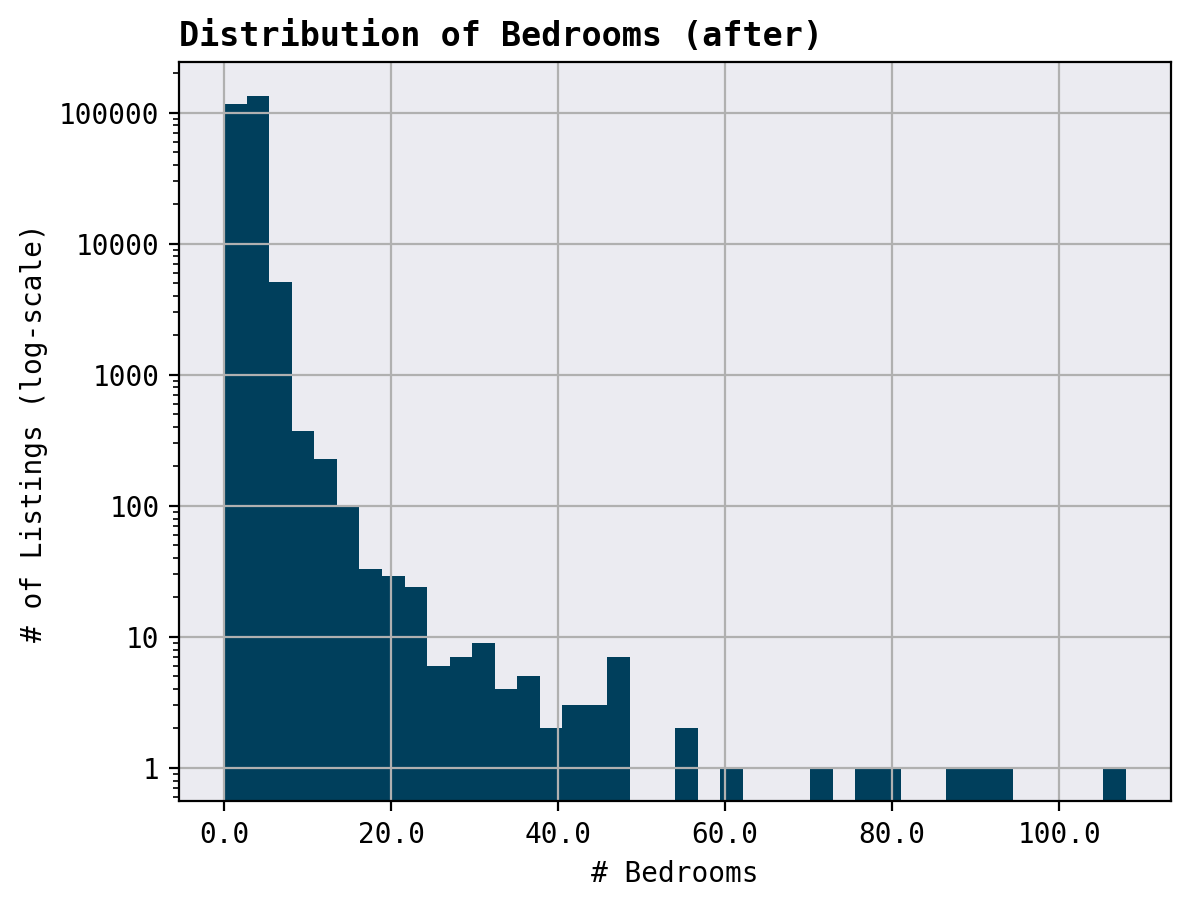

In [32]:
# Visualize data.
column='bedrooms'
title='Distribution of Bedrooms (after)'
xlabel='# Bedrooms'
ylabel='# of Listings (log-scale)'
log=True

histogram(column, title, xlabel, ylabel, log, df)

### Bathrooms

<div class="alert alert-block alert-info"><b>Definition: </b> Bathrooms is the number of rooms that can be used for either washing or going to the restroom. A half bath is typically defined as a bathroom where you can use the restroom, but cannot wash.</div> 

The cleaning steps are very similar here to bedrooms (update Vacant Land data, drop null records, update outliers with obvious data entry issues).

In [33]:
# Quick group by.
groupit('bathrooms')

bathrooms
2.00       72303
3.00       55279
0.00       21612
1.00       21398
4.00       18840
           ...  
1.20           1
0.10           1
2.30           1
3.25           1
3600.00        1
Length: 71, dtype: int64


In [34]:
# Null check.
nullcheck('bathrooms')

bathrooms
Nulls: 63784


<ipython-input-6-e8e7d24ab219>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([round(float(x),1) for x in plt.gca().get_xticks()])


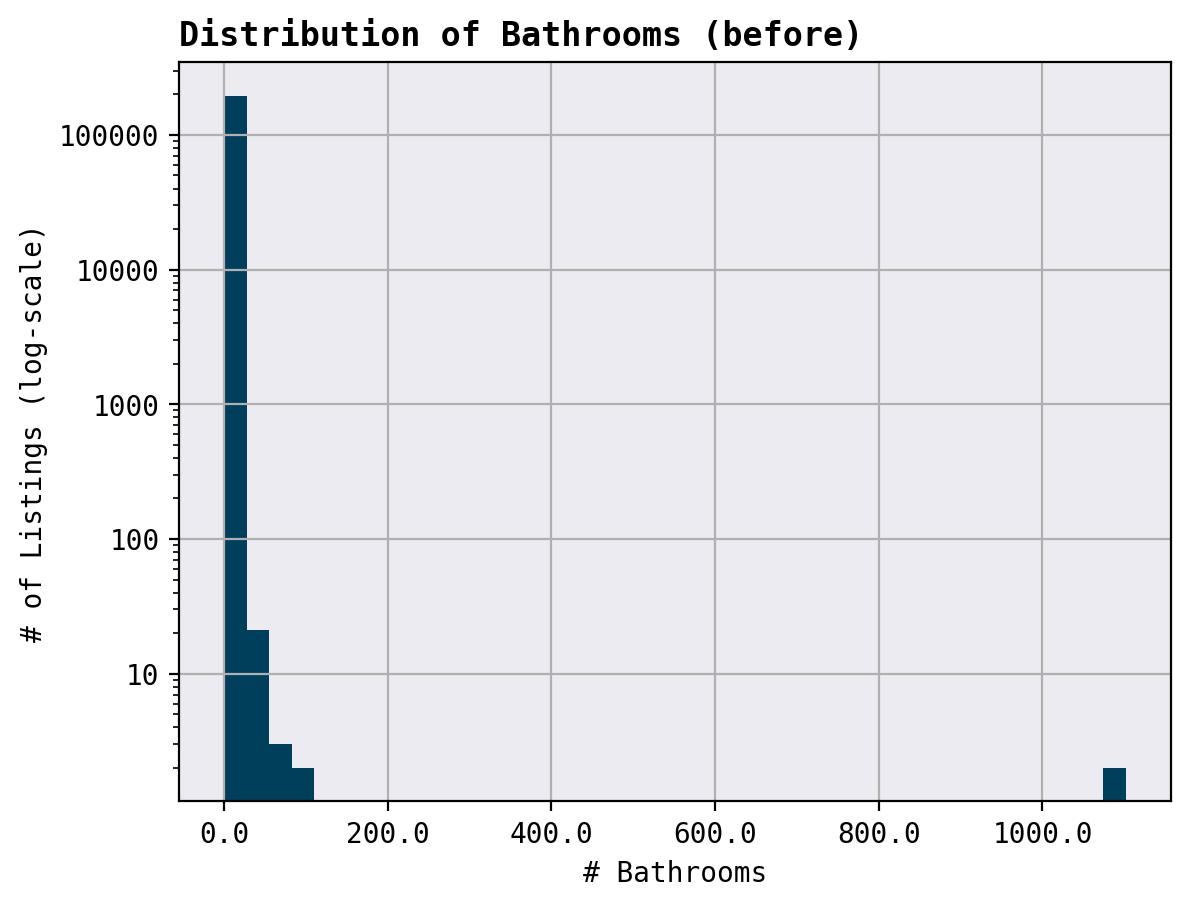

In [35]:
# Visualize Data.
column='bathrooms'
title='Distribution of Bathrooms (before)'
xlabel='# Bathrooms'
ylabel='# of Listings (log-scale)'
log=True

histogram(column, title, xlabel, ylabel, log, df)

In [36]:
# Insight: The majority of listings with null bathrooms are VacantLand hometypes.
df[df['bathrooms'].isnull()][['homeType']].groupby('homeType').size().sort_values(ascending=False)

homeType
VacantLand            61323
MultiFamily             257
SingleFamily             59
MobileManufactured        8
Condo                     3
dtype: int64

In [37]:
# Rewrite bathroom value for VacantLand home type as 0.
df.loc[(df['bathrooms'].isnull()) & (df['homeType'] == 'VacantLand'), 'bathrooms'] = 0

In [38]:
# Check to see result is fixed.
nullcheck('bathrooms',df=df)

bathrooms
Nulls: 327


In [39]:
# Drop records that don't have bedrooms -- most of these have incomplete Zillow data.
df.dropna(subset=['bathrooms'], inplace=True)

In [40]:
# Insight: outlier listings put in square footage for bathrooms accidentally.
df[df['bathrooms'] > 500]

,zillowId,homeStatus,streetAdress,city,state,zipcode,price,bedrooms,bathrooms,yearBuilt,zestimate,homeType,pricePerSquareFoot,livingArea,basementYN,hasGarage,parkingCapacity,listingTerms,schools,sewer,patioAndPorchFeatures,hasHeating,fireplaces,hasWaterfrontView,isSeniorCommunity,levels,lotSize,hoaFee,buyersFeePerc,daysOnZillow,views,favorites,latitude,longitude,mainPhoto,brokerage,percSellFaster,propertyTax,mortgageRate,listingUserId,agentName,agentRating,agentRecentSales,agentReviewsCount,photosList,isForeclosure,isFSBO,isBankOwned,isZillowOwned,rentZestimate,totalActualRent,annual_house_insurance,price_history,description,hasPrivatePool,attic,similarHomes
74043,49744769,FOR_SALE,1515 Main St,Burgettstown,PA,15021,150000,2.0,1102.0,1900.0,147700.0,MultiFamily,NaN,NaN,False,False,4.0,NaN,"[{""distance"": 0.9, ""name"": ""Burgettstown Middl...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.30 Acres,NaN,NaN,134.0,204.0,7.0,40.382984,-80.392235,https://photos.zillowstatic.com/fp/59b0a6027f5...,BERKSHIRE HATHAWAY THE PREFERRED REALTY,0.41,1.09,5.902,X1-ZUupdbh4dqdtl5_1oeg0,Michael Wicker,0.0,0.0,0.0,"[""https://photos.zillowstatic.com/fp/59b0a6027...",False,False,False,False,749.0,NaN,630.0,"[[""2023-08-13"", 150000], [""2018-06-01"", 535], ...",Calling all Investors! This rare gem is 1 of 9...,NaN,NaN,"[49744871, 144611463, 49744771, 49795239, 4974..."
96026,214094716,FOR_SALE,830 Long Branch Rd,Grover,NC,28073,215000,3.0,1099.0,1992.0,197000.0,SingleFamily,196.0,"1,098 sqft",False,True,2.0,NaN,"[{""distance"": 3.1, ""name"": ""Grover Elementary""...","[""Septic Installed""]",NaN,True,NaN,NaN,NaN,NaN,1.61 Acres,NaN,3,127.0,364.0,10.0,35.218410,-81.456210,https://photos.zillowstatic.com/fp/7d250479a31...,RE/MAX Select,0.59,0.68,5.902,X1-ZUyp343nyv3l6x_7zyki,"Don L. Peeler, GRI",5.0,0.0,2.0,"[""https://photos.zillowstatic.com/fp/7d250479a...",False,False,False,False,1400.0,NaN,903.0,"[[""2023-11-17"", 215000], [""2023-09-03"", 222000...",VERY CLEAN 3BR / 1.5 BATH HOME ON 1.6 ACRES WI...,NaN,NaN,"[78285393, 338483336, 102232710, 93012443, 782..."


In [41]:
# Rewrite the correct values for each bathroom after reading their listing.
df.loc[(df['bathrooms'] == 1102), 'bathrooms'] = 1
df.loc[(df['bathrooms'] == 1099), 'bathrooms'] = 1.5
df.loc[(df['bathrooms'] == 1000), 'bathrooms'] = 1
df.loc[(df['bathrooms'] == 3600), 'bathrooms'] = 1

In [42]:
# After reviewing it, this looks like a listing with no bathrooms.
df.loc[(df['bathrooms'] == .1), 'bathrooms'] = 0

<ipython-input-6-e8e7d24ab219>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([round(float(x),1) for x in plt.gca().get_xticks()])


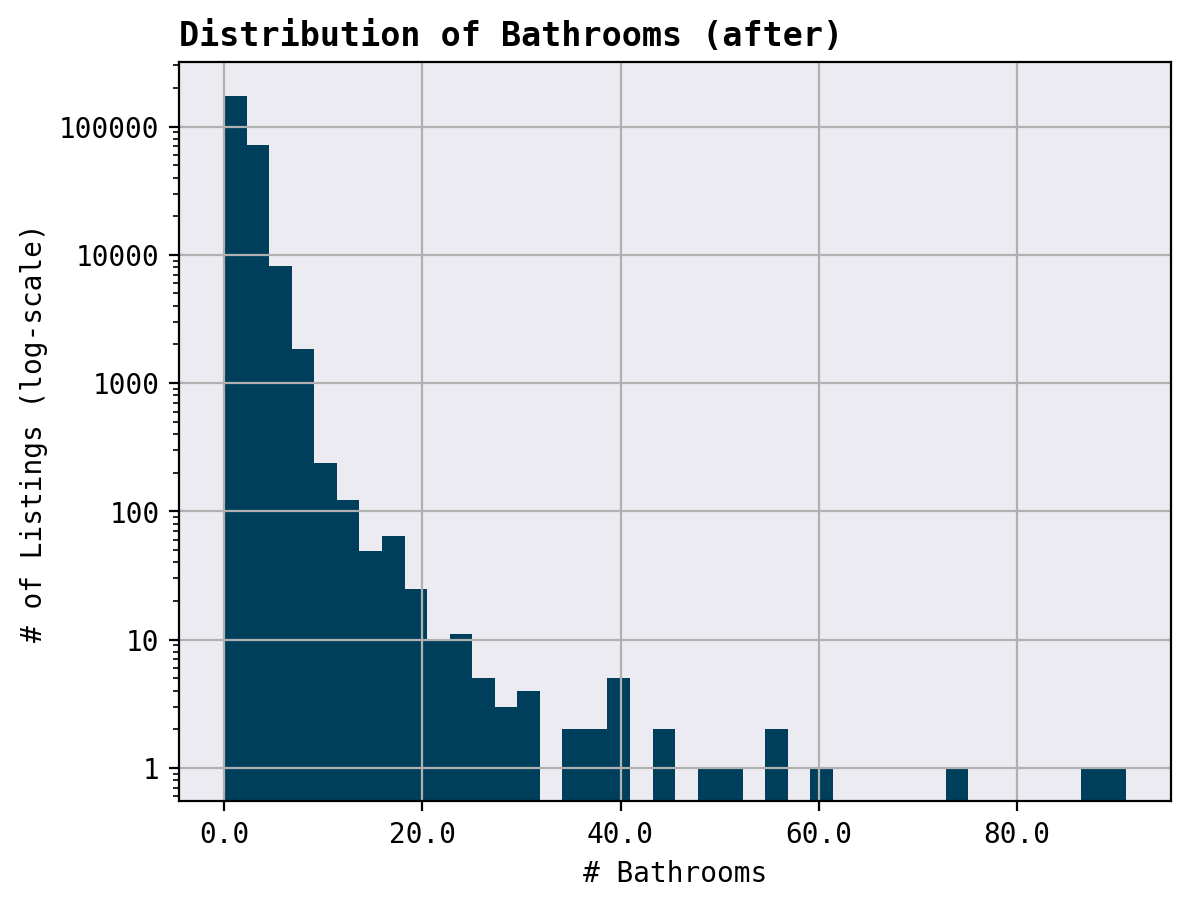

In [43]:
# Visualize data.
column='bathrooms'
title='Distribution of Bathrooms (after)'
xlabel='# Bathrooms'
ylabel='# of Listings (log-scale)'
log=True

histogram(column, title, xlabel, ylabel, log, df)

### yearBuilt

<div class="alert alert-block alert-info"><b>Definition: </b> yearBuilt is the year in which the home was constructed.</div> 

I am going to drop this. The null rate is pretty high, and I don't think this is something I want to use for my model now that I've had a chance to look at it. Old homes can be either more or less expensive depending on a lot of other factors about the home.

In [44]:
# Quick group by to look at where the null records are for this value.
df[df['yearBuilt'].isnull()][['homeType']].groupby('homeType').size().sort_values(ascending=False)

homeType
VacantLand            80087
SingleFamily           4772
MobileManufactured      302
Condo                   284
Townhouse               209
MultiFamily             189
Cooperative              39
dtype: int64

In [45]:
# Drop the column.
df.dropna(subset='yearBuilt', inplace=True)

### zestimate

<div class="alert alert-block alert-info"><b>Definition: </b> zestimate is Zillow's estimate of what the price for this listing should be.</div> 

Nothing to do here. Not all homes have a Zestimate, and that's okay. We don't want to impute or transform this data at all, because we won't use it in the model. Instead, we'll hold it in reserve as a secondary measure to look at when comparing the accuracy of my model compared to the Zestimate.

### Home Type.

<div class="alert alert-block alert-info"><b>Definition: </b>Home Type is the classification that best describes the listing (home, multi-family, apartment, vacant land).</div>

Nothing to do here. Data quality is good, there is nothing to update.

### livingArea

<div class="alert alert-block alert-info"><b>Definition: </b>Living Area is the square footage of space that the listing provides as shelter inside the structure.</div>

Many `VacantLand` home types seem to be listing the `livingArea` as the size of the property. This leads to massive values (1,000,000+ square feet).

However, these should not be valued the same way as true `livingArea` in a constructed house. Since there is another value that captures property size, we will default these to zero for `VacantLand` listings.

We'll also update some outlier values that seem incorrect, and make sure this value is stored as a float and remove superfluous strings ("sqft").

In [46]:
# Quick group by.
groupit('livingArea',df=df)

livingArea
1,200 sqft    736
1,440 sqft    591
1,800 sqft    589
1,500 sqft    564
1,600 sqft    560
             ... 
6,369 sqft      1
6,363 sqft      1
6,361 sqft      1
6,360 sqft      1
0.25 sqft       1
Length: 7427, dtype: int64


In [47]:
# null check.
nullcheck('livingArea')

livingArea
Nulls: 89600


In [48]:
# Quick group by to look at where the null records are for this value.
df[df['livingArea'].isnull()][['homeType']].groupby('homeType').size().sort_values(ascending=False)

homeType
SingleFamily          3264
VacantLand            1083
MobileManufactured     648
MultiFamily            585
Condo                  336
Townhouse              234
Cooperative            191
Apartment                4
dtype: int64

In [49]:
"""
livingAreaTypeConversion

converts the datatype for this column into a float.

    Args:
        x: the value from the column 'livingArea'.
        
    Returns:
        If x is a string is strips the ' sqft' string and returns the
        remaining value as a float. If it is not a string, it returns
        x as is.
"""
def livingAreaTypeConversion(x):
    if isinstance(x, str):
        return float(x.replace(' sqft','').replace(',',''))
    else:
        return x
    
# Apply the function.
df['livingArea'] = df['livingArea'].apply(livingAreaTypeConversion)

In [50]:
# Quick group by to check if results were applied.
groupit('livingArea',df=df)

livingArea
1200.0        736
1440.0        591
1800.0        589
1500.0        564
1600.0        560
             ... 
6613.0          1
6612.0          1
6610.0          1
6606.0          1
56282134.0      1
Length: 7427, dtype: int64


<ipython-input-6-e8e7d24ab219>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([round(float(x),1) for x in plt.gca().get_xticks()])


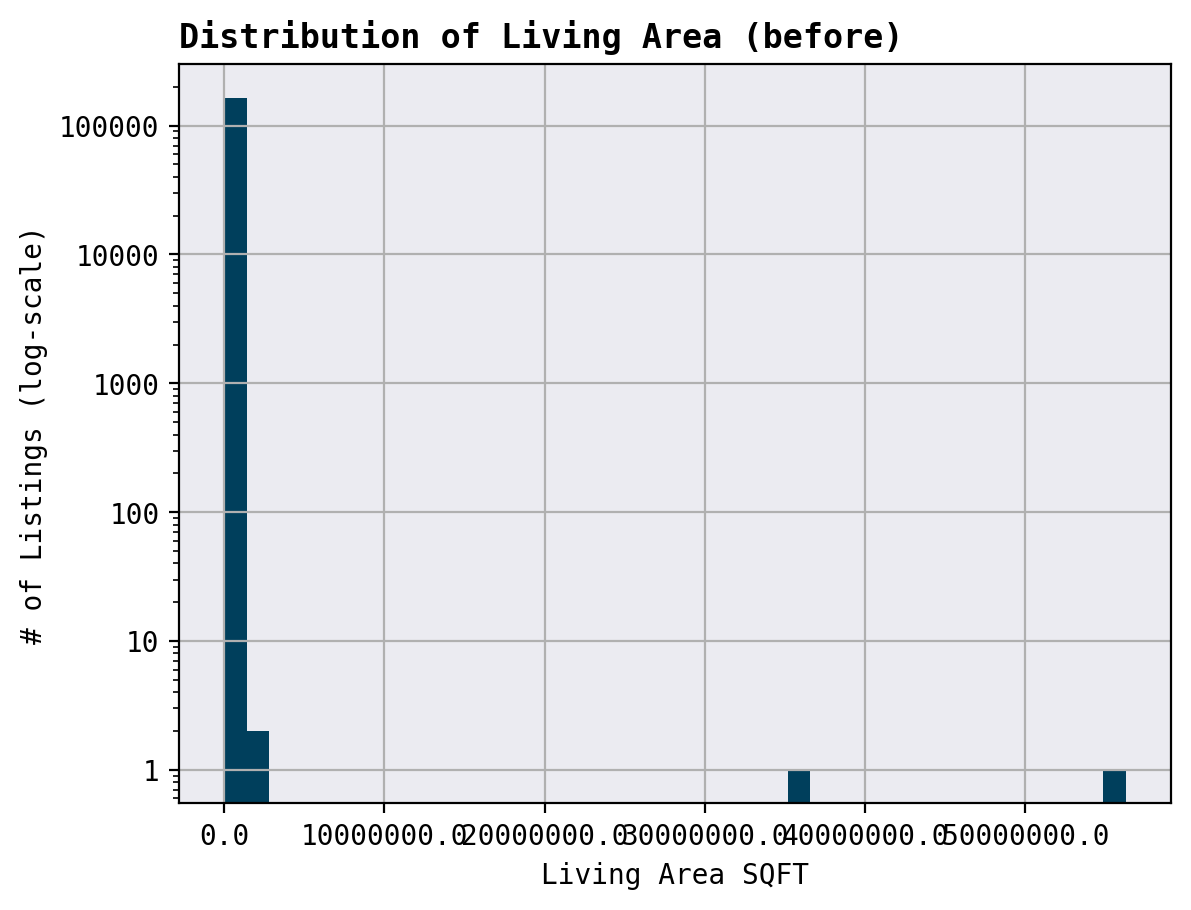

In [51]:
column='livingArea'
title='Distribution of Living Area (before)'
xlabel='Living Area SQFT'
ylabel='# of Listings (log-scale)'
log=True


histogram(column, title, xlabel, ylabel, log, df)

In [52]:
# Insight: Some VacantLand hometypes are listing the area of their property as living space.
df[['homeType','livingArea']].groupby('homeType').mean().sort_values

<bound method DataFrame.sort_values of                      livingArea
homeType                       
Apartment           1276.160305
Condo               1393.255063
Cooperative         1219.701493
MobileManufactured  1304.424906
MultiFamily         3340.752813
SingleFamily        3089.471400
Townhouse           1774.039627
VacantLand          2499.769231>

In [53]:
"""
zeroLivingArea

if the homeType is VacantLand, return 0 for living area. There is no structure on the land.

    Args:
        homeType: The homeType for the listing.
        livingArea: the livingArea for the listing.
    
    Returns:
        0 if homeType is VacantLand, or the current value of livingArea if homeType is 
        anything else.
"""
def zeroLivingArea(homeType, livingArea):
    if homeType == 'VacantLand':
        return 0
    else:
        return livingArea
    
# Apply function to living area.
df['livingArea'] = df.apply(lambda row: zeroLivingArea(row['homeType'], row['livingArea']), axis=1)

In [54]:
# Look at remaining outliers that have suspciously large values for living space.
df[df['livingArea'] > 8e4]

,zillowId,homeStatus,streetAdress,city,state,zipcode,price,bedrooms,bathrooms,yearBuilt,zestimate,homeType,pricePerSquareFoot,livingArea,basementYN,hasGarage,parkingCapacity,listingTerms,schools,sewer,patioAndPorchFeatures,hasHeating,fireplaces,hasWaterfrontView,isSeniorCommunity,levels,lotSize,hoaFee,buyersFeePerc,daysOnZillow,views,favorites,latitude,longitude,mainPhoto,brokerage,percSellFaster,propertyTax,mortgageRate,listingUserId,agentName,agentRating,agentRecentSales,agentReviewsCount,photosList,isForeclosure,isFSBO,isBankOwned,isZillowOwned,rentZestimate,totalActualRent,annual_house_insurance,price_history,description,hasPrivatePool,attic,similarHomes
8830,331359146,FOR_SALE,6315 Rawson Rd,Corning,CA,96021,31009440,0.0,0.0,1999.0,1031800.0,SingleFamily,1.0,56282134.0,False,False,0.0,NaN,"[{""distance"": 3.8, ""name"": ""Woodson Elementary...",NaN,NaN,NaN,NaN,NaN,NaN,One,"1,292 Acres",NaN,NaN,386.0,288.0,3.0,39.981810,-122.23447,https://photos.zillowstatic.com/fp/8df5b14c571...,Fidelity Real Estate Group,0.32,1.05,6.605,NaN,NaN,5.0,0.0,21.0,"[""https://photos.zillowstatic.com/fp/8df5b14c5...",False,False,False,False,4126.0,NaN,130239.648,"[[""2022-12-01"", 31009440], [""2003-07-10"", 2900...","1,292.06-acre ag portfolio in Tehama County cu...",NaN,NaN,NaN
15423,16532627,FOR_SALE,2210 County Road 88,Dunnigan,CA,95937,799000,1.0,1.0,0.0,733500.0,SingleFamily,1.0,788000.0,False,False,0.0,NaN,"[{""distance"": 7.7, ""name"": ""Lloyd G. Johnson J...","[""Septic Tank""]",NaN,True,0.0,NaN,NaN,NaN,18.09 Acres,NaN,2.5,52.0,247.0,5.0,38.908050,-121.99202,https://photos.zillowstatic.com/fp/272ce631185...,Honest and Real Realty Inc,0.55,1.14,6.651,NaN,NaN,5.0,0.0,18.0,"[""https://photos.zillowstatic.com/fp/272ce6311...",False,False,False,False,1800.0,NaN,3355.800,"[[""2023-11-01"", 799000], [""2023-10-30"", null],...",Your Dream Just came true 18.09 Acres of land....,NaN,NaN,"[2059408723, 2054535060]"
25181,2059812116,FOR_SALE,"Residence Five Plan, Magnolia at Granite Bay",Granite Bay,CA,95746,2093000,5.0,6.0,2023.0,1983000.0,SingleFamily,1.0,2025000.0,False,True,5.0,NaN,"[{""distance"": 0.3, ""name"": ""Greenhills Element...",NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,32.0,492.0,18.0,38.754380,-121.21730,https://photos.zillowstatic.com/fp/385744c420a...,Tim Lewis Communities,NaN,1.09,6.569,X1-ZU13cjg0v2neio9_799rj,NaN,NaN,NaN,NaN,"[""https://photos.zillowstatic.com/fp/385744c42...",False,False,False,False,8092.0,NaN,NaN,"[[""2023-06-03"", 2093000], [""2023-04-22"", 20750...",Transcend your style of living at this captiva...,NaN,NaN,NaN
38850,7752011,FOR_SALE,3331 W Harmont Dr,Phoenix,AZ,85051,800000,9.0,0.0,1974.0,NaN,MultiFamily,3.0,256100.0,False,False,4.0,"Conventional,FHA","[{""distance"": 0.7, ""name"": ""Alta Vista Element...","[""Public Sewer""]",NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,374.0,20.0,33.555046,-112.13131,https://photos.zillowstatic.com/fp/6a3dd0dfd8f...,Realty ONE Group,0.71,0.47,6.553,X1-ZUym31c75r1yq1_6le3i,Maisha Fair,0.0,0.0,0.0,"[""https://photos.zillowstatic.com/fp/6a3dd0dfd...",False,False,False,False,NaN,NaN,3360.000,"[[""2023-12-09"", 800000], [""2017-02-23"", 650], ...",Welcome to this 4-plex located in the highly ...,NaN,NaN,[81995599]
59115,237749016,FOR_SALE,42 Sarah Ct,Dallas,GA,30157,414900,4.0,3.0,2023.0,NaN,SingleFamily,2.0,236400.0,False,True,2.0,NaN,"[{""distance"": 1.6, ""name"": ""New Georgia Elemen...","[""Septic Tank""]","[""Deck"", ""Front Porch""]",True,1.0,NaN,NaN,Two,0.93 Acres,NaN,3,177.0,157.0,5.0,33.797276,-84.87269,https://photos.zillowstatic.com/fp/813cc40e3db...,"Keystone Realty Group, LLC.",0.27,0.92,6.276,X1-ZU10iur9xndum89_4lr3f,Corren Hill,0.0,0.0,0.0,"[""https://photos.zillowstatic.com/fp/813cc40e3...",False,False,False,False,NaN,NaN,1742.580,"[[""2023-12-16"", 414900], [""2023-12-06"", 414900...",Welcome HOME! Builder is offering $20K* to buy...,NaN,NaN,"[2056009730, 237735017, 237714736, 237745840, ..."
63244,179758794,FOR_SALE,19202 Wicker Ave,Lowell,IN,46356,900000,0.0,0.0

In [55]:
# Update values for homes that have clear issues based on manual review.
df.loc[(df['livingArea'] == 56282134.0), 'livingArea'] = 0
df.loc[(df['livingArea'] == 35502940.0), 'livingArea'] = 3550
df.loc[(df['livingArea'] == 2025000.0), 'livingArea'] = 2500
df.loc[(df['livingArea'] == 2178000.0), 'livingArea'] = 0
df.loc[(df['livingArea'] == 35502940.0), 'livingArea'] = 1200
df.loc[(df['livingArea'] == 788000.0), 'livingArea'] = 0
df.loc[(df['livingArea'] == 256100.0), 'livingArea'] = 4000
df.loc[(df['livingArea'] == 236400.0), 'livingArea'] = 2313
df.loc[(df['livingArea'] == 349000.0), 'livingArea'] = 2400
df.loc[(df['livingArea'] == 389900.0), 'livingArea'] = 2000
df.loc[(df['livingArea'] == 879912.0), 'livingArea'] = 2000
df.loc[(df['livingArea'] == 1037103.0), 'livingArea'] = 2000
df.loc[(df['livingArea'] == 117176.0), 'livingArea'] = 1176
df.loc[(df['zillowId'] == 2055835359), 'livingArea'] = 21000
df.loc[(df['zillowId'] == 2055837098), 'livingArea'] = 21000
df.loc[(df['livingArea'] == 135036.0), 'livingArea'] = 1250
df.loc[(df['livingArea'] == 108870.0), 'livingArea'] = 2000
df.loc[(df['livingArea'] == 117176.0), 'livingArea'] = 20000

In [56]:
# How are we doing on null records now?
df[df['livingArea'].isnull()][['homeType']].groupby('homeType').size().sort_values(ascending=False)

homeType
SingleFamily          3264
MobileManufactured     648
MultiFamily            585
Condo                  336
Townhouse              234
Cooperative            191
Apartment                4
dtype: int64

<ipython-input-6-e8e7d24ab219>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([round(float(x),1) for x in plt.gca().get_xticks()])


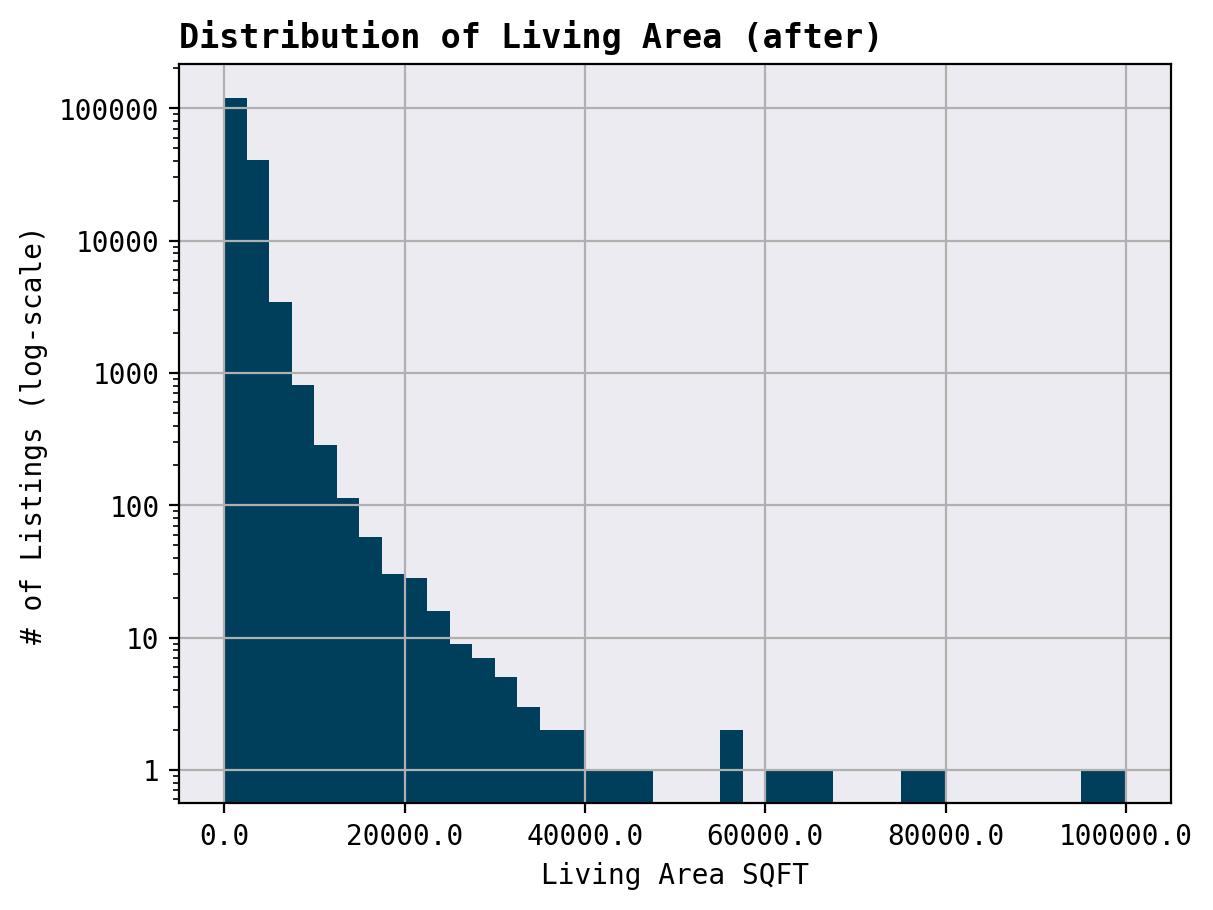

In [57]:
column='livingArea'
title='Distribution of Living Area (after)'
xlabel='Living Area SQFT'
ylabel='# of Listings (log-scale)'
log=True


histogram(column, title, xlabel, ylabel, log, df)

### pricePerSquareFoot

<div class="alert alert-block alert-info"><b>Definition: </b>Price per Square foot is the price of the listing divided by the living area in square footage of the home.</div>

I may choose to drop this metric for now, since there are a number of homes that don't have the pre-requesite data to impute this well for every listing.

I may walk that choice back later, we will see.

In [58]:
# Group by of records by homeType with null pricePerSquareFoot.
df[df['pricePerSquareFoot'].isnull()][['homeType']].groupby('homeType').size().sort_values(ascending=False)

homeType
SingleFamily          6316
VacantLand            1083
MobileManufactured     873
MultiFamily            690
Condo                  557
Townhouse              544
Cooperative            191
Apartment                4
dtype: int64

In [59]:
# Group by of records by homeType with null pricePerSquareFoot and null livingArea (which we would use to figure out price per square foot).
df[(df['pricePerSquareFoot'].isnull()) & (df['livingArea'].isnull())][['homeType']].groupby('homeType').size().sort_values(ascending=False)

homeType
SingleFamily          3264
MobileManufactured     648
MultiFamily            585
Condo                  336
Townhouse              234
Cooperative            191
Apartment                4
dtype: int64

In [60]:
# Drop column.
df.drop(columns=['pricePerSquareFoot'], inplace=True)

### basementYN

<div class="alert alert-block alert-info"><b>Definition: </b>BasementYN says whether or not this listing has a basement in the home.</div>

This looks like a legacy field that is no longer being used -- all listings are set to `False`. We'll drop this record for now.

In [61]:
# Quick group by.
groupit('basementYN')

basementYN
False    264498
dtype: int64


In [62]:
# Null check.
nullcheck('basementYN')

basementYN
Nulls: 0


In [63]:
# Drop column.
df.drop(columns=['basementYN'],inplace=True)

### hasGarage

<div class="alert alert-block alert-info"><b>Definition: </b>hasGarage says whether or not this listing has a garage as part of the home.</div>

This one is in pretty good shape, nothing to do here. All values are either `True` or `False`, and there arre no nulls.

In [64]:
# Quick group by.
groupit('hasGarage',df=df)

hasGarage
True     118480
False     52086
dtype: int64


In [65]:
# Null check.
nullcheck('hasGarage')

hasGarage
Nulls: 0


### parkingCapacity

<div class="alert alert-block alert-info"><b>Definition: </b>parkingCapacity says how many cars can park at this property.</div>

This one is also solid too -- mostly. But there are some suspicious looking outliers. We're going to manually update the values for a few of these more obvious mistakes.

In [66]:
# Quick group by.
groupit('parkingCapacity')

parkingCapacity
0.0       128543
2.0        78548
1.0        20855
3.0        19316
4.0         8154
           ...  
70.0           1
67.0           1
63.0           1
59.0           1
4848.0         1
Length: 140, dtype: int64


In [67]:
# Null check.
nullcheck('parkingCapacity')

parkingCapacity
Nulls: 0


<ipython-input-6-e8e7d24ab219>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([round(float(x),1) for x in plt.gca().get_xticks()])


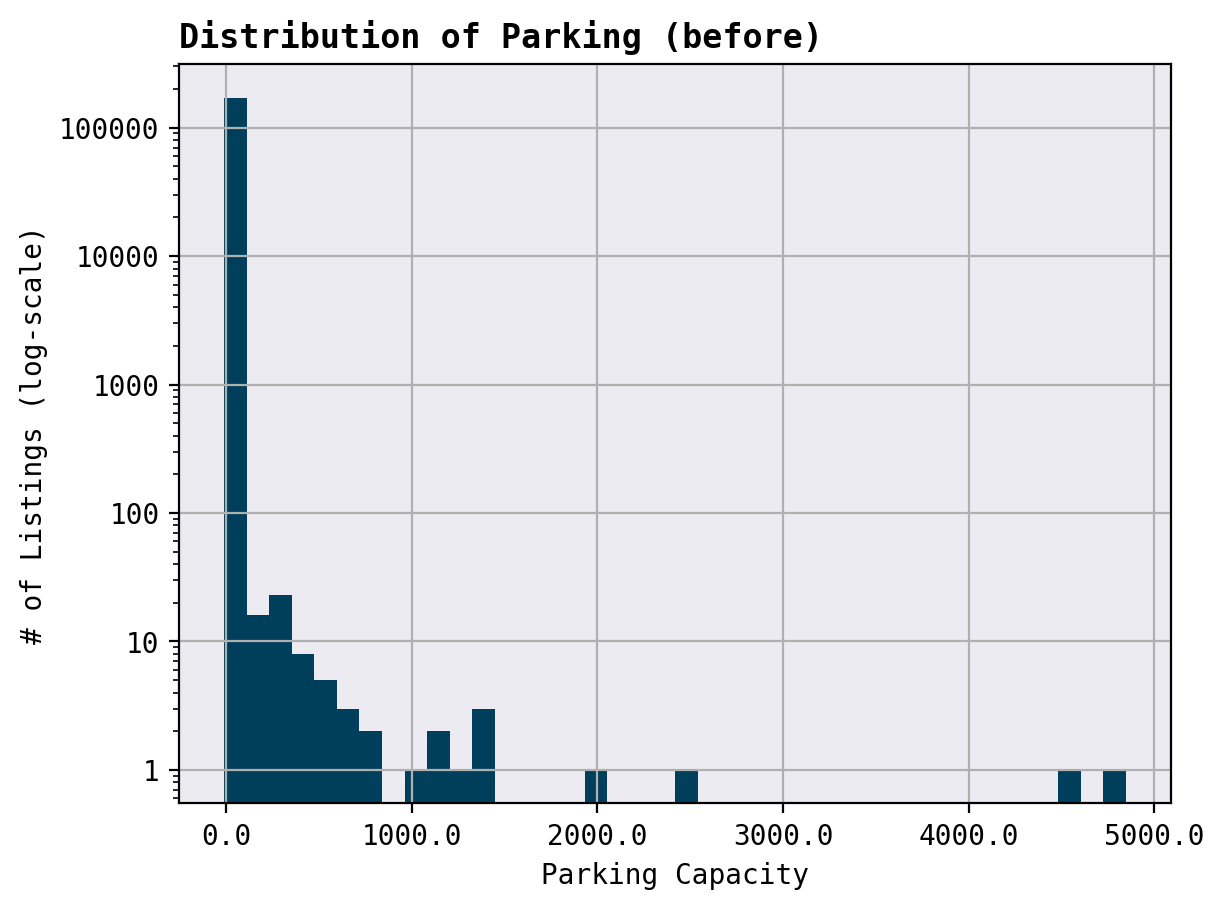

In [68]:
column='parkingCapacity'
title='Distribution of Parking (before)'
xlabel='Parking Capacity'
ylabel='# of Listings (log-scale)'
log=True


histogram(column, title, xlabel, ylabel, log, df)

In [69]:
# Insight: some people are putting their livingArea as the value for parkingCapacity.
df[df['parkingCapacity'] > 1000][['zillowId','parkingCapacity']]

,zillowId,parkingCapacity
3726,82947411,1404.0
15782,48721133,1372.0
24301,2053839522,1293.0
49455,106925215,4500.0
54872,2054434655,1092.0
87190,114625105,1200.0
91694,78323951,4848.0
126880,43524283,1081.0
133374,49152699,1440.0
165623,300263454,2000.0


In [70]:
# Update the obvious mistakes after manual review.
df.loc[(df['parkingCapacity'] == 1404.0), 'parkingCapacity'] = 2
df.loc[(df['parkingCapacity'] == 1372.0), 'parkingCapacity'] = 10
df.loc[(df['parkingCapacity'] == 1293.0), 'parkingCapacity'] = 6
df.loc[(df['parkingCapacity'] == 4500.0), 'parkingCapacity'] = 6
df.loc[(df['parkingCapacity'] == 1092.0), 'parkingCapacity'] = 4
df.loc[(df['parkingCapacity'] == 1200.0), 'parkingCapacity'] = 0
df.loc[(df['parkingCapacity'] == 4848.0), 'parkingCapacity'] = 6
df.loc[(df['parkingCapacity'] == 1081.0), 'parkingCapacity'] = 4
df.loc[(df['parkingCapacity'] == 1440.0), 'parkingCapacity'] = 4
df.loc[(df['parkingCapacity'] == 2000.0), 'parkingCapacity'] = 10
df.loc[(df['parkingCapacity'] == 2468.0), 'parkingCapacity'] = 5


<ipython-input-6-e8e7d24ab219>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([round(float(x),1) for x in plt.gca().get_xticks()])


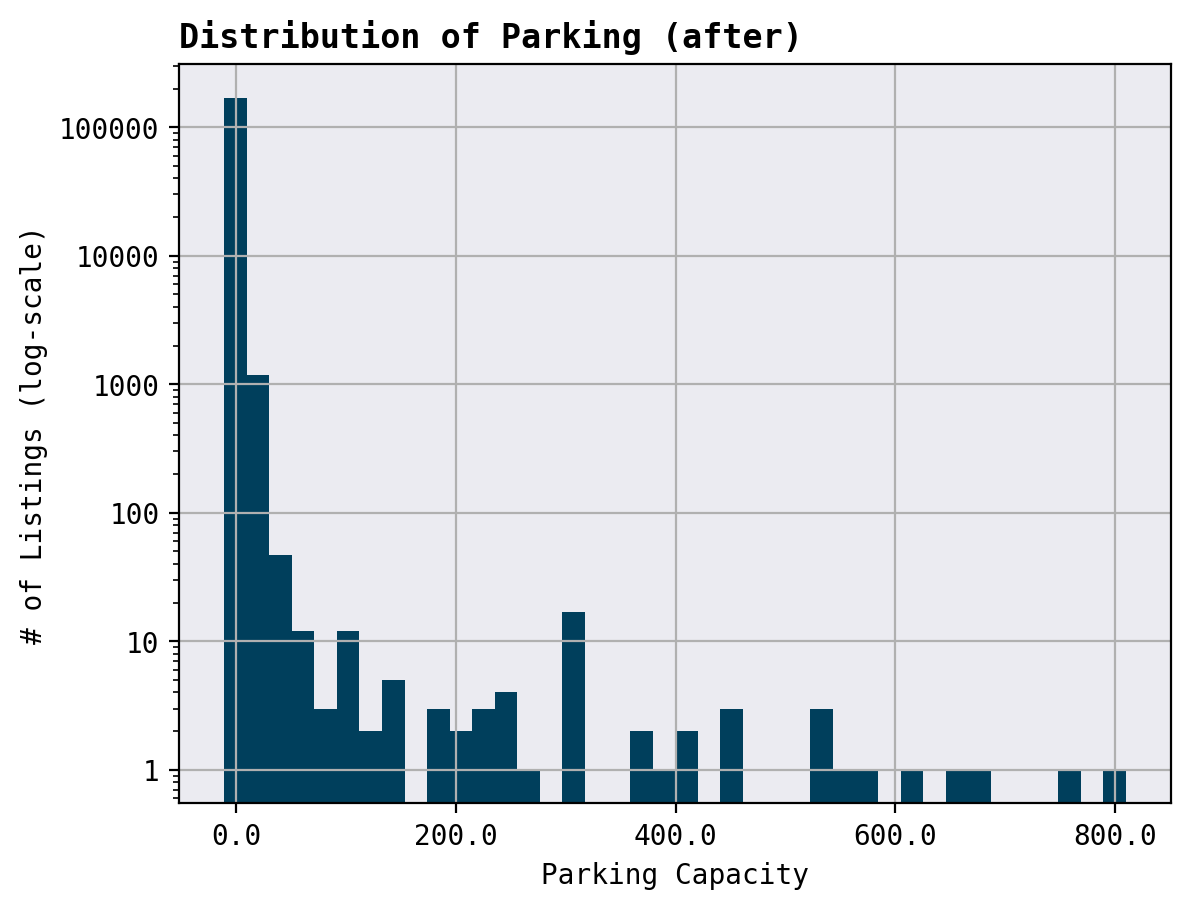

In [71]:
column='parkingCapacity'
title='Distribution of Parking (after)'
xlabel='Parking Capacity'
ylabel='# of Listings (log-scale)'
log=True


histogram(column, title, xlabel, ylabel, log, df)

### listing terms

<div class="alert alert-block alert-info"><b>Definition: </b>listingTerms are the financial stipulations for how the home can be bought.</div>

This one is messy - there is a long dictionary of options, and a lot of homes with no listing terms at all. WI created a series of functions that creates a series of true-false columns that captures the most common types of terms. This classifies about 98% of the homes that have a listing into at least one of the four categories.

In [72]:
# Null check.
nullcheck('listingTerms',df=df)

listingTerms
Nulls: 94556


In [73]:
# Create a dictionary of the most common types of terms, in descneding order.
dictionary = {}

for i, row in df.iterrows():
    try:
        for term in row['listingTerms'].split(','):
            if term in dictionary.keys():
                dictionary[term] += 1
            else:
                dictionary[term] = 1
    except:
        pass

    
dictionary = dict(sorted(dictionary.items(), key=lambda item: item[1], reverse=True))

# Print dictionary.
print(dictionary)

{'Conventional': 65068, 'Cash': 61012, 'FHA': 38226, 'VA Loan': 37502, 'USDA Loan': 6333, 'Cash Out': 5530, '1031 Exchange': 2287, 'Down Payment Resource': 2215, 'Other': 1714, 'New Loan': 1158, 'Contract': 825, 'Owner Will Carry': 791, 'All Cash': 765, 'TX Vet': 629, 'VA': 627, 'CashorConventionalLoan': 605, 'Investor': 581, 'See Remarks': 385, 'Assumable': 345, 'Owner May Carry': 322, 'Any': 316, 'Texas Vet': 272, 'Private Financing Available': 268, 'Submit': 254, 'Warranty Deed': 249, 'Investors OK': 246, 'All Financing Considered': 244, ' CashorConventionalLoan': 233, 'Call Listing Agent': 230, 'State Bond': 219, '3rd Party Financing': 208, 'MSHDA': 180, 'Portfolio Loan': 176, 'Cash to New Loan': 172, 'FMHA/Rural Dev Fin': 146, 'FHA 203K': 144, 'FHA/VA': 142, 'FMHA': 135, 'Must Qualify': 135, 'FHA 203(k)': 133, 'CalHFA': 128, 'THDA': 127, 'Federal Housing': 127, ' VALoan': 123, 'Jumbo': 122, 'Cash To New Loan': 120, 'Rehab Loan': 119, 'Lease Purchase': 116, 'Consider All': 107, 'Le

In [74]:
"""
unpack_terms_cash

Determines if this is a home that has cash terms.

    Args:
        x: the value in column `listingTerms`.
    
    Returns:
        True if it includes one of the listed cash terms, 
        False if not.
"""
def unpack_terms_cash(x):
    try:
        for term in x.split(','):
            if term in ['Cash','All Cash','All Financing Considered']:
                return True
        else:
            return False
    except:
        return False
    
"""
unpack_terms_conventional

Determines if this is a home that has conventional loan terms.

    Args:
        x: the value in column `listingTerms`.
    
    Returns:
        True if it includes one of the listed conventional 
        loan terms, False if not.
"""  
def unpack_terms_conventional(x):
    try:
        for term in x.split(','):
            if term in ['Conventional', 'New Loan','USDA Loan', 'Conventional Mortgage', 'Cash Out','1031 Exchange']:
                return True
        else:
            return False
    except:
        return False
    
"""
unpack_terms_fha

Determines if this is a home that has FHA loan terms.

    Args:
        x: the value in column `listingTerms`.
    
    Returns:
        True if it includes one of the listed FHA 
        loan terms, False if not.
""" 
def unpack_terms_fha(x):
    try:
        for term in x.split(','):
            if term in ['FHA', 'FHA 203K', 'FHA/VA', 'FHA 203(k)', 'FHA-Va Approved', 'FHA 203(b)']:
                return True
        else:
            return False
    except:
        return False

"""
unpack_terms_va

Determines if this is a home that has VA loan terms.

    Args:
        x: the value in column `listingTerms`.
    
    Returns:
        True if it includes one of the listed VA 
        loan terms, False if not.
"""
def unpack_terms_va(x):
    try:
        for term in x.split(','):
            if term in ['VA Loan','Texas Vet', 'VA', 'FHA/VA', 'VALoan', 'FHA-Va Approved']:
                return True
        else:
            return False
    except:
        return False
    
# Apply each of the functions.
df['termsCash'] = df['listingTerms'].apply(unpack_terms_cash)
df['termsConventional'] = df['listingTerms'].apply(unpack_terms_conventional)
df['termsFHA'] = df['listingTerms'].apply(unpack_terms_fha)
df['termsVA'] = df['listingTerms'].apply(unpack_terms_va)

In [75]:
# determines number of listings that don't have True for one of the columns.
len(df[(df['termsCash'] == False) & (df['termsConventional'] == False) & (df['termsFHA'] == False) & (df['termsVA'] == False)])

99126

In [76]:
# Drop column since we've extracted the information we can out of it.
df.drop(columns=['listingTerms'], inplace=True)

### Schools

<div class="alert alert-block alert-info"><b>Definition: </b>Schools is a JSON blob of the nearest High/Middle/Elementary school, how close they are, and what their GreatSchools.org rating is (1-10 scale)</div>

There is a lot of rich information here. I will condense this into a few columns that help us understand the quality of the schools and how close they are to the listing.

In [77]:
df['schools']

2         [{"distance": 0.5, "name": "Fidalgo Elementary...
3         [{"distance": 1.2, "name": "Fidalgo Elementary...
4         [{"distance": 1, "name": "Fidalgo Elementary S...
6         [{"distance": 0.2, "name": "Fidalgo Elementary...
9         [{"distance": 0.7, "name": "Fidalgo Elementary...
                                ...                        
265300    [{"distance": 4.4, "name": "Avon Park High Sch...
265302    [{"distance": 3, "name": "Park Elementary Scho...
265304    [{"distance": 4.6, "name": "Park Elementary Sc...
265306    [{"distance": 4.2, "name": "Avon Park High Sch...
265307    [{"distance": 3, "name": "Park Elementary Scho...
Name: schools, Length: 170566, dtype: object

In [78]:
# Print example of what this data looks like.
json.loads(df['schools'][2])

[{'distance': 0.5,
  'name': 'Fidalgo Elementary School',
  'rating': 9,
  'level': 'Elementary',
  'studentsPerTeacher': None,
  'assigned': None,
  'grades': 'K-5',
  'link': 'https://www.greatschools.org/washington/anacortes/53-Fidalgo-Elementary-School/',
  'type': 'Public',
  'size': None,
  'totalCount': None,
  'isAssigned': None},
 {'distance': 4.4,
  'name': 'Anacortes Middle School',
  'rating': 5,
  'level': 'Middle',
  'studentsPerTeacher': None,
  'assigned': None,
  'grades': '6-8',
  'link': 'https://www.greatschools.org/washington/anacortes/51-Anacortes-Middle-School/',
  'type': 'Public',
  'size': None,
  'totalCount': None,
  'isAssigned': None},
 {'distance': 4.7,
  'name': 'Anacortes High School',
  'rating': 9,
  'level': 'High',
  'studentsPerTeacher': None,
  'assigned': None,
  'grades': '9-12',
  'link': 'https://www.greatschools.org/washington/anacortes/52-Anacortes-High-School/',
  'type': 'Public',
  'size': None,
  'totalCount': None,
  'isAssigned': None}

In [79]:
# Question: what "types" of school are there?
# Answer: Public (majority) and Charter -- Private has only one record.

dictionary = {}

for i, row in df.iterrows():
    try:
        for school in json.loads(row['schools']):
            schoolType = school['type']
            if schoolType in dictionary.keys():
                dictionary[schoolType] += 1
            else:
                dictionary[schoolType] = 1
    except:
        pass

dictionary = dict(sorted(dictionary.items(), key=lambda item: item[1], reverse=True))

# Print dictionary.
print(dictionary)

{'Public': 489839, 'Charter': 3806, 'Private': 1}


In [80]:
"""
school_quality

A function that returns the average quality for High, Middle, and Elementary schools near the listing.

    Arg:
        schools_list: the value stored in the column `schools`.
    
    Returns:
        A dictionary with the average GreatSchools.org rating, grouped by High, Middle, and
        Elementary schools. If there is no school data, return None.

"""

def school_quality(schools_list):
    try:
        schools_list = json.loads(schools_list)

        # Replace 'Primary' with 'Elementary' in the list of dictionaries
        for school in schools_list:
            if 'Primary' in school.get('level', ''):
                school['level'] = 'Elementary'

        # Create a dictionary to store sum and count for each school level
        level_totals = {}
        level_counts = {}

        # Iterate through the list of dictionaries
        for school in schools_list:
            level = school['level']
            rating = school['rating']

            # Skip entries with None in 'level' or 'rating'
            if level is not None and rating is not None:
                # Update the sum and count for the corresponding school level
                level_totals[level] = level_totals.get(level, 0) + rating
                level_counts[level] = level_counts.get(level, 0) + 1

        # Calculate the average rating for each school level
        average_ratings = {level: total / count for level, total, count in zip(level_totals.keys(), level_totals.values(), level_counts.values())}

        return average_ratings

    except:
        return None

In [81]:
"""
overall_average_distance

The average distance in miles for each of the nearby schools and the listing.

    Arg:
        schools_list: the value stored in the column `schools`.
        
    Returns:
        average distance of schools. If no data available, returns
        None.

"""

def overall_average_distance(schools_list):
    try:
        schools_list = json.loads(schools_list)

        # Extract distances from the list of dictionaries
        distances = [school['distance'] for school in schools_list if school['distance'] is not None]

        # Calculate the overall average distance
        overall_average = sum(distances) / len(distances) if distances else None

        return overall_average
    except:
        return None

In [82]:
"""
has_charter_schools

Checks to see if any of the schools nearby are charter schools.

    Arg:
        schools_list: the value stored in the column `schools`.

    Returns:
        True if there is a charter school, False if not, None
        if there is no data.

"""

def has_charter_schools(schools_list):
    try:
        schools_list = json.loads(schools_list)

        # Check if there is any school with the type 'Charter'
        private_schools_exist = any(school['type'] == 'Charter' for school in schools_list)

        return private_schools_exist
    except:
        return None

In [83]:
# Apply distance and charter school functions.
df['schoolAverageDistance'] = df['schools'].apply(overall_average_distance)
df['schoolContainsCharter'] = df['schools'].apply(has_charter_schools)

In [84]:
school_quality_by_level = df['schools'].apply(school_quality)

In [85]:
# Fetch dictionary for average quality by school.
school_quality_by_level = df['schools'].apply(school_quality)

# Normalize the nested dictionaries
normalized_data = pd.json_normalize(school_quality_by_level)

# Concatenate the normalized data with the existing DataFrame
df = pd.concat([df, normalized_data], axis=1)

# Key-value dictionary for renaming columns
column_rename_dict = {'Middle': 'schoolRatingMiddleSchool', 'High': 'schoolRatingHighSchool', 'Elementary':'schoolRatingElementary'}

# Rename columns using the dictionary
df.rename(columns=column_rename_dict, inplace=True)

# Drop the column now that we have extracted what we want.
df.drop(columns='schools',inplace=True)

# Display the result
df[['schoolAverageDistance','schoolContainsCharter','schoolRatingMiddleSchool','schoolRatingHighSchool','schoolRatingElementary']].head()

,schoolAverageDistance,schoolContainsCharter,schoolRatingMiddleSchool,schoolRatingHighSchool,schoolRatingElementary
2,3.200000,False,5.0,9.0,9.0
3,4.033333,False,5.0,9.0,9.0
4,2.633333,False,5.0,9.0,9.0
6,3.066667,False,5.0,8.0,8.0
9,3.366667,False,3.0,6.0,5.0


<ipython-input-6-e8e7d24ab219>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([round(float(x),1) for x in plt.gca().get_xticks()])


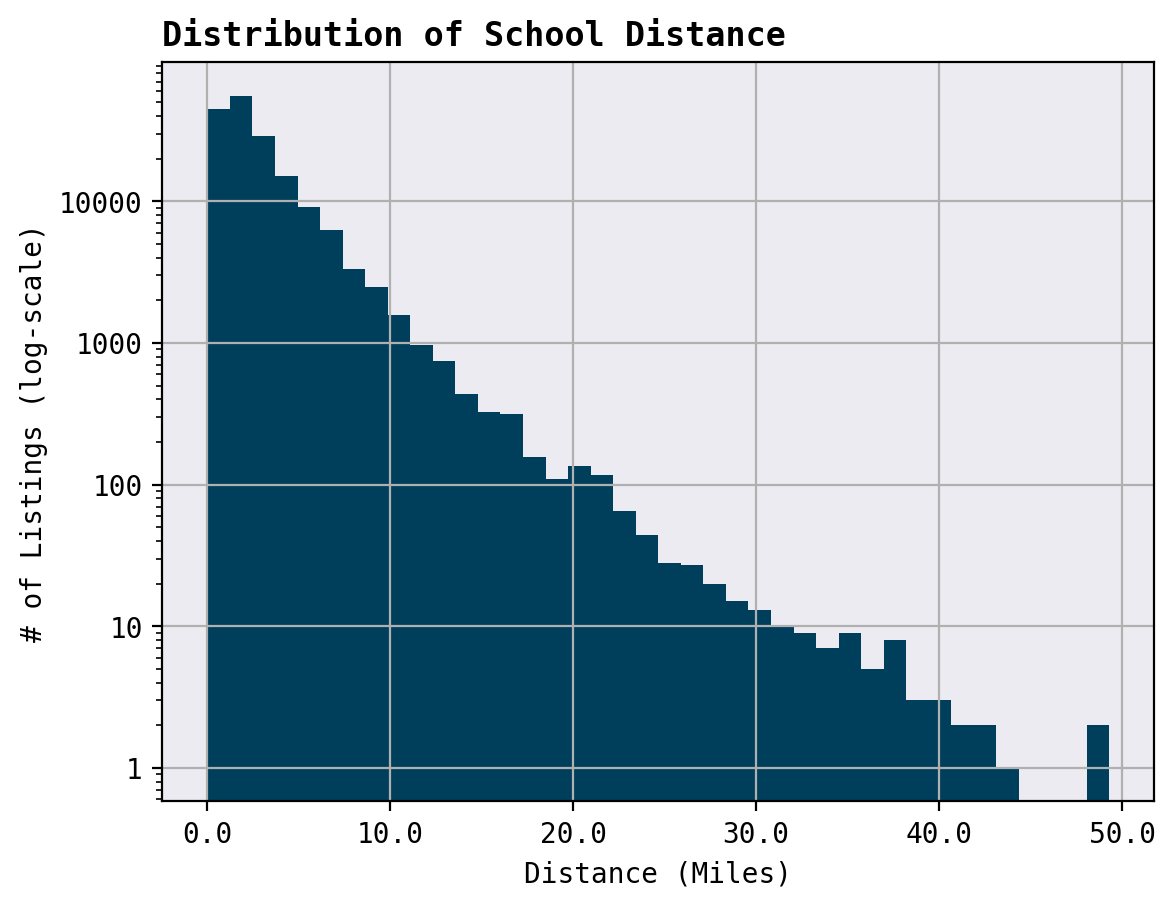

In [86]:
column='schoolAverageDistance'
title='Distribution of School Distance'
xlabel='Distance (Miles)'
ylabel='# of Listings (log-scale)'
log=True


histogram(column, title, xlabel, ylabel, log, df)

In [87]:
#df[['schoolContainsCharter']].groupby('schoolContainsCharter').size()
groupit('schoolContainsCharter',df=df)

schoolContainsCharter
False    167772
True       2535
dtype: int64


<ipython-input-6-e8e7d24ab219>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([round(float(x),1) for x in plt.gca().get_xticks()])


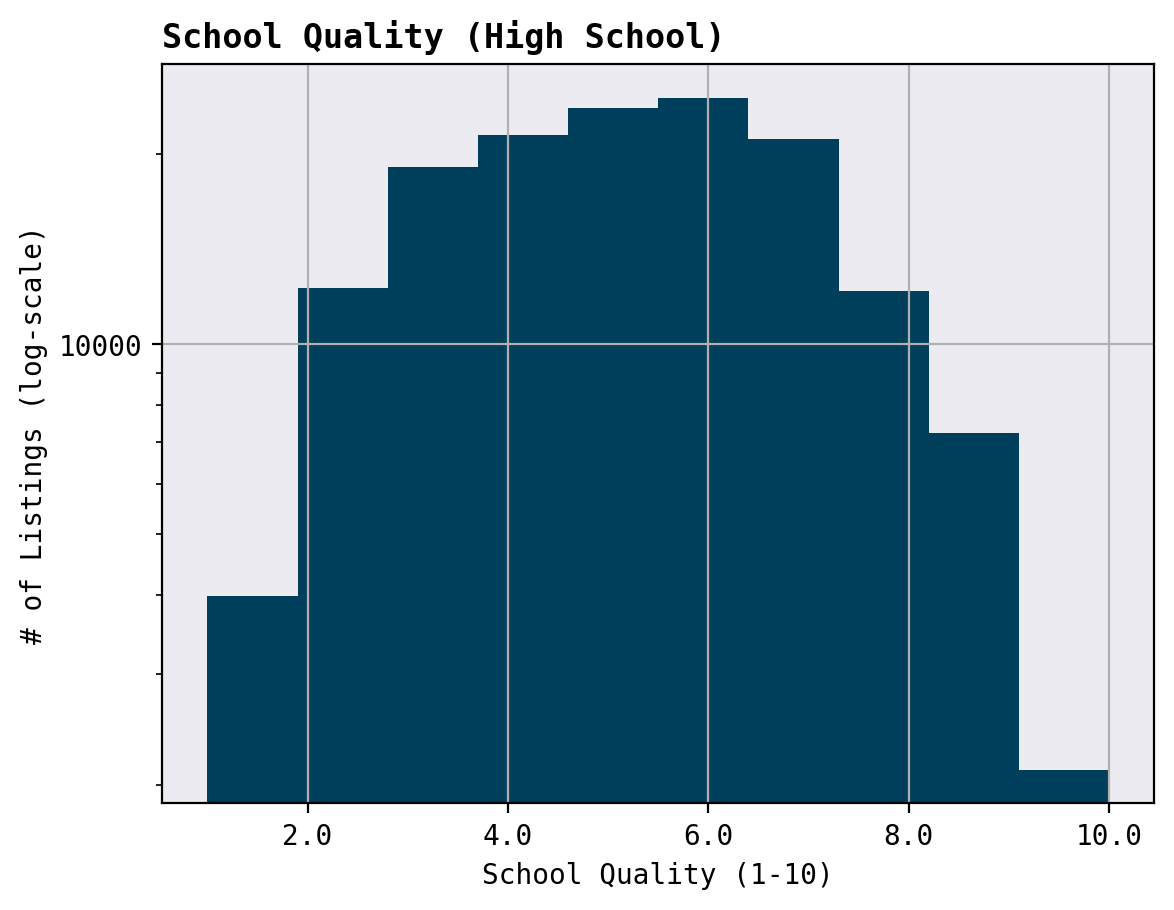

In [88]:
column='schoolRatingHighSchool'
title='School Quality (High School)'
xlabel='School Quality (1-10)'
ylabel='# of Listings (log-scale)'
log=True
bins = 10

histogram(column, title, xlabel, ylabel, log, df, bins=bins)

<ipython-input-6-e8e7d24ab219>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([round(float(x),1) for x in plt.gca().get_xticks()])


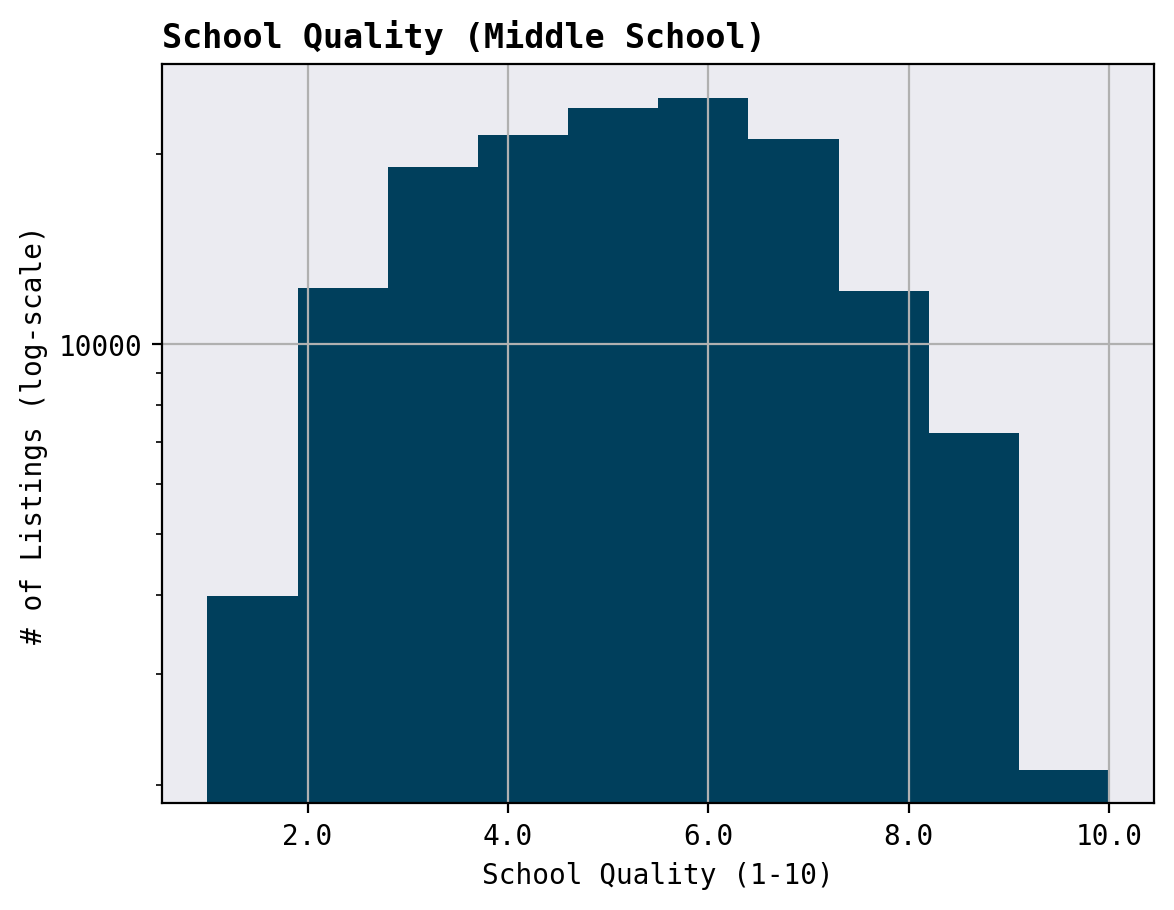

In [89]:
column='schoolRatingHighSchool'
title='School Quality (Middle School)'
xlabel='School Quality (1-10)'
ylabel='# of Listings (log-scale)'
log=True
bins = 10

histogram(column, title, xlabel, ylabel, log, df, bins=bins)

<ipython-input-6-e8e7d24ab219>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([round(float(x),1) for x in plt.gca().get_xticks()])


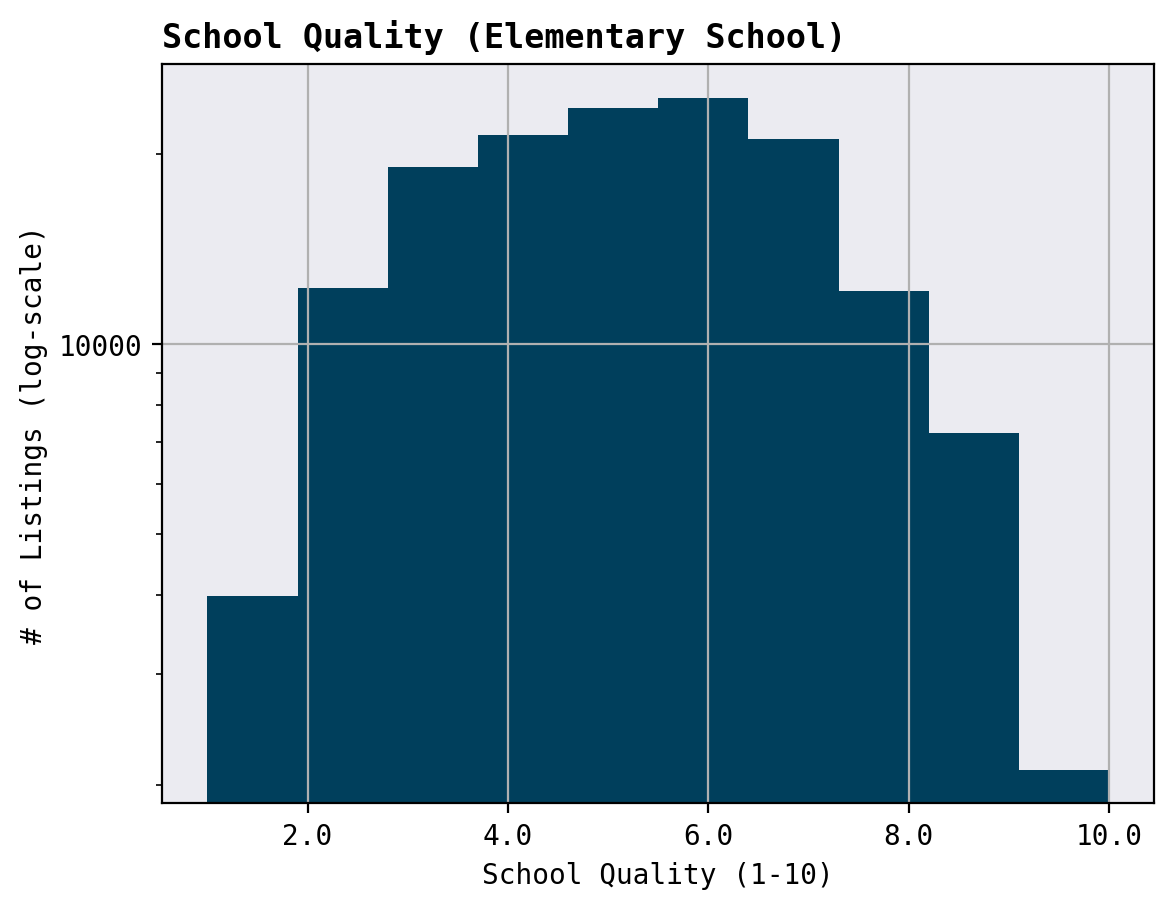

In [90]:
column='schoolRatingHighSchool'
title='School Quality (Elementary School)'
xlabel='School Quality (1-10)'
ylabel='# of Listings (log-scale)'
log=True
bins = 10

histogram(column, title, xlabel, ylabel, log, df, bins=bins)

In [91]:
nullcheck('schoolRatingElementary',df=df)

schoolRatingElementary
Nulls: 73882


In [92]:
nullcheck('schoolRatingMiddleSchool',df=df)

schoolRatingMiddleSchool
Nulls: 89810


In [93]:
nullcheck('schoolRatingHighSchool',df=df)

schoolRatingHighSchool
Nulls: 84114


### sewer

<div class="alert alert-block alert-info"><b>Definition: </b>Sewer defines what kind of waste water options the home has.</div>

This is another messy dictionary of options. Similar to what I did with listing Trems, I'll do my best to condense this to one column with a simpler classification.

In [94]:
# Quick group by.
groupit('sewer')

sewer
["Public Sewer"]                                            83743
["Septic Tank"]                                             24637
["None"]                                                    11465
["Septic Needed"]                                            6232
["Private Sewer"]                                            2685
                                                            ...  
["Public Sewer", "Septic Needed", "Other - See Remarks"]        1
["Public Sewer", "Septic Needed", "Cesspool"]                   1
["Company: Private - Park Shared Septic"]                       1
["Public Sewer", "Septic Available"]                            1
["1000 Gallon", "1500+ Gallon", "Holding Tank"]                 1
Length: 3083, dtype: int64


In [95]:
# See most common sewer types.
dictionary = {}

for i, row in df.iterrows():
    try:
        for sewage_type in ast.literal_eval(row['sewer']):
            if sewage_type in dictionary.keys():
                dictionary[sewage_type] += 1
            else:
                dictionary[sewage_type] = 1
    except:
        pass
    
dictionary = dict(sorted(dictionary.items(), key=lambda item: item[1], reverse=True))

# Print dictionary.
print(dictionary)

{'Public Sewer': 71688, 'Septic Tank': 22551, 'Private Sewer': 2892, 'Sewer Connected': 2814, 'City Sewer/Connected': 1932, 'In & Connected': 1548, 'City': 1386, 'Aerobic Septic': 1341, 'City/County': 1251, 'City Sewer': 1003, 'Municipal Sewer': 991, 'Sewer System': 906, 'Connected': 833, 'Other': 780, 'Septic Installed': 697, 'Company: Septic': 680, 'Municipal': 603, 'Conventional Septic': 603, 'Sewer: Public': 495, 'Sewer at Street': 490, 'On Site Septic': 487, 'None': 460, 'Septic On Site': 457, 'Septic': 442, 'Public Sanitary': 439, 'Sewer': 418, 'Community': 335, 'SAWS': 334, 'On Sewer': 330, 'Private Septic': 328, 'Septic Connected': 313, 'Septic Type Unknown': 299, 'Sewer in Street': 232, 'Unknown': 231, 'Standard Leach Field': 227, 'Sanitary Sewer': 226, 'Community Sewer': 222, 'Municipal Sewer Near': 218, 'Sanitary': 217, 'See Remarks': 206, 'Available': 202, 'Mound Septic': 199, 'County Sewer': 191, 'Company: Seattle Public Utilities': 189, 'Septic Existing on Site': 185, 'Sh

In [96]:
"""
sewerType

Condenses the sewer information of the listing into a simpler classification.

    Args:
        x: the value in column `sewer`.
        
    Returns:
        Condenses values for a home to: 'sewer','septic','other', or 'none'.
"""

def sewerType(x):
    try:    
        sewer_kws = ['sewer','city','county','sanitary','connected','public','private','community','company','municpal','street']
        septic_kws = ['septic','tank']
        none_kws = ['none','not available','not installed']
            
        if any(keyword in x.lower() for keyword in sewer_kws):
            return 'sewer'
        elif any(keyword in x.lower() for keyword in septic_kws):
            return 'septic'
        elif any(keyword in x.lower() for keyword in none_kws):
            return 'none'
        else:
            return 'other'
    except:
        return 'other'

In [97]:
# Apply the function.
df['sewer'] = df.sewer.apply(sewerType)

In [98]:
# Check results with group by.
groupit('sewer',df=df)

sewer
other     112348
sewer      93310
septic     25974
none         307
dtype: int64


In [99]:
# Check results with group by, dropping VacantLand records.
groupit('sewer',df=df[df['homeType'] != 'VacantLand'])

sewer
other     111455
sewer      93136
septic     25807
none         263
dtype: int64


In [100]:
# Confirm: no nulls left for this one.
nullcheck('sewer',df=df)

sewer
Nulls: 0


### patioAndPorchFeatures

<div class="alert alert-block alert-info"><b>Definition: </b>patioAndPorchFeatures contains what type of outdoor living spaces a home has (sun room, patio, deck, porch, et cetera).</div>

The data here, similar to a few other columns seen so far, has a lot of variation. For this one, we don't really care about that variation: I just want to know if you have a feature, or not.

While there is likely some variation that could be explained by type, I'd prefer to take a simpler approach to start - I can always come back later and build a simple classification if need be (example: Deck and Sunroom likely have different values to a potential buyer, as the latter is a more built out home addition).

In [101]:
groupit('patioAndPorchFeatures')

patioAndPorchFeatures
["Patio"]                                                  11206
["Deck"]                                                    8247
["Covered"]                                                 4910
["Porch"]                                                   4343
["Covered", "Patio"]                                        3021
                                                           ...  
["Deck", "Deck: 12 X 12"]                                      1
["Deck", "Deck: 14'x20'", "Porch: Covered Front Porch"]        1
["Deck", "Deck: 6' X 16'"]                                     1
["Deck", "Enclosed Patio"]                                     1
["enclosed sun room"]                                          1
Length: 4689, dtype: int64


In [102]:
def hasPatioPorch(x):
    
    if isinstance(x, float):
        return False
    elif any(keyword in x.lower() for keyword in ['None','Patio: No','No Porch/Balcony','No Patio']):
        return False
    else:
        return True
    
df['hasPatioPorch'] = df['patioAndPorchFeatures'].apply(hasPatioPorch)

In [103]:
groupit('hasPatioPorch', df=df)

hasPatioPorch
False    148469
True      83470
dtype: int64


In [104]:
df.drop(columns=['patioAndPorchFeatures'],inplace=True)

### hasHeating

<div class="alert alert-block alert-info"><b>Definition: </b>hasHeating states whether or not the home has some sort of heating system).</div>

It looks like there is a fairly high degree of null data here. It might not be the right call, but for now I am going to assume if there is no value in this column, then that means there is no heat.

This will be true for listings with no livingArea. But it might incorrectly label listings that forgot to list some sort of heat.

In [105]:
# quick group it
groupit('hasHeating',df=df)

hasHeating
True    148094
dtype: int64


In [106]:
# null check.
nullcheck('hasHeating',df=df)

hasHeating
Nulls: 83845


In [107]:
"""
Quick function to turn all nulls into Falses.

    Args:
        x: the value in the heat column.
    
    Returns:
        False if x is None (or is a float, technically); otherwise, return
        the current value.
"""

def fixHeating(x):
    if isinstance(x, float):
        return False
    else:
        return x
    
df['hasHeating'] = df['hasHeating'].apply(fixHeating)

In [108]:
# Check updated values.
groupit('hasHeating',df=df)

hasHeating
True     148094
False     83845
dtype: int64


In [109]:
# Check updated values.
nullcheck('hasHeating',df=df)

hasHeating
Nulls: 0


### fireplaces

<div class="alert alert-block alert-info"><b>Definition: </b>fireplaces is the number of fireplaces in the home.</div>

This one is fairly straightforward. There are a lot of nulls -- I am going to assume if null that there is no fireplaces. There are a few outliers with very high values. I will review the ones that are the highest and change them if they are wrong.

In [110]:
# quick groupby.
groupit('fireplaces',df=df)

fireplaces
1.0     37596
0.0     27039
2.0      6259
3.0      1492
4.0       436
5.0       182
6.0        75
8.0        43
7.0        39
9.0        14
10.0       11
11.0        8
12.0        4
13.0        2
14.0        1
22.0        1
dtype: int64


In [111]:
# Null check.
nullcheck('fireplaces',df=df)

fireplaces
Nulls: 158737


In [112]:
# Fill nulls with 0.
df['fireplaces'].fillna(0, inplace=True)

In [113]:
# Check updated values.
nullcheck('fireplaces',df=df)

fireplaces
Nulls: 0


In [114]:
# Review individual listings with 10 or more fireplaces.
df[df['fireplaces']>=10][['zillowId','fireplaces']]

,zillowId,fireplaces
34718,8.917775e+07,10.0
43048,5.915379e+06,12.0
48021,5.740029e+06,11.0
66928,2.267147e+08,13.0
70509,8.742886e+07,10.0
83949,6.828728e+06,10.0
87061,2.070919e+09,11.0
110360,2.063456e+09,12.0
110446,2.063455e+09,13.0
115243,2.060368e+09,10.0


In [115]:
# Update the values based on the photos on the listing.
df.loc[(df['zillowId'] == 8917775), 'fireplaces'] = 1
df.loc[(df['zillowId'] == 5915379), 'fireplaces'] = 1
df.loc[(df['zillowId'] == 5740029), 'fireplaces'] = 3
df.loc[(df['zillowId'] == 226714700), 'fireplaces'] = 0
df.loc[(df['zillowId'] == 87428860), 'fireplaces'] = 0
df.loc[(df['zillowId'] == 6828728), 'fireplaces'] = 3
df.loc[(df['zillowId'] == 2070919000), 'fireplaces'] = 0
df.loc[(df['zillowId'] == 2063456000), 'fireplaces'] = 0
df.loc[(df['zillowId'] == 2063456000), 'fireplaces'] = 0
df.loc[(df['zillowId'] == 2060368000), 'fireplaces'] = 1
df.loc[(df['zillowId'] == 2070175000), 'fireplaces'] = 0
df.loc[(df['zillowId'] == 85020640), 'fireplaces'] = 2
df.loc[(df['zillowId'] == 108614900), 'fireplaces'] = 0
df.loc[(df['zillowId'] == 2054909000), 'fireplaces'] = 0
df.loc[(df['zillowId'] == 335618800), 'fireplaces'] = 1
df.loc[(df['zillowId'] == 56981140), 'fireplaces'] = 0
df.loc[(df['zillowId'] == 55634450), 'fireplaces'] = 3
df.loc[(df['zillowId'] == 2058942000), 'fireplaces'] = 0
df.loc[(df['zillowId'] == 2117614000), 'fireplaces'] = 1
df.loc[(df['zillowId'] == 29621140), 'fireplaces'] = 1
df.loc[(df['zillowId'] == 20553270), 'fireplaces'] = 0
df.loc[(df['zillowId'] == 141084300), 'fireplaces'] = 1
df.loc[(df['zillowId'] == 52192930), 'fireplaces'] = 1
df.loc[(df['zillowId'] == 8713376), 'fireplaces'] = 7
df.loc[(df['zillowId'] == 69874860), 'fireplaces'] = 1
df.loc[(df['zillowId'] == 51119460), 'fireplaces'] = 1
df.loc[(df['zillowId'] == 16732760), 'fireplaces'] = 2
df.loc[(df['zillowId'] == 35847800), 'fireplaces'] = 0

In [116]:
print('Before dropping records:', len(df))
df = df[df['fireplaces'] < 10]
print('After dropping records:', len(df))

Before dropping records: 231939
After dropping records: 231919


In [117]:
# Updated group by.
groupit('fireplaces',df=df)

fireplaces
0.0    185776
1.0     37598
2.0      6260
3.0      1495
4.0       436
5.0       182
6.0        75
8.0        43
7.0        40
9.0        14
dtype: int64


### hasWaterfrontView

<div class="alert alert-block alert-info"><b>Definition: </b>hasWaterfrontView says whether or not the listing has a view of the water.</div>

This was one is fairly straightforward. All the listings are either True or null. So if it is null, we assume it is False.

In [118]:
# quick groupby.
groupit('hasWaterfrontView')

hasWaterfrontView
True    25946
dtype: int64


In [119]:
# Fill null as True.
df['hasWaterfrontView'].fillna(False, inplace=True)

In [120]:
# Check results after filling null.
groupit('hasWaterfrontView',df=df)

hasWaterfrontView
False    216853
True      15066
dtype: int64


### isSeniorCommunity

<div class="alert alert-block alert-info"><b>Definition: </b>isSeniorCommunity says whether or not this listing is only for senior citizens (typically, but not always, 55+ years old).</div>

This is one is fairly straightforward as well. Same logic as hasWaterfrontView -- if null, change to false.

In [121]:
# Quick groupby.
groupit('isSeniorCommunity',df=df)

isSeniorCommunity
True    4942
dtype: int64


In [122]:
# Fill Null.
df['isSeniorCommunity'].fillna(False, inplace=True)

In [123]:
# Check results after filling null.
groupit('isSeniorCommunity',df=df)

isSeniorCommunity
False    226977
True       4942
dtype: int64


### Levels

<div class="alert alert-block alert-info"><b>Definition: </b>Levels says how many stories the building has.</div>

This one is fairly messy. It is an open string with _a lot_ of different options. I created a key-value pair to map every unique value to a float value that describes the number of floors the unit has.

In [124]:
# Quick groupby.
groupit('levels',df=df)

levels
One                                           47226
Two                                           32016
2.0                                            9411
1.0                                            8500
One and One Half                               3748
                                              ...  
Multi/Split,2nd Level                             1
Multi/Split,All Levels                            1
Multi/Split,Multi-level                           1
Multi/Split,One and One Half,With Basement        1
With Basement                                     1
Length: 521, dtype: int64


In [125]:
# Empty dictionary.
dictionary = {}

# Find the most common values in the dictionary.
for i, row in df.iterrows():
    try:
        level = row['levels']
        if level in dictionary.keys():
            dictionary[level] += 1
        else:
            dictionary[level] = 1
    except:
        pass
    
dictionary = dict(sorted(dictionary.items(), key=lambda item: item[1], reverse=True))

# Print dictionary.
print(dictionary)

{nan: 114571, 'One': 47226, 'Two': 32016, '2.0': 9411, '1.0': 8500, 'One and One Half': 3748, 'Three Or More': 3215, 'Multi/Split': 2283, 'Three': 1017, '1.00': 875, 'Two Story': 743, 'One Story': 688, '3.0': 674, '2.00': 402, '1': 263, 'Tri-Level': 227, '< 4 Floors,2.00': 162, 'Four': 152, 'Two,Multi/Split': 147, '1.0 Story/Ranch': 144, 'One Story,One': 124, '< 4 Floors,1.00': 124, '2.5': 119, 'Bi-Level': 118, '2 Story Basement': 100, 'Split Level': 92, 'More Than 2 Stories': 91, 'Three Or More,Multi/Split': 90, 'Three or More Stories': 86, '3': 85, 'One,Two': 79, 'Ground Level': 79, '2+ story': 78, 'Single with Below Grade': 78, 'Two Story,Two': 71, '2': 71, '3.00': 67, '4.0': 66, 'Split Foyer': 66, 'Tri Level': 63, 'Split Entry': 62, 'Split Foyer,Two': 61, 'Three Level Split': 61, 'Multi-Level': 61, 'Multi-Level,2.00': 61, '3 Story': 57, '3 Stories': 57, '4.00': 56, '2 Story': 54, 'Multi Floor Unit': 53, '3 Living Lvl': 52, 'One,Multi/Split': 51, 'Bi-level,Two': 51, 'Levels 1 and 2'

In [126]:
# Create a long mapping of all the values to stories.
level_mapping = {
    'nan': 0,'One': 1,'Two': 2,'2.0': 2,'1.0': 1,'One and One Half': 1.5,'Three Or More': 3,
    'Multi/Split': 2,'Three': 3,'1.00': 1,'Two Story': 2,'One Story': 1,'3.0': 3,'2.00': 2,
    '1': 1,'Tri-Level': 3,'None': 0,'Four': 4,'< 4 Floors,2.00': 2,'Two,Multi/Split': 2,
    '1.0 Story/Ranch': 1,'2.5': 2.5,'Bi-Level': 2,'One Story,One': 1,'< 4 Floors,1.00': 1,
    '2 Story Basement': 2,'3': 3,'Split Level': 2,'Three Or More,Multi/Split': 3,
    'More Than 2 Stories': 3,'Three or More Stories': 3,'One,Two': 1.5,'N / A - Lot or Land': 0,
    'Ground Level': 0,'2+ story': 2,'Single with Below Grade': 1,'2': 2,'Two Story,Two': 2,
    '3.00': 3,'4.0': 4,'Split Foyer': 2,'Multi-Level': 2,'Tri Level': 3,'Split Entry': 2,
    'Split Foyer,Two': 2,'Three Level Split': 3,'Multi-Level,2.00': 2,'3 Stories': 3,
    '2 Story': 2,'3 Story': 3,'4.00': 4,'One,Multi/Split': 1.5,'Multi Floor Unit': 2,
    'Bi-level,Two': 2,'3 Living Lvl': 3,'Levels 1 and 2': 2,'Two and One Half': 2.5,
    '2 1/2 Story': 2.5,'Split-Entry/Bi-Level': 2,'< 4 Floors,3.00': 3,'One Story,One Level': 1,
    'Other': 1.5,'One,1 Story': 1,'Tri/Multi-Level': 3,'One,One Floor Unit': 1,'Single Story': 1,
    '4+ Floors,9.00': 9,'Two or More': 2,'Multi/Split,Two': 2,'Single w/ Upstairs Bonus Room': 2,
    'One,Split Plan': 1,'Multi-Level Unit': 2,'1+ Story': 1,'Four or More Level Split': 4,
    '1 Story w/Basement': 2,'6+ Stories': 6,'Three or More Stories,Three Or More': 3,
    'Three Or More,Two': 2,'One and One Half,Two': 1.5,'One,Single Level': 1,'1.75': 1.75,
    'Multi Level': 2,'Split': 2,'2+ Story': 2,'Two Story w/ Below Grade': 2,
    'Three Story': 3,'All Levels': 1,'Split Plan': 2,'Split Level,Two': 2,'Two Stories': 2,
    '5.00': 5,'1.1-1.9': 1.5,'1.25 - 1.75 Story': 1.75,'< 4 Floors,Multi-Level,2.00': 2,
    'Multi-Level,Multi-Level,2.00': 2,'Two Story,Two Level': 2,'4+ Floors,5.00': 5,
    'Two,2 Story': 2,'Split Level,Three': 3,'2+ Stories': 2,'2 Story or More': 2,
    'Other (See Remarks)': 1,'Multi/Split,One': 1.5,'Two,Three Or More': 2.5,'2 Story w/Basement': 3,
    '9.00': 9,'One and Half Story,1.5 Level': 1.5,'4+ Floors,6.00': 6,'6.00': 6,
    'Multi/Split,Three Or More': 3,'9 or More Story': 9,'1 Story': 1,'Multi/Split,Split Level': 2,
    'Modified Two Story': 2,'Tri-Level,3 Living Lvl': 3,'Two,One': 1.5,'4+ Floors,4.00': 4,
    'Highrise: 6+ Stories,1 Story': 1,'23.00': 23,'Multi/Split,Two,One and One Half': 2.5,
    '2nd Level': 2,'1 Story/Ranch': 1,'4+ Floors,7.00': 7,'One,One and One Half': 1.5,
    'Three Or More,Tri-Level': 3,'Two,Two Story Foyer': 2,'2+Basement': 3,' Three Or More': 3,
    '2.5 Story': 2.5,'Two or More Stories': 2,'Bi-level': 2,'Four Level': 4,'Bi-Level,2.0': 2,
    'Split-Level': 2,'One Story,Two': 2,'Split Level,One and One Half': 1.5,'Five': 5,
    'Unit Levels(2)': 2,'One Level,Unit Levels(1)': 1,'< 4 Floors,4.00': 4,'Bi-Level,1.0': 2,
    '4+ Floors,8.00': 8,'Four-Level': 4,'More than 2 Stories': 3,'Midrise: 3-5 Stories,1 Story': 1,
    'Three and One Half': 3.5,'3rd Level': 3,'3 - 5 Stories': 3,'One and One Half,One': 1.5,
    'Bi Level': 2,'7.00': 7,'4-Levels': 4,'One,Split': 1.5,'12.00': 12,'13.00': 13,'18.00': 18,
    'Two,1 Story': 2,'Two and Half Story': 2.5,'One,Ground Level': 0,'1+Basement': 1,
    '4th Floor or Higher Unit': 0,'Multi-Story Home': 2,'10.00': 10,'14.00': 14,'One Level': 1,
    '4 Stories': 4,'8 or More Story': 8,'Other,One': 0,'5.0': 5,'Two,Two-Story': 2,
    'Two and a Half': 2.5,'Other-See Remarks': 1,'Two,Bi-Level': 2,'One and One Half,Multi/Split': 1.5,
    '4+': 4,'Bilevel': 2,'4+ Floors,12.00': 12,'Two Story,Multi-Story Home': 2,'Multi-Level,3.00': 3,
    '4+ Floors,10.00': 10,' Split Level': 2,'4+ Floors,18.00': 18,'4+ Floors,17.00': 17,
    'One Leveland + Loft': 1,'One,Other': 0,'Quad-Level': 4,'Split Level,Four': 4,'1 story + basement': 1,
    '1 Story w/ bonus room': 1,'1.5 Stories,1.0': 1.5,'1.5 Stories,2.0': 1.5,'< 4 Floors,Multi-Level,3.00': 3,
    '8.00': 8,'15.00': 15,'16.00': 16,'20.00': 20,'2 story + basement': 2,'Five or More': 5,
    'One,Three Or More': 3,'Three or More Stories,One': 3,'One and One Half, Two': 1.5,
    'Tri-Level w/ Below Grade': 5,'One and One Half,1.5 Story': 5,'Quad Level': 4,'Seven': 7,
    'One,With Basement': 2,'Two-Story': 2,'4+ Floors,1.00': 1,'Three Or More Stories': 3,'Six': 6,
    'Ground Level,One': 1,'4-8 Story Building': 5,'Two,Ground Floor': 2,'4+ Floors,13.00': 13,
    'One Story,Three Or More': 1,'Tri-Level,Three Or More': 3,'0': 0,'Midrise: 3-5 Stories,Multi/Split': 4,
    'One and One Half,Two-Story': 1.5,'1.5': 1.5,'Single w/ Below Grade': 1,'Three Stories': 3,
    'Unit Levels(1)': 1,'2+ story,Tri-Level': 3,'Tri/Quad/Multi-Level': 4,'< 4 Floors,Multi-Level,Multi-Level,2.00': 2,
    '3-Three Story': 3,'Split Level,Quad-Level': 4,'Four+ Levels': 4,'1+Bonus': 2,'4 Level': 4,
    'Three Or More,Two-Story': 2,'Multi-Level Unit,Multi/Split': 2,'< 4 Floors,5.00': 5,'17.00': 17,
    '1.5 Story': 1.5,'Two,Ground Level': 2,'19.00': 19,'4+ Floors,20.00': 20,'< 4 Floors,12.00': 12,
    'Two Story,One': 2,'More than Two': 3,'2 Story,Two,1 to 3 Stories in Building': 3,'Unit Levels(3)': 3,
    '1.5+Basement': 2.5,'Top Level': 1,'Split Level,Tri-Level': 3,'Tri/Split Level': 3,'Two,Two Story': 2,
    'Two,One and One Half': 2,'One,Other-See Remarks': 1,'Multi/Split,Split Entry': 2,
    'Two Story,Split Level': 2,'Multi/Split, Three Or More': 3,'One,Split,1 to 3 Stories in Building': 3,
    'Split Level,2.5': 2.5,'Two Or More': 3,'One and One Half,Two,Multi/Split': 3,
    'Multi-Level,Multi-Level,3.00': 3,'4+ Floors,Multi-Level,5.00': 3,
    '< 4 Floors,Multi-Level,Multi-Level,3.00': 3,'0.00': 0,'4+ Floors,15.00': 15,'4+ Floors,14.00': 14,
    'Multi-Level,Multi-Level,5.00': 5,'Split Foyer,Three': 3,'Other (Use Remarks)': 1,'2.1-2.9': 1,
    'One and One Half,Tri-Level': 3,'Split-Foyer': 2,'4 or More Levels': 4,'Two, Multi/Split': 2,
    'Below Grade': 1,'Split Foyer,One': 1,'One,Mobile Home 1 Story': 1,'Bi-level,Three': 3,
    'Split Foyer,Split Level,Two': 2,'Lower,Upper': 2,'Two Story,Three Or More': 2,'Other,Two': 2,
    'Split Level,Split Foyer,Two': 2,'2nd Floor': 2,'Multi/Split,Split Foyer': 2,'Midrise: 3-5 Stories,2 Story': 2,
    'Bi-Level,Two': 2,'Ground,Two': 2,'One,1 to 3 Stories in Building': 2,'Multi-Level,3 Level,1 to 3 Stories in Building': 2,
    'Multi-Story (3+)': 3,'Bi-level,Split Level,Two': 2,'Levels(3)': 3,'One,Split Level': 2,'Two,With Basement': 3,
    'Quad-Level/4-Level': 4,'Multi/Split,Levels 1 and 2': 2,'Three Or More,Multi/Split,Tri-Level': 2,
    'One-Level Flat': 2,'Bi-level,2.5': 2.5,'1st Floor - Condo': 1,'One and One Half,Split Foyer': 2,
    'Split Level,Three and One Half': 2,'Two,Other': 2,'Other/See Remarks': 2,'Other - See Remarks,Two': 2,
    '4+ Floors,Multi-Level,16.00': 16,'Multi-Level,5.00': 5,'Two,One,Multi/Split': 2,'Split Level,2.0': 2,
    'Basement': 2,'3 Stories,Ground Level': 1,'5 Stories': 5,'Multi-level': 2,'Single Level': 1,
    'Three Or More, Two': 3,'Two,Multi-level': 2,'1 to 3 Stories in Building': 2,'4+ Floors,11.00': 11,
    '21.00': 21,'29.00': 29,'4': 4,'1 1/4 Story': 1.25,'Other,Multi/Split': 2,'One,Ground Floor': 2,
    'Ground Level,Multi/Split': 2,'Ground Level,One,Single Level': 2,'Single': 1,'Two & Half': 2.5,
    '3 Stories,Multi/Split': 3,'6 Stories': 6,'One,Multi-Level': 3,'One,Manufactured Home 1 Story': 2,
    'Split-Level,3 Living Lvl': 4,'Multi/Split,Split Plan': 2,'Loft,Two': 2,'One and Half Story': 2,
    'One,Two,Three Or More': 2,'3 Level': 2,'Other/Remarks': 2,'4+ Floors,0.00': 0,'Four and One Half': 4.5,
    'Split Level,Five': 5,'4+ Floors,19.00': 19,'4+ Floors,16.00': 16,'4+ Floors,23.00': 23,
    '< 4 Floors,16.00': 16,'4+ Floors,22.00': 22,'Lower': 1,'Three or More Stories,Two': 2,
    'One, One and One Half': 1.5,'Two Story Crawl,Two': 2,'One and One Half,Split-Level': 1.5,
    '1.25 - 1.75 Story,Split Entry/Foyer': 1.75,'Three Or More,Two Story Foyer': 1,
    'BILEVEL': 2,'Two,3 Story': 3,'Multi/Split,One and One Half,With Basement': 1.5,
    'Three Or More,Other': 3,'Two,Multi/Split,Multi/Split': 3,'2 Story,Two,Split,1 to 3 Stories in Building': 2,
    '2 Story,Two,1 to 3 Stories in Building': 2,'Split,1 to 3 Stories in Building': 2,
    'Two,1 to 3 Stories in Building': 2,'2nd Floor, Bi-Level': 2,'One,One Story': 1,'Two,Split-Entry': 2,
    'Multi-Level,Tri-Level': 3,'Multi Level,3 Story': 3,'4th Floor or Higher Unit,One': 1,'Tri-Level,Multi/Split': 3,
    'Two,Multi Level': 2,'Three Or More,2 Story': 2,'One and One Half,Two Story': 2,'One,Split Foyer': 1,
    'Split Level,One': 1,'Two,Split Level': 1,'Split Level,Tri Level': 1,'Split Level,Bi-Level': 1,
    'With Basement': 2,'Split-Level,3 Story': 3,'Multi/Split, One and One Half': 1.5,
    'Three Or More,Split Foyer': 1.5,'One,One and One Half,Multi/Split': 1.5,'3rd Floor - Condo': 1,
    '1st Floor - Condo,One': 1,'1 Story w/Basement,Two': 2,'Multi/Split,All Levels': 2,
    'Multi/Split,Split Level,All Levels': 2,'2 1/2 Stories': 2.5,'Bi-Level,Multi/Split': 2,
    'One,Two,Multi/Split': 2,'One,Two,Three Or More,Multi/Split': 3,'Ground Level,Top Level,Two': 2,
    'Two,Other (Use Remarks)': 2,'Multi-Level,Two': 2,'2 or more Stories': 2,'1.25 - 1.75 Story,Multi-level': 1.75,
    'Two and One Half,Three Or More': 2.5,'Two,Two and One Half': 2.5,'Mid Entry': 1,'Two,Other/See Remarks': 1,
    'Split Level,Levels 1 and 2': 2,'One and a Half': 1.5,' Split Level,Two': 2,'4+ Floors,2.00': 2,
    '4+ Floors,Multi-Level,4.00': 4,'1.5 Stories,Split Level,1.0': 1,'One and One Half,2 Story': 2,
    '< 4 Floors,Multi-Level,1.00': 1,'Multi-Level,7.00': 7,'Multi-Level,6.00': 6,'4+ Floors,Multi-Level,7.00': 7,
    '< 4 Floors,Multi-Level,Multi-Level,1.00': 1,'< 4 Floors,9.00': 9,'6': 6,'4+ Floors,Multi-Level,Multi-Level,4.00': 4,
    'Multi-Level,4.00': 4,'< 4 Floors,Multi-Level,4.00': 4,'Tri-level': 3,'Split Level,Multi/Split': 2,
    'Bi-level,Four': 4,'Two,Quad Level': 2,'Split-Level,Tri-Level': 3,'Lower Level': 1,
    'Bi-Level            ,1.0': 1,'Bi-level,Tri-Level': 1,'Multi/Split,Split Ranch': 1,'Split - 3 Level': 3,
    ' Multi Level': 1,'Multi/Split,Three Or More,Split Level': 1,'Bi-level,Split Foyer,One': 1,
    '3.5': 3.5,'3.1-3.9': 3,'Split Level Entry': 1,'One, Ground Floor': 1,'One, See Remarks': 1,
    'One, 3rd Floor': 1,'2 Story,Split': 2,'Bi-Level,2 Story': 2,'Split Level,2 Story': 1,
    ' Three Or More, Multi Level': 3,'Bi-level,One and One Half': 1,'Four Story,Multi/Split': 1,
    'Lofted Split': 1,'4+ Floors,21.00': 21,'22.00': 22,'Tri-Level,Split Level': 3,'4 or More': 4,
    'Three Or More, Multi/Split': 3,'Two, See Remarks': 2,'See Remarks, Multi/Split': 2,
    'Bi-Level,One and One Half': 1.5,'Split Level,Split Plan': 1,'Multi/Split,2nd Level': 1,
    'One,Mid-Level': 1,'Tri-Level,Ground Floor': 3,'Two,Mid-Level': 2,'3 Story,Ground Floor': 3,
    'Split Level,Ground Floor': 2,'Two,Top Floor': 2,'Three Or More,Multi-Level': 3,
    'Three Story,Split-Level':3,'Upper Level': 1,'Lower Level,One': 1,'Two,Multi-Level': 2,
    'One,Other,Two': 1,'Multi/Split,Multi-level': 2,'3 story + basement': 4,'3 Lvl Split': 3,
    'Above Grade': 1,'Garden Level': 1,'Bi-Level,Split Level,2.0': 2,'Bi-Level,Split Level,1.0': 1,
    'Tri-Level,One,3 Living Lvl': 3,'Split-Level,Two': 2,'Split Entry (Bi-Level)': 1,
    'Five+ Levels': 5,'Tri-Level,Two': 3,'Two, Bi-Level': 2,'One,4+': 1,' Three Or More, Split Level': 3,
    'Two or More,Split Tri-Level': 2,'Two,Split Foyer,Split Level': 2,'Half Building,Two': 0.5,
    'Loft,One': 1,'Loft': 1,'Levels(2)': 2,'4 Story': 4,'One Story,Two Level': 2,'Two Level': 2,
    '1.5 Level': 1.5,'2 Story,Tri-Level': 2,'Multi/Split,One,Two': 2,'Split Level,Bi-level,Two': 2,
    'Split Foyer,Split Level,Bi-level,Two': 2,'Three Or More,Split Level': 3,'Three Or More,One': 3,
    'Split Level,Split Foyer,Three': 3,'One and One Half,Multi-Level': 1.5,
    'Multi-Story Home,Split Level': 2,'Two,One Story and a Loft': 2,'Other - See Remarks,One': 1,
    'Other - See Remarks,Multi/Split': 2,'Other - See Remarks,Two,Multi/Split': 2,'Condo/2 Story,Two': 2,
    'Split Level,Two and One Half': 2.5,'Unit 1 Stories: Single,Unit 2 Stories: Single,Unit 3 Stories: Single,Unit 4 Stories: Single': 1,
    'Multilevel': 2,'11.00': 11,'4+ Floors,Multi-Level,12.00': 12,'Split Level/Split Entry': 1,'Three Or More,3': 3,
    'Multi/Split, Two': 2,'4 Lvl Split': 4,'Highrise: 6+ Stories': 6,'Two,See Remarks': 2,'Levels 3 and 4': 4,
    'Levels 2 and 3': 3,'Two,Split': 2,'Multi/Split,Two and One Half': 2.5,'1 3/4 Story': 1.75,
    '4+ Floors,237.00': 237,'60.00': 60,'Multi-Level,Multi-Level,4.00': 4,'4+ Floors,Multi-Level,Multi-Level,8.00': 8,
    'Multi-Level,13.00': 13,'< 4 Floors,13.00': 13,'Multi-Level,9.00': 9,'< 4 Floors,18.00': 18,
    '4+ Floors,Multi-Level,Multi-Level,5.00': 5,'4+ Floors,Multi-Level,6.00': 6,'Split Level,2': 2,
    '4 to 7 Story': 7,'Ground Level,Single Level': 1,'One and One Half,Split Level': 1.5
}


In [127]:
# Woof - 500+ key-value pairs!
len([k for k,v in level_mapping.items()])

533

In [128]:
# Apply mapping.
df['levels'] = df['levels'].map(level_mapping)

In [129]:
# Look at new group values -- cleaner.
groupit('levels',df=df)

levels
1.00      58462
2.00      47158
3.00       6242
1.50       4097
4.00        432
2.50        281
0.00        135
5.00        100
6.00         80
9.00         67
1.75         55
7.00         31
8.00         27
12.00        23
18.00        18
23.00        17
13.00        17
10.00        16
14.00        12
16.00        12
17.00        11
3.50         10
20.00        10
15.00         9
19.00         6
11.00         3
21.00         3
22.00         3
4.50          2
1.25          2
29.00         2
0.50          1
60.00         1
237.00        1
dtype: int64


In [130]:
# Null check.
nullcheck('levels',df=df)

levels
Nulls: 114573


### lotSize

<div class="alert alert-block alert-info"><b>Definition: </b>lotSize is how large the lot is that the property is on.</div>

This data is a bit messy, but most of the records are either a measurement of acres or square footage. I'll convert this into acre measurements. There are a fair number of nulls. I'll those be for now and revisit at the end.

In [131]:
# Quick groupby.
groupit('lotSize',df=df)

lotSize
0.25 Acres     2073
6,098 sqft     1967
7,405 sqft     1887
0.26 Acres     1787
0.28 Acres     1719
               ... 
15.41 Acres       1
6,644 sqft        1
221 Acres         1
15.43 Acres       1
3,215 sqft        1
Length: 11049, dtype: int64


In [132]:
"""
fixLotSize

Convert the lotsize into a float measurement in acres.

    Arg:
        x: the value from the column lotSize.
        
    Returns:
        An acre measurement of the lot size. If the unit has a size
        but does not specify if it is sqft or acres, it is assumed acres.
"""


def fixLotSize(x):
    try:
        if 'sqft' in x.lower():
            sqft = float(x.split(' ')[0].replace(',',''))
            acre = sqft / 43560
            return acre
        elif 'acre' in x.lower():
            acre = float(x.split(' ')[0].replace(',',''))
            return acre
    except:
        return x

In [133]:
# Apply function.
df['lotSize'] = df['lotSize'].apply(fixLotSize)

In [134]:
# See updated values.
groupit('lotSize',df=df)

lotSize
2.500000e-01    2073
1.399908e-01    1967
1.699954e-01    1887
2.600000e-01    1787
1.000000e+00    1757
                ... 
2.266758e-01       1
2.266299e-01       1
2.266070e-01       1
2.265381e-01       1
2.295684e+08       1
Length: 11024, dtype: int64


In [135]:
# Checks nulls after work.
nullcheck('lotSize',df=df)

lotSize
Nulls: 102689


<ipython-input-6-e8e7d24ab219>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([round(float(x),1) for x in plt.gca().get_xticks()])


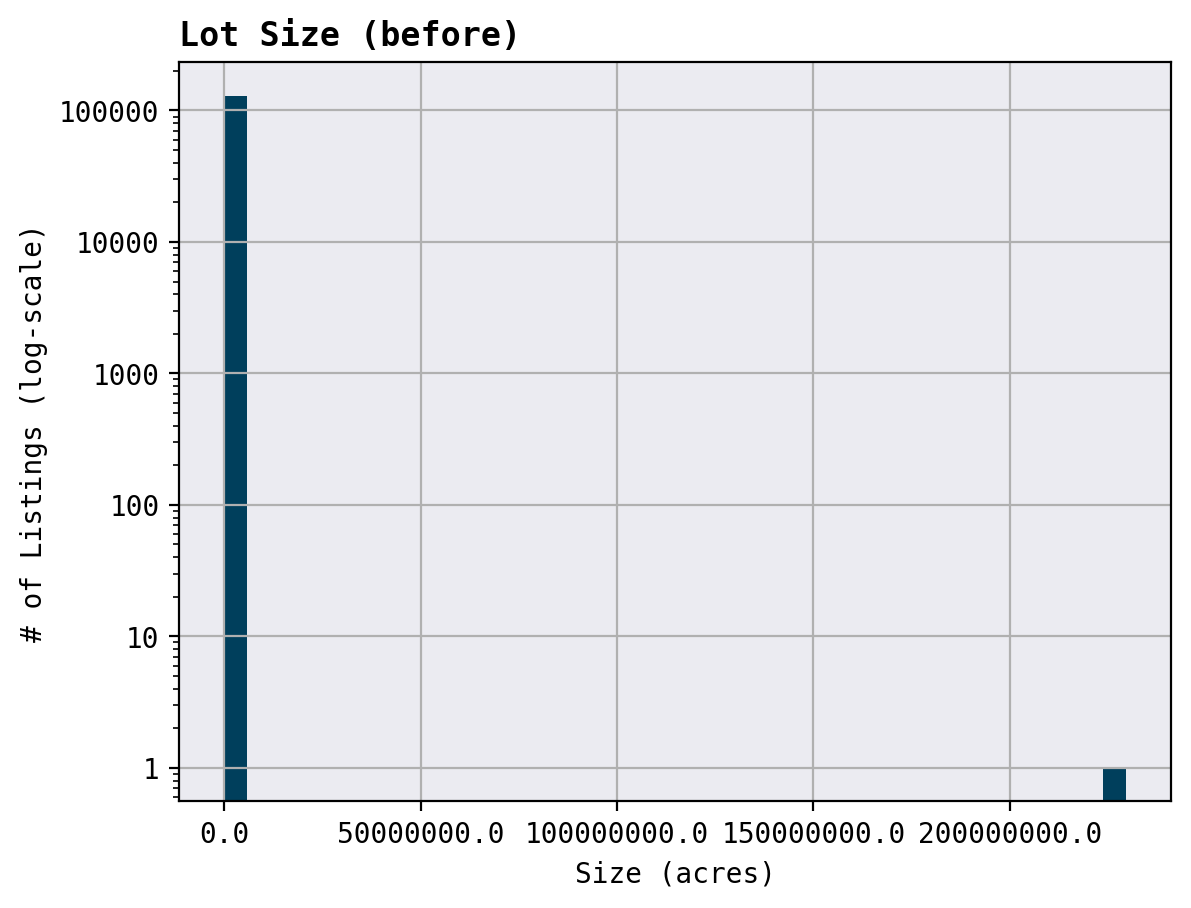

In [136]:
column='lotSize'
title='Lot Size (before)'
xlabel='Size (acres)'
ylabel='# of Listings (log-scale)'
log=True

histogram(column, title, xlabel, ylabel, log, df)

In [137]:
# These look like outliers or mistakes. Let's drop the records.
df[df['lotSize'] > 3e5]

,zillowId,homeStatus,streetAdress,city,state,zipcode,price,bedrooms,bathrooms,yearBuilt,zestimate,homeType,livingArea,hasGarage,parkingCapacity,sewer,hasHeating,fireplaces,hasWaterfrontView,isSeniorCommunity,levels,lotSize,hoaFee,buyersFeePerc,daysOnZillow,views,favorites,latitude,longitude,mainPhoto,brokerage,percSellFaster,propertyTax,mortgageRate,listingUserId,agentName,agentRating,agentRecentSales,agentReviewsCount,photosList,isForeclosure,isFSBO,isBankOwned,isZillowOwned,rentZestimate,totalActualRent,annual_house_insurance,price_history,description,hasPrivatePool,attic,similarHomes,termsCash,termsConventional,termsFHA,termsVA,schoolAverageDistance,schoolContainsCharter,schoolRatingElementary,schoolRatingMiddleSchool,schoolRatingHighSchool,hasPatioPorch
250360,196135401.0,FOR_SALE,28105 Perdido Beach Blvd UNIT C-516,Orange Beach,AL,36561.0,799000.0,2.0,2.0,2006.0,NaN,Condo,1682.0,False,0.0,sewer,True,0.0,True,False,1.0,229568411.0,$840 monthly,2.2,242.0,157.0,3.0,30.27928,-87.54626,https://photos.zillowstatic.com/fp/2a40cd0905e...,RE/MAX of Orange Beach,0.31,0.3,6.567,X1-ZUygzrc6tw9r0p_728x6,Deborah Hood,5.0,1.0,59.0,"[""https://photos.zillowstatic.com/fp/2a40cd090...",False,False,False,False,NaN,NaN,3355.8,"[[""2023-12-31"", 799000], [""2023-08-28"", 807500...","NEW PRICE, GREAT VIEWS, GREAT RENTALS AND MOTI...",NaN,NaN,"[196131641, 196047784, 196123371, 2115670209, ...",False,False,False,False,5.733333,False,NaN,NaN,NaN,False


In [138]:
# Drop records.
df = df[df['lotSize'] <= 3e5]

<ipython-input-6-e8e7d24ab219>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([round(float(x),1) for x in plt.gca().get_xticks()])


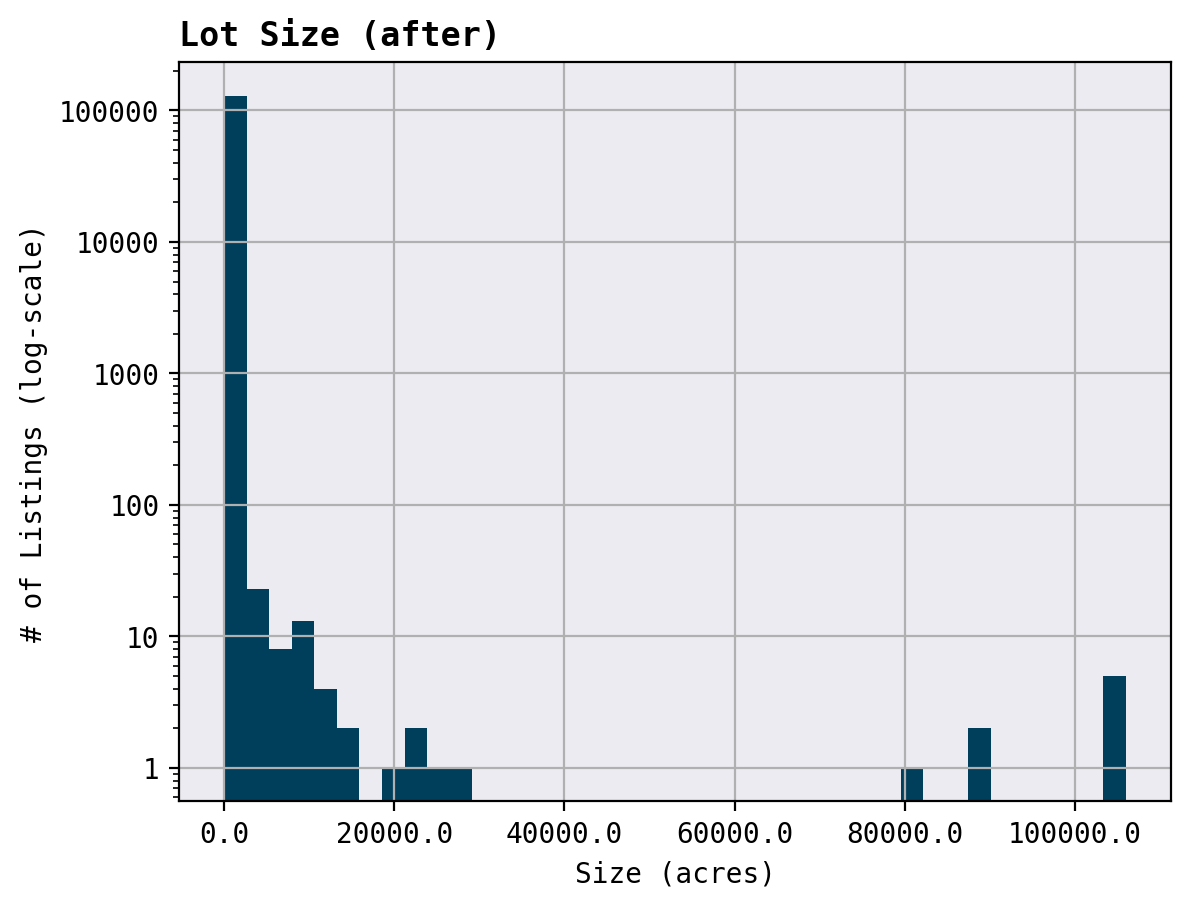

In [139]:
column='lotSize'
title='Lot Size (after)'
xlabel='Size (acres)'
ylabel='# of Listings (log-scale)'
log=True

histogram(column, title, xlabel, ylabel, log, df)

### hoaFee

<div class="alert alert-block alert-info"><b>Definition: </b>hoaFee is the price a home owners association charges annually.</div>

This one is in pretty messy shape. I'll convert the values to an annual representation, assuming nulls have no hoa. There are few homes with insanely high hoas -- we'll use a heuristic to bring those values down.

In [140]:
# Quick groupby.
groupit('hoaFee',df=df)

hoaFee
$300 annually       932
$500 annually       873
$400 annually       746
$600 annually       743
$250 annually       684
                   ... 
$4,752 annually       1
$4,728 annually       1
$4,713 quarterly      1
$4,696 annually       1
$4,327 monthly        1
Length: 4075, dtype: int64


In [141]:
# a lot of null values.
nullcheck('hoaFee', df=df)

hoaFee
Nulls: 83354


In [142]:
# Empty dictionary.
dictionary = {}

# Check for the values that currently show up in this column for payment terms.
for i, row in df.iterrows():
    try:
        term = row['hoaFee'].split(' ')[1]
        if term in dictionary.keys():
            dictionary[term] += 1
        else:
            dictionary[term] = 1
    except:
        pass
        
dictionary

{'annually': 19030,
 'monthly': 22345,
 'see': 13,
 'quarterly': 3465,
 'semi-annually': 819,
 'HOA': 72,
 'bi-monthly': 4,
 'month': 15,
 'bi-annually': 1,
 'other': 7,
 'one': 8,
 'semi': 1,
 'yearly': 78,
 'optional': 6,
 'none': 2,
 'not': 6,
 'semi-monthly': 1,
 'unknown': 2}

In [143]:
"""
clean_hoa

Clean the home owners fee data by converting payments into annual amounts. If null or
function fails, return 0.

    Args:
        x: The value in the column `hoa`.
    
    Returns:
        A transformed amount that represents the annual hoa. If there is just a
        numeric value, I assume it is already annual. If it is null, I assume
        there is no hoa. If the function fails, I default to no hoa.
"""


def clean_hoa(x):
    try:
        # if it is already just an integer, assume it is the annual amount.
        if x.isnumeric():
            return x
        elif isinstance(x, float):
            return 0
        else:
            # if not, try and split up the amount
            amount, term = x.split(' ')[0], x.split(' ')[1]
            amount = int(amount.replace('$','').replace(',',''))
            
            if term == 'monthly':
                return amount * 12
            elif term in ['annually','yearly']:
                return amount
            elif term == 'quarterly':
                return amount * 4
            elif term in ['semi-annually','semi']:
                return amount * 2
            elif term == 'month':
                return amount * 12
            elif term == 'semi-monthly':
                return amount * 24
            elif term == 'bi-annually':
                return amount / 2
            elif term == 'bi-monthly':
                return amount / 6
            else:
                return amount
    except:
        return 0    

In [144]:
# Apply function.
df['hoaFee'] = df['hoaFee'].apply(clean_hoa)

In [145]:
# Quick group by.
groupit('hoaFee',df=df)

hoaFee
0.0       83451
600.0      1339
300.0      1179
500.0       924
400.0       845
          ...  
1148.0        1
1154.0        1
1155.0        1
8300.0        1
654.0         1
Length: 3088, dtype: int64


<ipython-input-6-e8e7d24ab219>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([round(float(x),1) for x in plt.gca().get_xticks()])


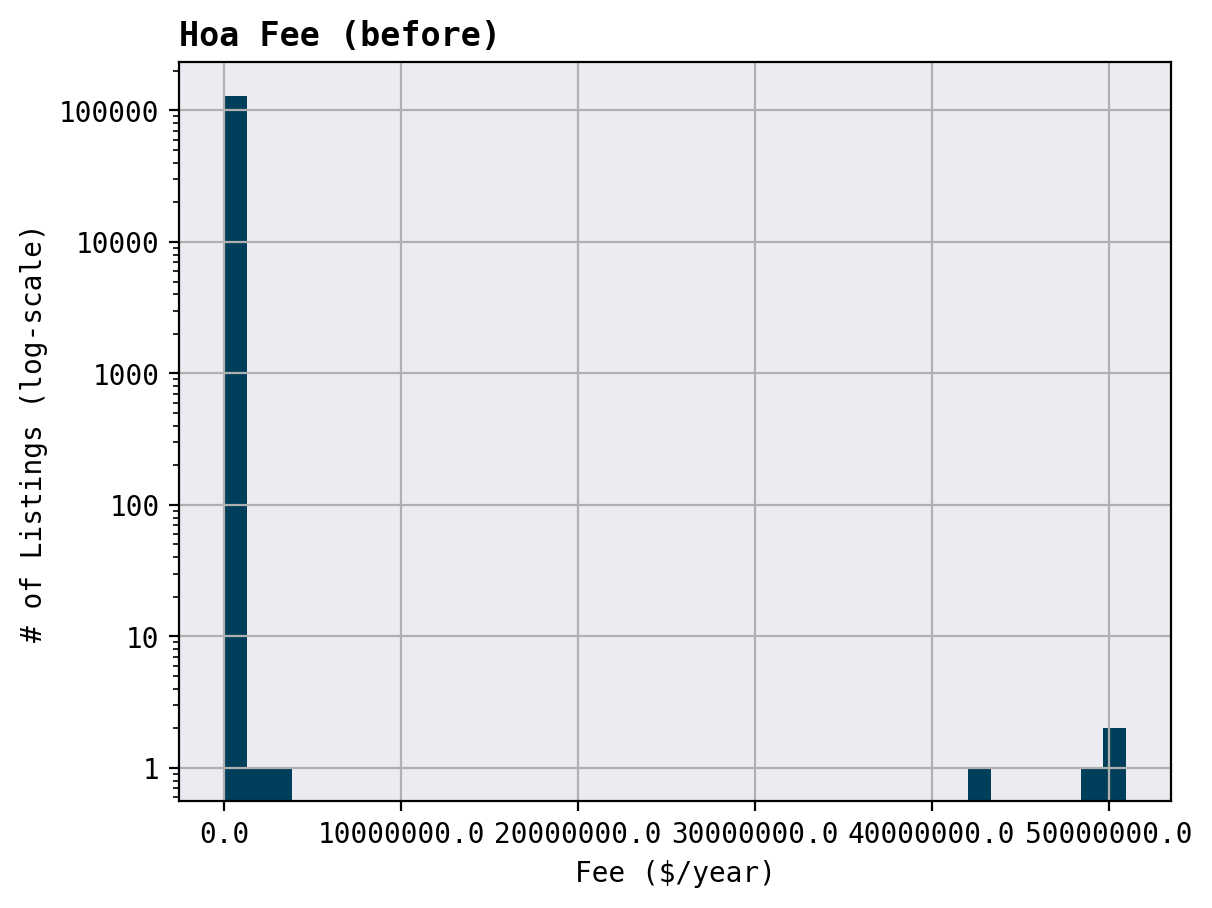

In [146]:
column='hoaFee'
title='Hoa Fee (before)'
xlabel='Fee ($/year)'
ylabel='# of Listings (log-scale)'
log=True

histogram(column, title, xlabel, ylabel, log, df)

In [147]:
# A handful of values seem to be really off.
df[df['hoaFee'] > 1e5][['zillowId','hoaFee','price']]

,zillowId,hoaFee,price
3945,2.055318e+09,3498384.0,6936000.0
38685,7.174956e+07,267900.0,1215000.0
55241,2.054092e+09,1056648.0,699990.0
62865,5.533834e+07,364212.0,419000.0
87286,7.075433e+07,1063200.0,649000.0
95790,1.196767e+08,223716.0,7760000.0
96345,2.395985e+08,728268.0,135000.0
106300,2.062407e+09,49344288.0,340000.0
116185,2.402542e+08,111204.0,485000.0
116240,1.929995e+07,128844.0,1098000.0


In [148]:
# The average hoa is .3% of the price. Let's apply that to homes that seem too high.
sample = df[df['hoaFee'] > 0]
sample['hoaFee'].sum() / sample['price'].sum()

0.009155811807072792

In [149]:
"""
hoa_average_ratio

apply the .3%~ of price transformation to hoa's above $10,000 annually.

    Args:
        x: the value in hoaFee.
        
    Returns:
        if x > 10,000, transform the value. Else, return the current value.
"""


def hoa_average_ratio(x):
    if x > 1e5:
        return x * 0.0033243358831335163
    else:
        return x

In [150]:
# Apply function.
df['hoaFee'] = df['hoaFee'].apply(hoa_average_ratio)

<ipython-input-6-e8e7d24ab219>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([round(float(x),1) for x in plt.gca().get_xticks()])


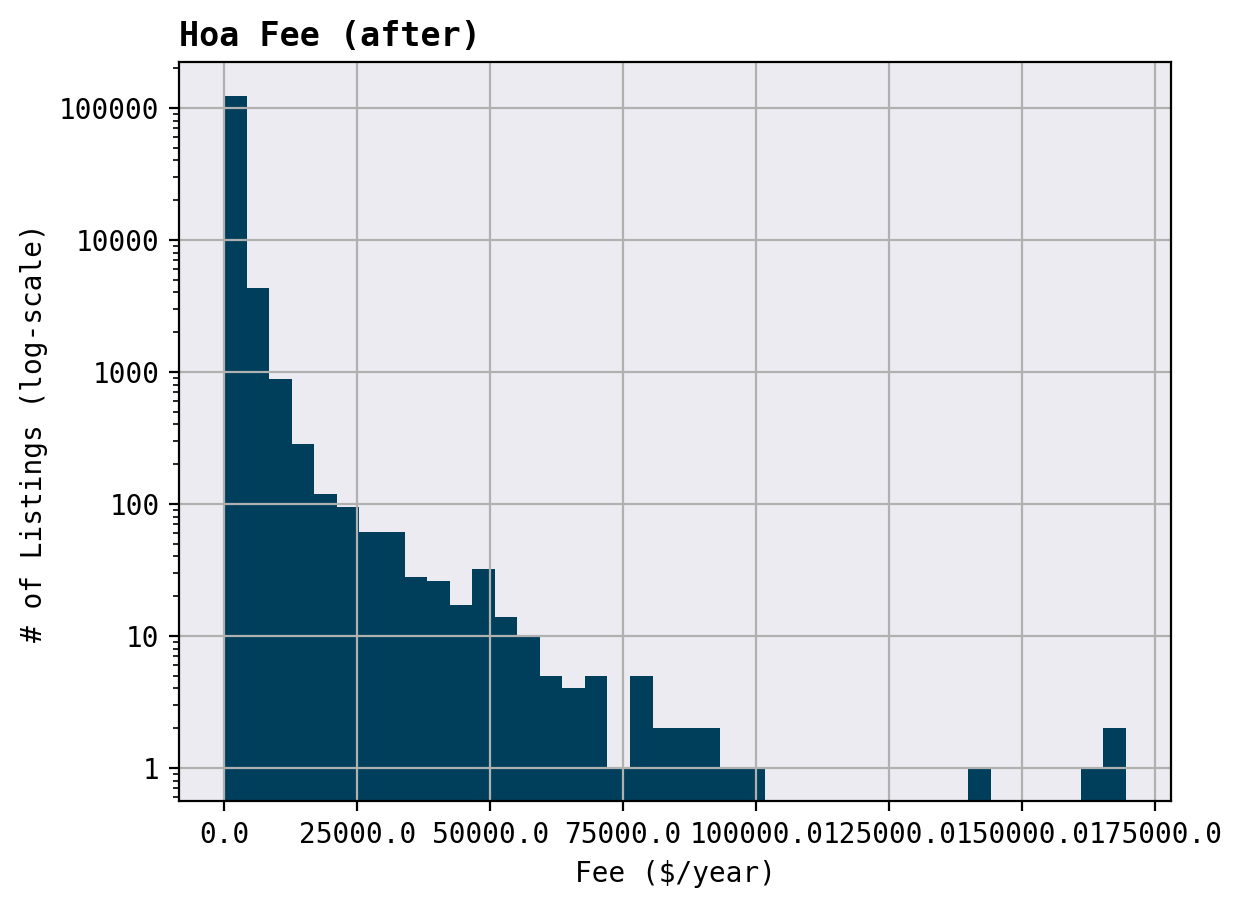

In [151]:
column='hoaFee'
title='Hoa Fee (after)'
xlabel='Fee ($/year)'
ylabel='# of Listings (log-scale)'
log=True

histogram(column, title, xlabel, ylabel, log, df)

### BuyersFeePerc

<div class="alert alert-block alert-info"><b>Definition: </b>BuyersFeePerc is the fee the buyer's agent will get.</div>

This one is another free text string that needs to me cleaned. I'll do the best that I can to pull out the true value. But, it might be necessary to just pick an average, common number for the ones I can't figure out programmatically.

In [152]:
# Quick group by.
groupit('buyersFeePerc',df=df)

buyersFeePerc
2.5                                         22074
3                                           19060
2                                            6386
3.00                                         2513
2.50                                         2368
                                            ...  
2.25% -250                                      1
2.25% -275.00                                   1
2.25% -350                                      1
2.25% 1ST MILLION/1.75% THEREAFTER -$495        1
 P3F2                                           1
Length: 2318, dtype: int64


In [153]:
"""
extract_percentage

Extract the percentage from the free text field.

    Args:
        x: the value in buyersFeePerc.
        
    Returns:
        If there is a number matching the pattern X%, I find that number and return it.
        If the number found is greater than 7%, I default it to the 2.5% (the most common
        value in the dataset). If the value is already a float or an int, I return that
        number as is.
"""

def extract_percentage(x):
    
    # x is already float/int, skip.
    if isinstance(x,int) or isinstance(x,float):
        return x
    
    # else, try and pull out the value.
    else:
    
        # Match the first number with a % after it or just the first number
        match = re.search(r'(\d+)%', x)

        if match:
            # Extract the integer part from the matched string
            val = int(match.group(1))
            
            if val < 7:
                return val
            else:
                return 2.5 # if it is a weird #, just do 2.5 percent.
        else:
            return 2.5 # if it is a weird #, just do 2.5 percent.
        


In [154]:
# Apply function.
df['buyersFeePerc'] = df['buyersFeePerc'].apply(extract_percentage)

In [155]:
# Groupby to see new values.
groupit('buyersFeePerc',df=df)

buyersFeePerc
2.5    100967
5.0      1991
3.0      1531
2.0       552
0.0       279
4.0        48
1.0        20
6.0         1
dtype: int64


<ipython-input-6-e8e7d24ab219>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([round(float(x),1) for x in plt.gca().get_xticks()])


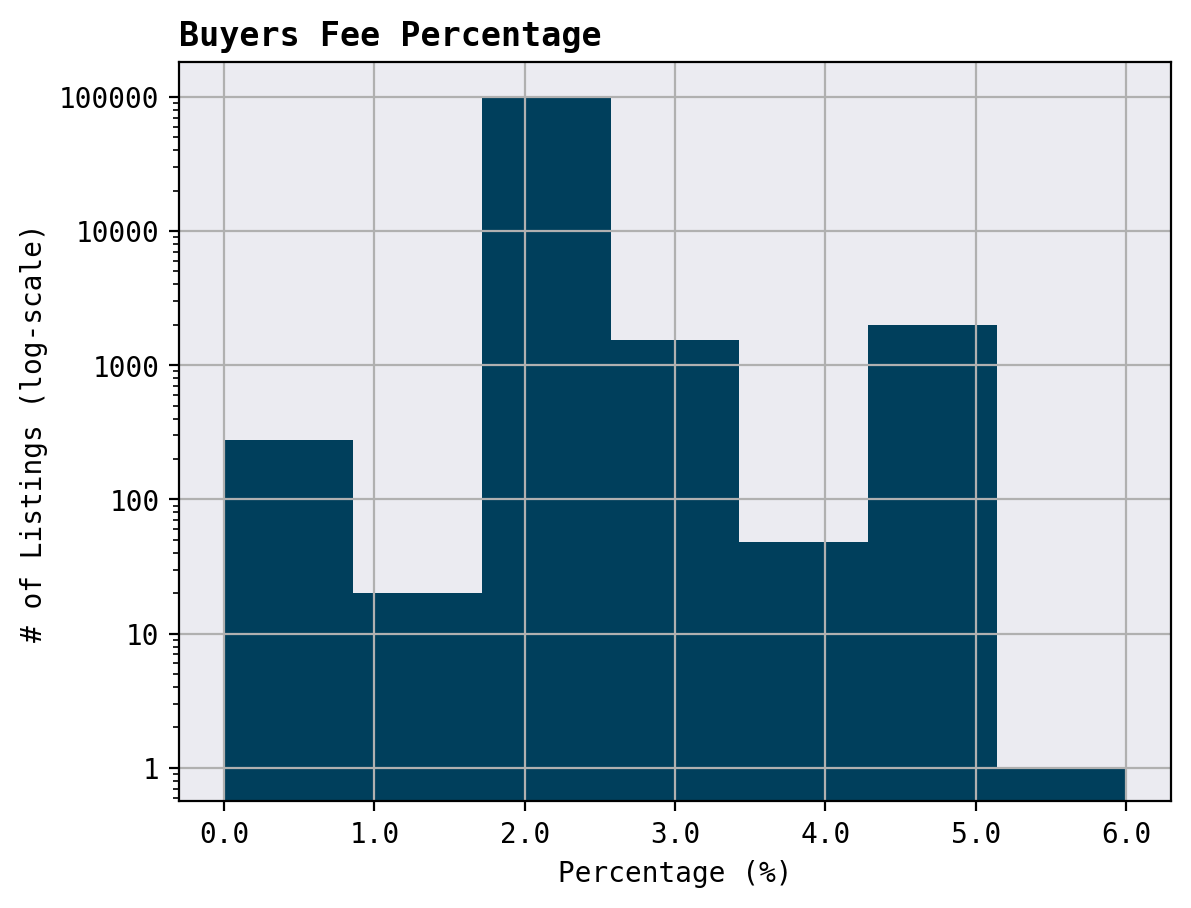

In [156]:
column='buyersFeePerc'
title='Buyers Fee Percentage'
xlabel='Percentage (%)'
ylabel='# of Listings (log-scale)'
log=True
bins=7

histogram(column, title, xlabel, ylabel, log, df, bins=bins)

### daysOnZillow

<div class="alert alert-block alert-info"><b>Definition: </b>daysOnZillow is the number of days the listing has been online.</div>

This one is in pretty good shape. There are a small number of nulls, I am going to go ahead and assume that nulls are 0s (that it is the first day on Zillow).

In [157]:
# Group by.
groupit('daysOnZillow',df=df)

daysOnZillow
17.0      1317
14.0      1263
22.0      1252
21.0      1213
23.0      1211
          ... 
842.0        1
844.0        1
847.0        1
848.0        1
4702.0       1
Length: 942, dtype: int64


In [158]:
# Null check
nullcheck('daysOnZillow',df=df)

daysOnZillow
Nulls: 1341


In [159]:
# Fill nulls with 0.
df['daysOnZillow'].fillna(0, inplace=True)

In [160]:
# Confirm nulls are filled.
nullcheck('daysOnZillow',df=df)

daysOnZillow
Nulls: 0


<ipython-input-6-e8e7d24ab219>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([round(float(x),1) for x in plt.gca().get_xticks()])


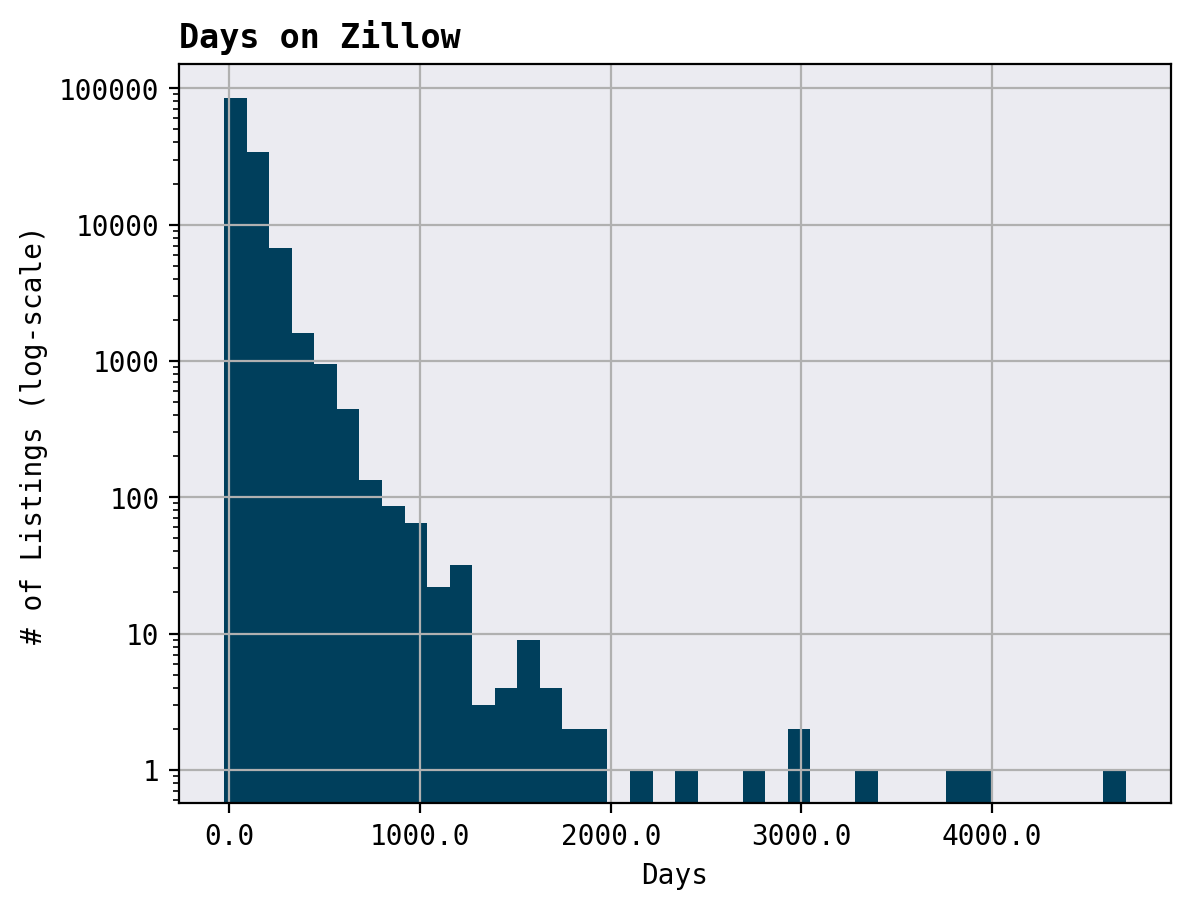

In [161]:
column='daysOnZillow'
title='Days on Zillow'
xlabel='Days'
ylabel='# of Listings (log-scale)'
log=True

histogram(column, title, xlabel, ylabel, log, df)

### views

<div class="alert alert-block alert-info"><b>Definition: </b>Views is the number of times the property has been viewed.</div>

This one is in pretty good shape. A handful of nulls -- I am going to assume nulls are zeros.

In [162]:
# Quick group by.
groupit('views',df=df)

views
130.0      171
71.0       165
215.0      162
49.0       162
133.0      161
          ... 
4658.0       1
4656.0       1
4655.0       1
4654.0       1
64320.0      1
Length: 5396, dtype: int64


In [163]:
# Check for nulls.
nullcheck('views',df=df)

views
Nulls: 44


In [164]:
# Fill nulls.
df['views'].fillna(0, inplace=True)

In [165]:
# Check this is fixed.
nullcheck('views',df=df)

views
Nulls: 0


<ipython-input-6-e8e7d24ab219>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([round(float(x),1) for x in plt.gca().get_xticks()])


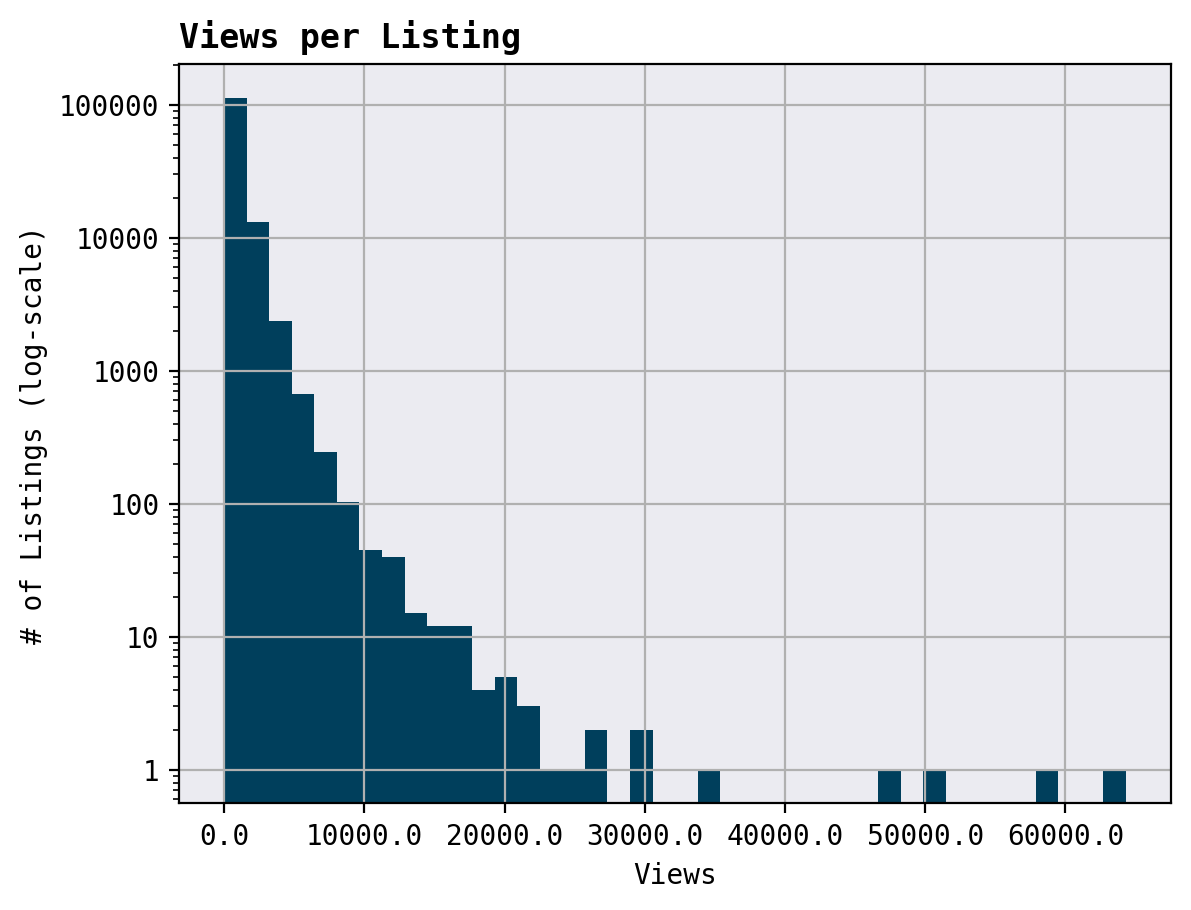

In [166]:
column='views'
title='Views per Listing'
xlabel='Views'
ylabel='# of Listings (log-scale)'
log=True

histogram(column, title, xlabel, ylabel, log, df)

### Favorites

<div class="alert alert-block alert-info"><b>Definition: </b>Favorites is the number of users who have saved the home.</div>

This one is in pretty good shape. Just a few nulls, I'll assume those are zeros.

In [167]:
# Quick groupby.
groupit('favorites',df=df)

favorites
4.0       3709
3.0       3636
2.0       3631
1.0       3580
5.0       3560
          ... 
574.0        1
577.0        1
578.0        1
580.0        1
3004.0       1
Length: 653, dtype: int64


In [168]:
# Quick null check.
nullcheck('favorites',df=df)

favorites
Nulls: 44


In [169]:
# Fill nulls with 0.
df['favorites'].fillna(0, inplace=True)

In [170]:
# Check that nulls are imputed.
nullcheck('favorites',df=df)

favorites
Nulls: 0


<ipython-input-6-e8e7d24ab219>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([round(float(x),1) for x in plt.gca().get_xticks()])


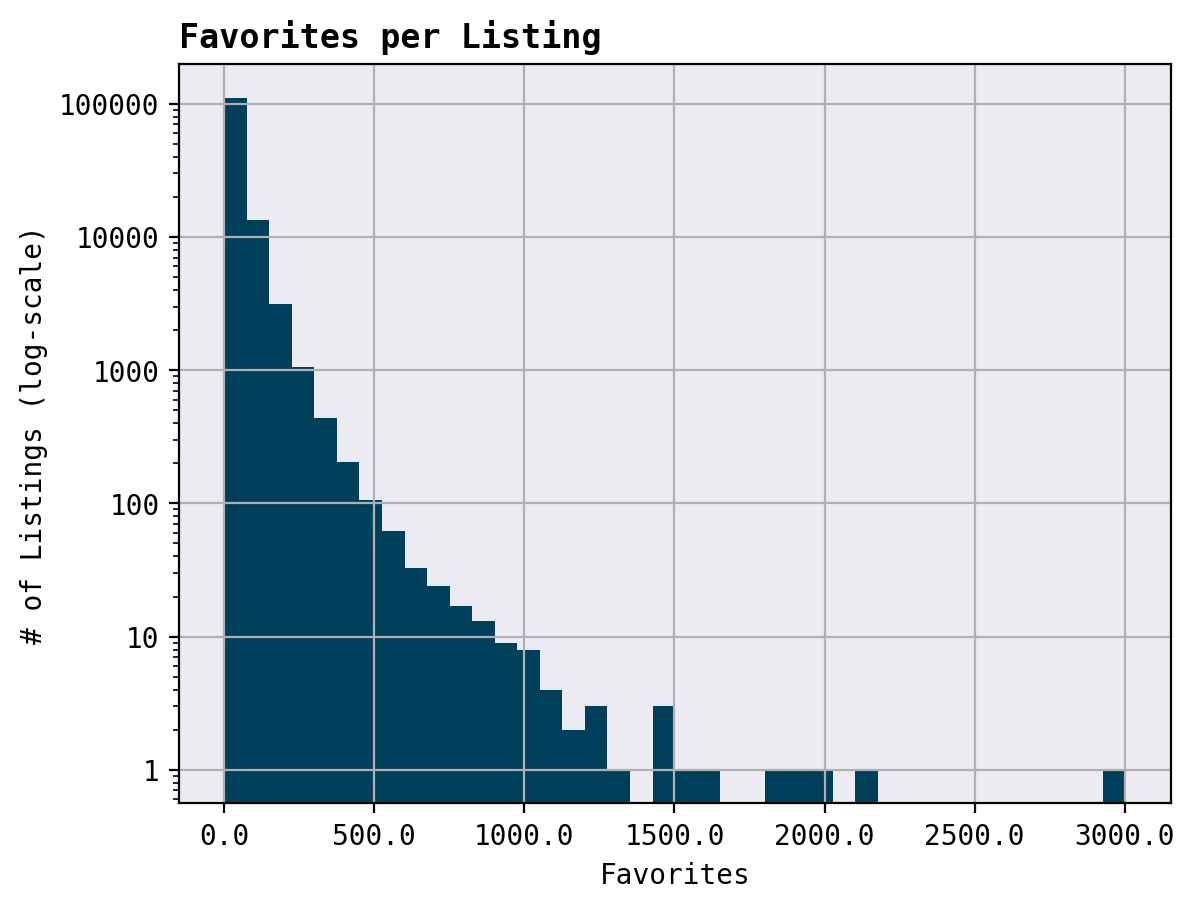

In [171]:
column='favorites'
title='Favorites per Listing'
xlabel='Favorites'
ylabel='# of Listings (log-scale)'
log=True

histogram(column, title, xlabel, ylabel, log, df)

### latitude

<div class="alert alert-block alert-info"><b>Definition: </b>latitude is the north-south coordinate of the home.</div>

Just a few nulls here. Drop them, and move on.

In [172]:
# Null check.
nullcheck('latitude',df=df)

latitude
Nulls: 262


In [173]:
# Drop nulls.
df = df[~df['latitude'].isnull()]

In [174]:
# Check nulls are dropped.
nullcheck('latitude',df=df)

latitude
Nulls: 0


### longitude

<div class="alert alert-block alert-info"><b>Definition: </b>longitude is the east-west coordinate of the home.</div>

Nothing to do here! This looks good after dropping the null latitude records.

In [175]:
nullcheck('longitude',df=df)

longitude
Nulls: 0


### MainPhoto

Do nothing with this.

### brokerage

<div class="alert alert-block alert-info"><b>Definition: </b>Brokerage is the company selling the home.</div>

This data looks fine / there isn't really a way for me to audit it. I'll just drop the <10 records that are null.

In [176]:
# Quick group by.
groupit('brokerage',df=df)

brokerage
Coldwell Banker Realty          1766
Keller Williams Realty          1040
Compass                          919
eXp Realty                       858
eXp Realty, LLC                  660
                                ... 
Dunbar Real Estate Inc.            1
Nichols Hills Properties LLC       1
Dunagan Associates                 1
Dulith Wijewardene                 1
xr realty                          1
Length: 31562, dtype: int64


In [177]:
# Quick null check.
nullcheck('brokerage',df=df)

brokerage
Nulls: 1


In [178]:
# Drop nulls.
df = df[~df['brokerage'].isnull()]

In [179]:
# Quick null check post drops.
nullcheck('brokerage',df=df)

brokerage
Nulls: 0


### percSellFaster

<div class="alert alert-block alert-info"><b>Definition: </b>percSellFaster Is the percentage of nearby homes that will sell slower than this home.</div>

I think this is likely a garbage value (a high number of homes sell 99% faster than nearby homes). So I will just lazily impute from the distribution for nulls. If this turns out to have some sort of predictive value, I may reconsider my imputing method.

In [180]:
# Quick groupby.
groupit('percSellFaster',df=df)

percSellFaster
0.99    3609
0.98    2166
0.97    2088
0.96    2062
0.94    2024
        ... 
0.03     425
0.04     415
0.02     410
0.01     369
0.00     282
Length: 100, dtype: int64


In [181]:
# Check for nulls.
nullcheck('percSellFaster',df=df)

percSellFaster
Nulls: 8350


In [182]:
"""
fillNullWithDistribution.

Randomly probabilistically fill in the values for the rest since there are few nulls.

    Args:
        column_series: a pandas series.
        
    Returns:
        The pandas series, with the nulls imputed from the distribution of values in the dataset.
"""
def fillNullWithDistribution(column_series):
    # Drop null values from the column
    non_null_values = column_series.dropna()

    # Calculate the probabilities for each unique value in the column
    probabilities = non_null_values.value_counts(normalize=True)

    # Generate random indices based on the probabilities
    random_indices = np.random.choice(probabilities.index, size=column_series.isnull().sum(), p=probabilities)

    # Fill null values with the randomly sampled values
    filled_column = column_series.copy()
    filled_column[column_series.isnull()] = random_indices

    return filled_column

In [183]:
# Apply imputing method.
df['percSellFaster'] = fillNullWithDistribution(column_series=df['percSellFaster'])

In [184]:
# Confirm nulls are removed.
nullcheck('percSellFaster',df=df)

percSellFaster
Nulls: 0


<ipython-input-6-e8e7d24ab219>:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([round(float(x)*100,1) for x in plt.gca().get_xticks()])


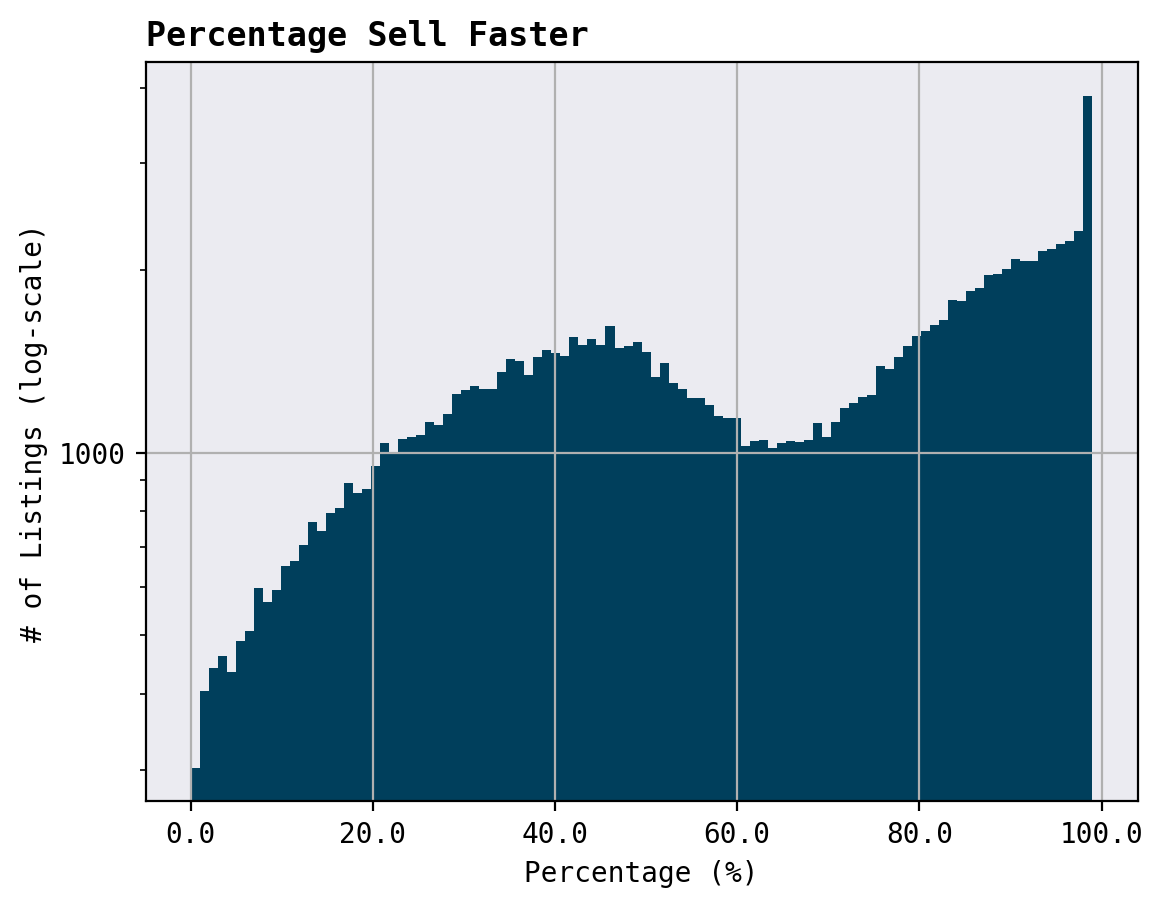

In [185]:
column='percSellFaster'
title='Percentage Sell Faster'
xlabel='Percentage (%)'
ylabel='# of Listings (log-scale)'
log=True
bins=100
xtickformat='Percentage Conversion'

histogram(column, title, xlabel, ylabel, log, df, xtickformat=xtickformat, bins=bins)

### Property Tax

<div class="alert alert-block alert-info"><b>Definition: </b>PropertyTax is the percentage of the home's value that the owner will pay.</div>

This one looks pretty good -- just a few nulls. We'll drop those records.

In [186]:
# Quick group by.
groupit('propertyTax',df=df)

propertyTax
1.17    3191
0.92    2779
0.50    2727
0.84    2248
0.74    2150
        ... 
0.20       2
3.89       2
2.72       1
0.23       1
2.15       1
Length: 244, dtype: int64


In [187]:
# Null check.
nullcheck('propertyTax',df=df)

propertyTax
Nulls: 5


In [188]:
# Drop nulls.
df = df[~df['propertyTax'].isnull()]

In [189]:
# Check nulls are handled.
nullcheck('propertyTax',df=df)

propertyTax
Nulls: 0


<ipython-input-6-e8e7d24ab219>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([round(float(x),1) for x in plt.gca().get_xticks()])


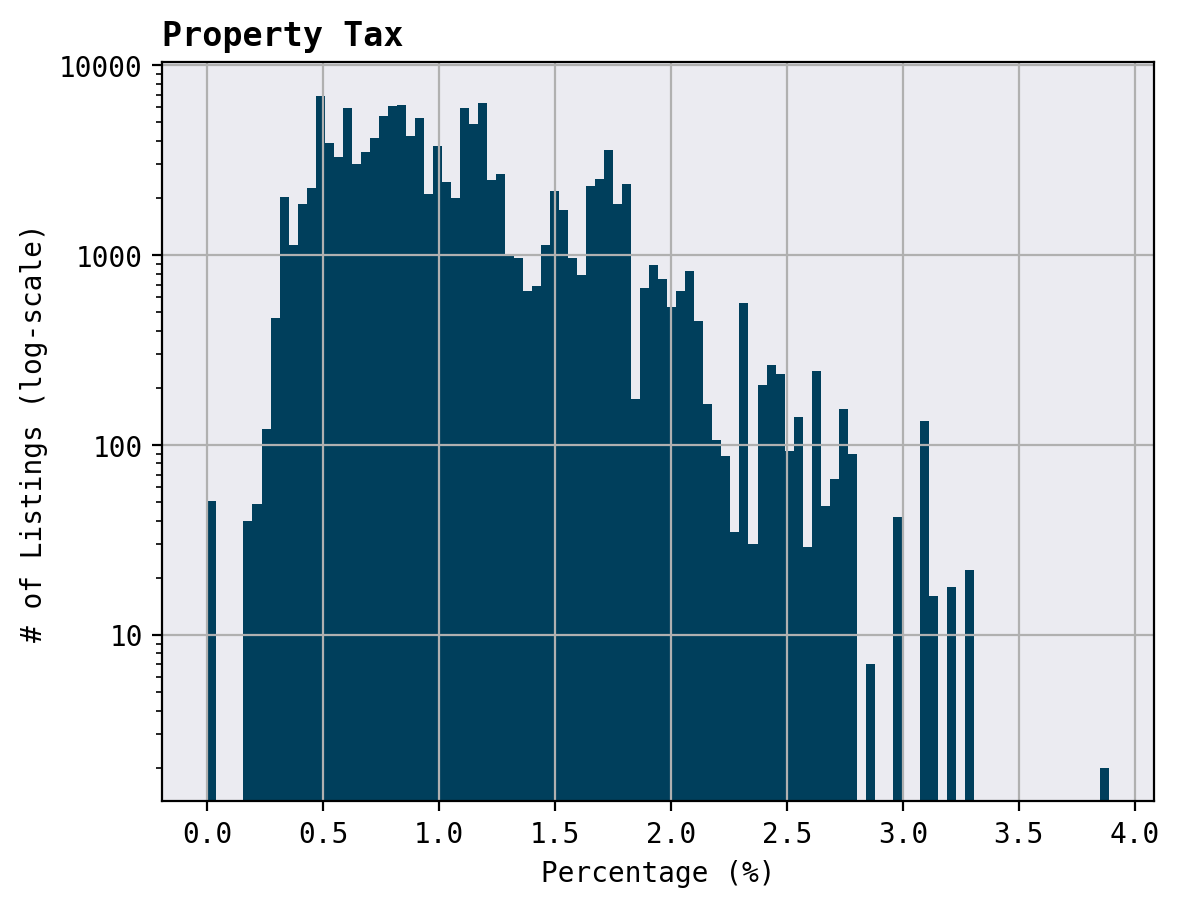

In [190]:
column='propertyTax'
title='Property Tax'
xlabel='Percentage (%)'
ylabel='# of Listings (log-scale)'
log=True
bins=100

histogram(column, title, xlabel, ylabel, log, df, bins=bins)

### mortgageRate

<div class="alert alert-block alert-info"><b>Definition: </b>mortgageRate Is the interest on the morgage for the home.</div>

I think this is less an attribute of the home and more an attribute of the market. So I'm going to impute from the distribution.

In [191]:
# Quick group by.
groupit('mortgageRate',df=df)

mortgageRate
5.902    12153
5.991     4514
6.567     3266
6.621     1967
6.651     1722
         ...  
6.625        5
6.533        5
6.260        1
6.268        1
6.638        1
Length: 258, dtype: int64


In [192]:
# Quick null check.
nullcheck('mortgageRate',df=df)

mortgageRate
Nulls: 9789


In [193]:
# Impute from distribution.
df['mortgageRate'] = fillNullWithDistribution(column_series=df['mortgageRate'])

In [194]:
# Check nulls are handled.
nullcheck('mortgageRate',df=df)

mortgageRate
Nulls: 0


<ipython-input-6-e8e7d24ab219>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([round(float(x),1) for x in plt.gca().get_xticks()])


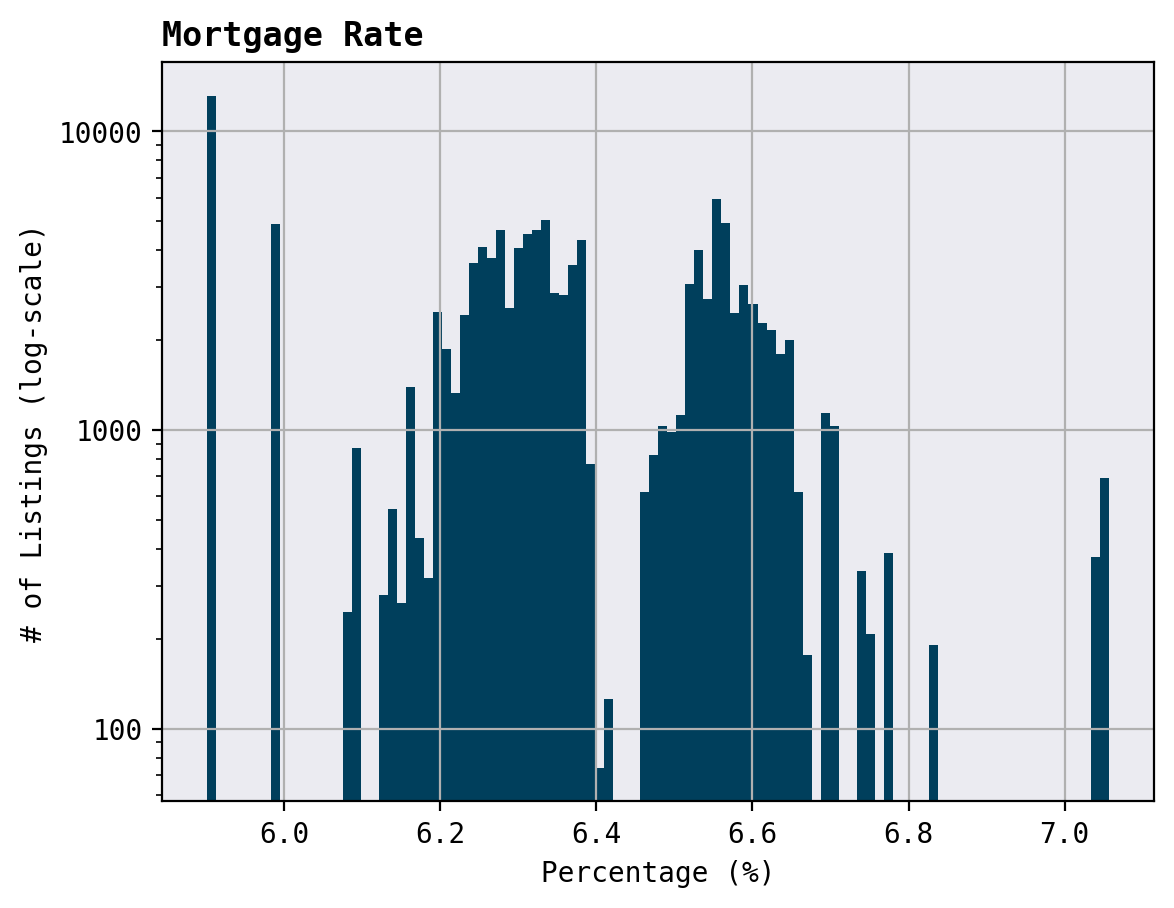

In [195]:
column='mortgageRate'
title='Mortgage Rate'
xlabel='Percentage (%)'
ylabel='# of Listings (log-scale)'
log=True
bins=100

histogram(column, title, xlabel, ylabel, log, df, bins=bins)

### listingUserId

<div class="alert alert-block alert-info"><b>Definition: </b>listingUserId is Zillow User ID that listed the property.</div>


do nothing. Nothing to change about this data.

### agentName

<div class="alert alert-block alert-info"><b>Definition: </b>agentName is the name of the agent.</div>


Do nothing. Nothing I can really validate about this data.

### agentRecentSales

<div class="alert alert-block alert-info"><b>Definition: </b>agentRecentSales Is how many sales an agent has sold recently.</div>

I don't think this data will be super useful for prediction, but I'll clean it up anyways. If it is null, I assume the value is 0.

In [196]:
# Quick null check.
nullcheck('agentRecentSales',df=df)

agentRecentSales
Nulls: 8528


In [197]:
# Fill nulls.
df['agentRecentSales'].fillna(0, inplace=True)

In [198]:
# Check nulls are removed.
nullcheck('agentRecentSales',df=df)

agentRecentSales
Nulls: 0


<ipython-input-6-e8e7d24ab219>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([round(float(x),1) for x in plt.gca().get_xticks()])


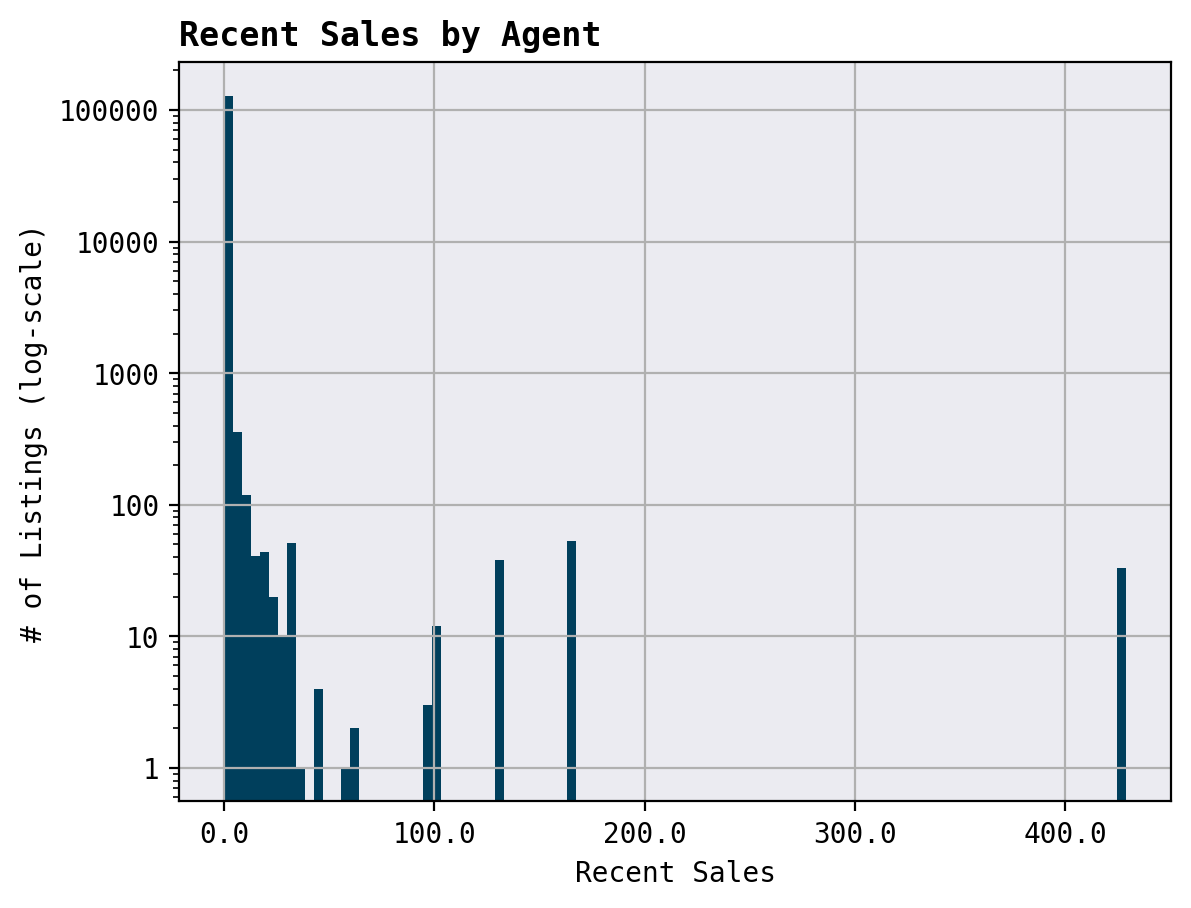

In [199]:
column='agentRecentSales'
title='Recent Sales by Agent'
xlabel='Recent Sales'
ylabel='# of Listings (log-scale)'
log=True
bins=100

histogram(column, title, xlabel, ylabel, log, df, bins=bins)

### agentRating

<div class="alert alert-block alert-info"><b>Definition: </b>agentRating Is the average 5-star rating of the agent.</div>


Do nothing. This data is in good shape. We don't want to impute values for nulls.

<ipython-input-6-e8e7d24ab219>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([round(float(x),1) for x in plt.gca().get_xticks()])


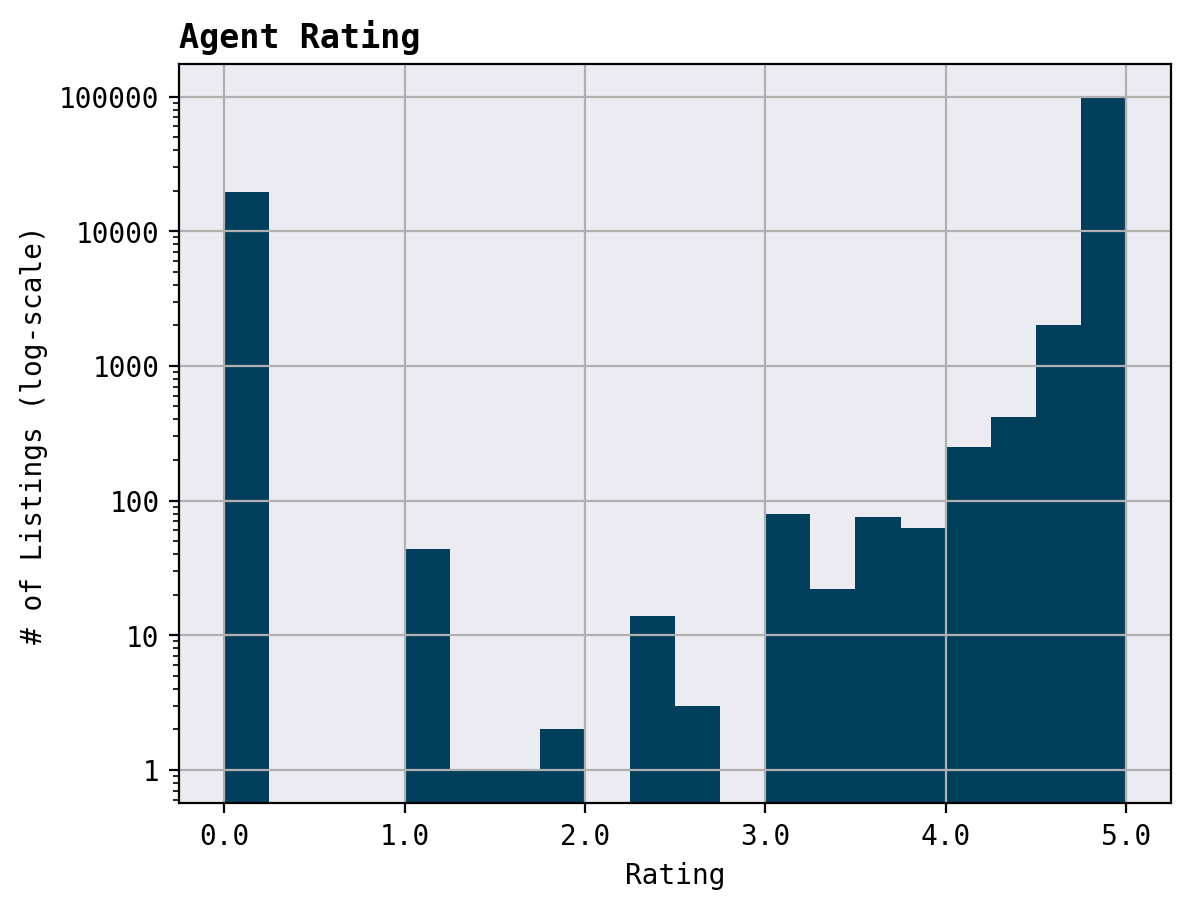

In [200]:
plt.show()

column='agentRating'
title='Agent Rating'
xlabel='Rating'
ylabel='# of Listings (log-scale)'
log=True
bins=20

histogram(column, title, xlabel, ylabel, log, df, bins=bins)

### agentReviewsCount

<div class="alert alert-block alert-info"><b>Definition: </b>agentReviewsCount Is the number of ratings an agent has.</div>

Nothing to do here but to impute the nulls with zero.

In [201]:
# Quick groupby.
groupit('agentReviewsCount',df=df)

agentReviewsCount
0.0      19634
1.0       4602
2.0       3454
4.0       2862
6.0       2686
         ...  
744.0        1
432.0        1
419.0        1
392.0        1
285.0        1
Length: 566, dtype: int64


In [202]:
# Quick null check.
nullcheck('agentReviewsCount',df=df)

agentReviewsCount
Nulls: 8528


In [203]:
# Fill nulls with zero.
df['agentReviewsCount'].fillna(0,inplace=True)

In [204]:
# Check nulls have been imputed.
nullcheck('agentReviewsCount',df=df)

agentReviewsCount
Nulls: 0


### photosList

<div class="alert alert-block alert-info"><b>Definition: </b>photosList Is a list of urls to photos related to the listing.</div>


Do nothing. This data doesn't need any treatment at this time.

### isForeclosure

<div class="alert alert-block alert-info"><b>Definition: </b>isForeclosure Is a True/False on whether or not the home is a foreclosure.</div>

Do nothing. This data is good.

In [205]:
# Quick group by.
groupit('isForeclosure',df=df)

isForeclosure
False    128110
True        851
dtype: int64


In [206]:
# Null check
nullcheck('isForeclosure',df=df)

isForeclosure
Nulls: 0


### isFSBO

<div class="alert alert-block alert-info"><b>Definition: </b>isFSBO Is a True/False on whether or not the home is for sell by owner.</div>


This column is all False. Drop it.

In [207]:
# Quick group by.
groupit('isFSBO',df=df)

isFSBO
False    128961
dtype: int64


In [208]:
# Quick null check.
nullcheck('isFSBO',df=df)

isFSBO
Nulls: 0


In [209]:
# Drop column.
df.drop(columns=['isFSBO'],inplace=True)

### isBankOwned

<div class="alert alert-block alert-info"><b>Definition: </b>isForeclosure Is a True/False on whether or not the home is owned by the bank.</div>

Do nothing. This is good.

In [210]:
# Quick group by.
groupit('isBankOwned')

isBankOwned
False    264168
True        330
dtype: int64


In [211]:
# Quick null check.
nullcheck('isBankOwned')

isBankOwned
Nulls: 0


### isZillowOwned

<div class="alert alert-block alert-info"><b>Definition: </b>isZillowOwned Is a True/False on whether or not the home is owned by Zillow.</div>


This is all False. Drop it.

In [212]:
# Quick group by.
groupit('isZillowOwned',df=df)

isZillowOwned
False    128729
dtype: int64


In [213]:
# Some nulls.
nullcheck('isZillowOwned',df=df)

isZillowOwned
Nulls: 232


In [214]:
# Drop all
df.drop(columns=['isZillowOwned'],inplace=True)

### rentZestimate

<div class="alert alert-block alert-info"><b>Definition: </b>rentZestimate Is Zillow's prediction of what the house would rent for.</div>


Do nothing. This is interesting data to have, and we don't have any way of imputing or mimicing Zillow's methods.

In [215]:
# Quick group by.
groupit('rentZestimate',df=df)

rentZestimate
2500.0      1309
1999.0      1167
2199.0      1100
1800.0       999
1500.0       977
            ... 
9191.0         1
9187.0         1
9183.0         1
9181.0         1
549062.0       1
Length: 11020, dtype: int64


In [216]:
# Null check.
nullcheck('rentZestimate',df=df)

rentZestimate
Nulls: 31418


<ipython-input-6-e8e7d24ab219>:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([str(int(x/1000)) + 'K' for x in plt.gca().get_xticks()])


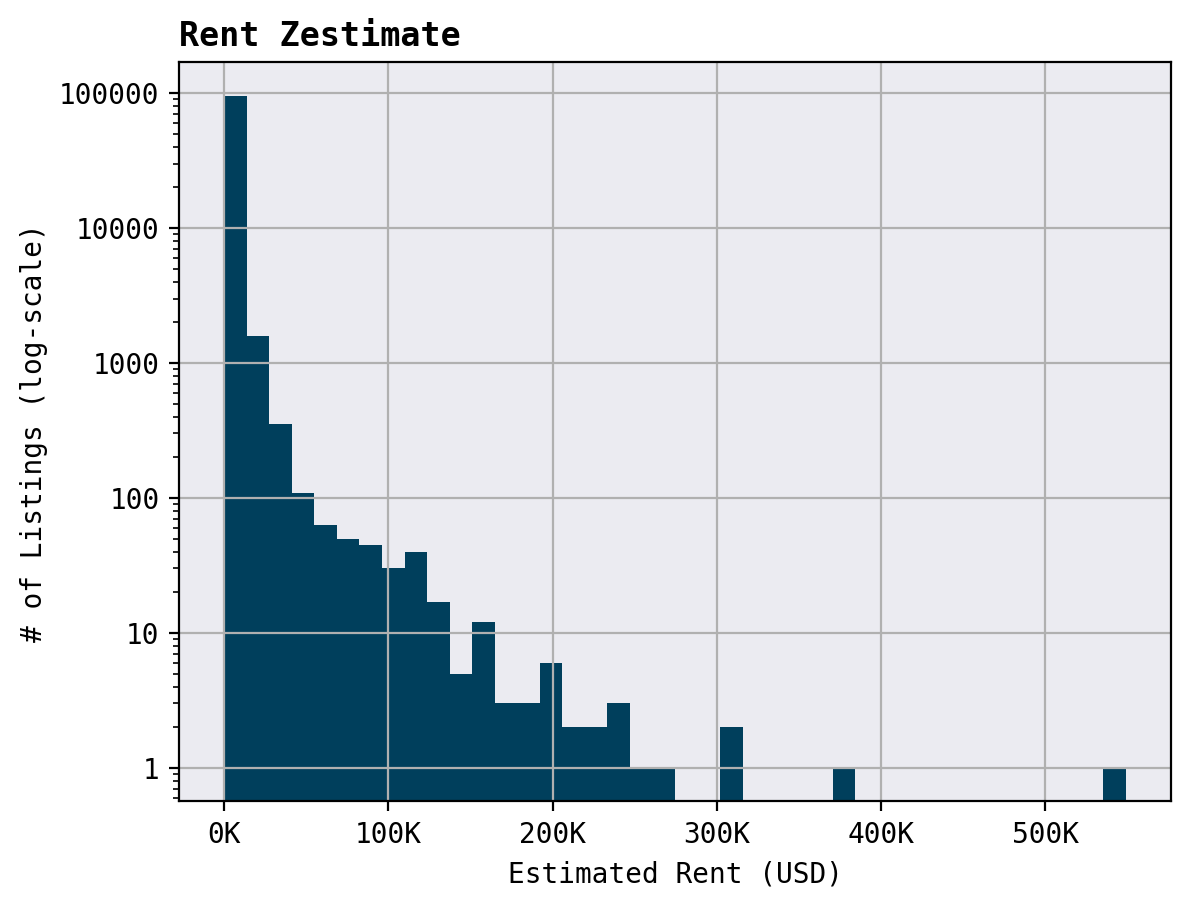

In [217]:
column='rentZestimate'
title='Rent Zestimate'
xlabel='Estimated Rent (USD)'
ylabel='# of Listings (log-scale)'
log=True
xtickformat='USD Thousands'

histogram(column, title, xlabel, ylabel, log, df, xtickformat=xtickformat)

### totalActualRent

<div class="alert alert-block alert-info"><b>Definition: </b>totalActualRent is the amoount of rent the place currently makes.</div>

A couple of outliers to drop, but otherwise I'll just impute the nulls with zero and move on.

In [218]:
# Quick groupby.
groupit('totalActualRent',df=df)

totalActualRent
0.0           7744
1500.0          16
1.0             16
2000.0          15
2400.0          12
              ... 
6060.0           1
6050.0           1
6045.0           1
1463.0           1
10000939.0       1
Length: 513, dtype: int64


In [219]:
# Quick null check.
nullcheck('totalActualRent',df=df)

totalActualRent
Nulls: 120268


In [220]:
# Impute nulls with zero.
df['totalActualRent'].fillna(0, inplace=True)

<ipython-input-6-e8e7d24ab219>:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([str(int(x/1000)) + 'K' for x in plt.gca().get_xticks()])


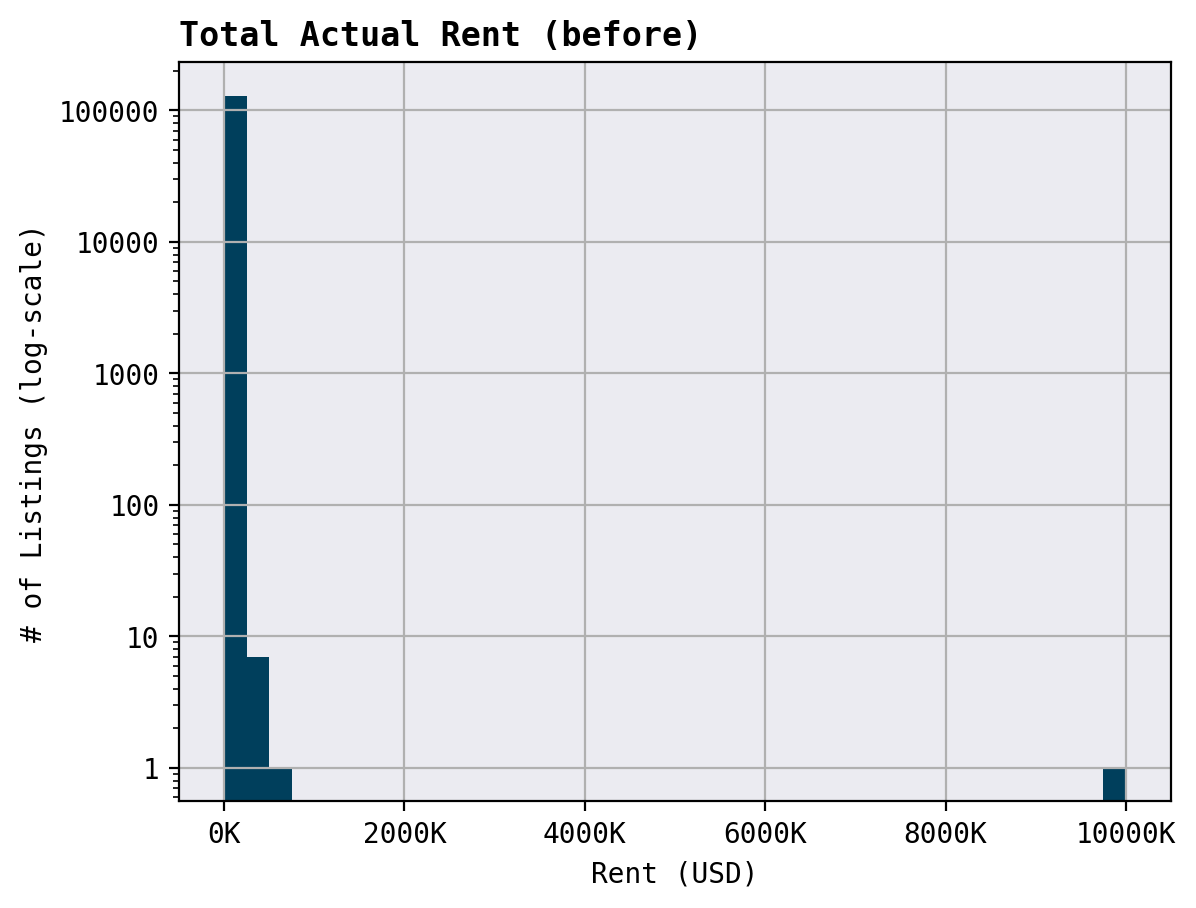

In [221]:
column='totalActualRent'
title='Total Actual Rent (before)'
xlabel='Rent (USD)'
ylabel='# of Listings (log-scale)'
log=True
xtickformat='USD Thousands'

histogram(column, title, xlabel, ylabel, log, df, xtickformat=xtickformat)

In [222]:
# There is a listing that put its price as its rent. This is a user error. Drop the record.
df[df['totalActualRent'] > 1e7]

,zillowId,homeStatus,streetAdress,city,state,zipcode,price,bedrooms,bathrooms,yearBuilt,zestimate,homeType,livingArea,hasGarage,parkingCapacity,sewer,hasHeating,fireplaces,hasWaterfrontView,isSeniorCommunity,levels,lotSize,hoaFee,buyersFeePerc,daysOnZillow,views,favorites,latitude,longitude,mainPhoto,brokerage,percSellFaster,propertyTax,mortgageRate,listingUserId,agentName,agentRating,agentRecentSales,agentReviewsCount,photosList,isForeclosure,isBankOwned,rentZestimate,totalActualRent,annual_house_insurance,price_history,description,hasPrivatePool,attic,similarHomes,termsCash,termsConventional,termsFHA,termsVA,schoolAverageDistance,schoolContainsCharter,schoolRatingElementary,schoolRatingMiddleSchool,schoolRatingHighSchool,hasPatioPorch
1346,15169439.0,FOR_SALE,4487 Mission St #4489,San Francisco,CA,94112,1150000.0,2.0,0.0,1906.0,1081600.0,MultiFamily,2900.0,False,0.0,sewer,False,0.0,False,False,2.0,0.047888,0.0,NaN,311.0,269.0,3.0,37.726337,-122.43321,https://photos.zillowstatic.com/fp/3a1c50d90b5...,Tran Real Estate,0.41,1.19,6.597,X1-ZUzzb8viqdip6x_3qul1,Veronica Tran,5.0,0.0,28.0,"[""https://photos.zillowstatic.com/fp/3a1c50d90...",False,False,3194.0,10000939.0,4830.0,"[[""2023-09-14"", 1150000], [""2023-08-24"", null]...",Reduced! Motivated Seller. Property Needs Wo...,NaN,NaN,"[15166347, 15139196, 241587686, 15167857, 3328...",True,False,False,False,1.066667,False,9.0,4.0,8.0,False


In [223]:
# Drop record.
df = df[df['totalActualRent'] < 1e7]

<ipython-input-6-e8e7d24ab219>:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([str(int(x/1000)) + 'K' for x in plt.gca().get_xticks()])


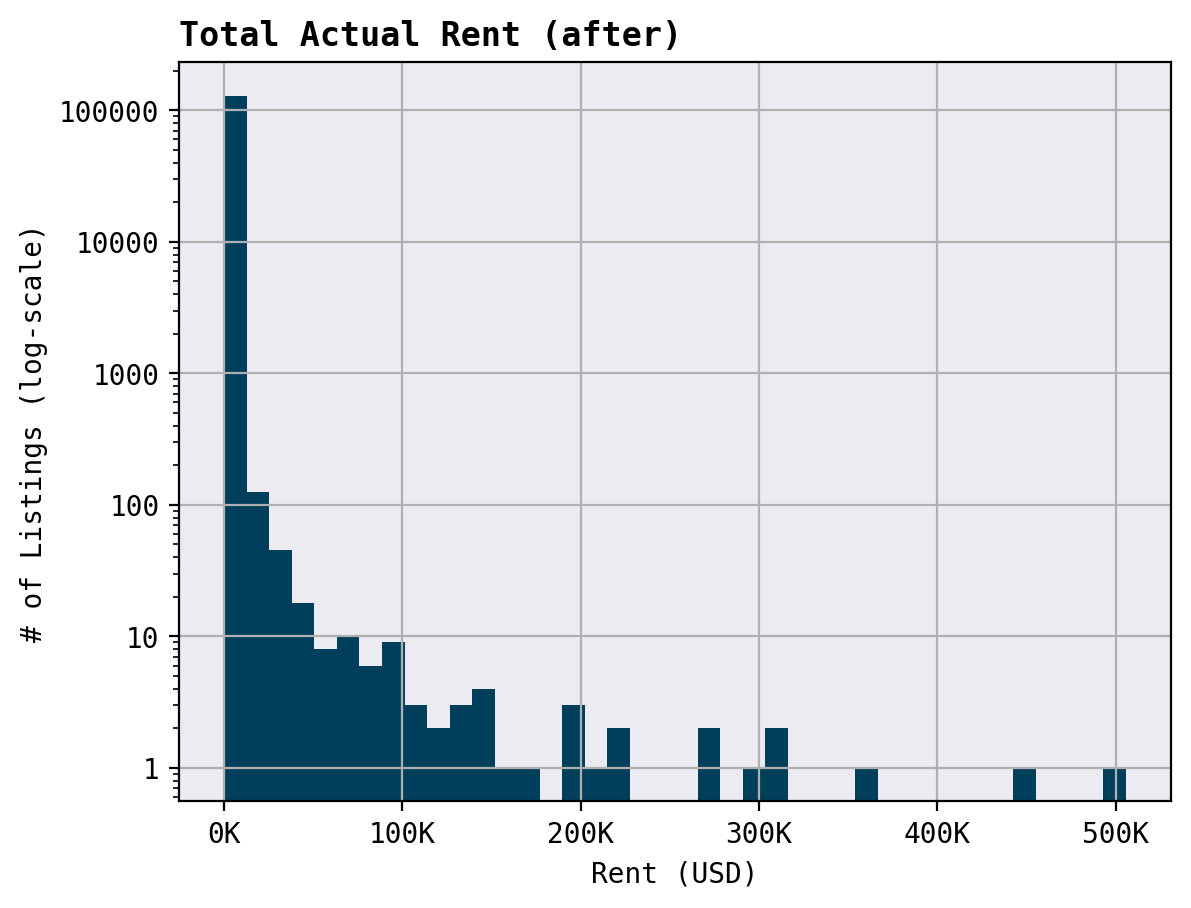

In [224]:
column='totalActualRent'
title='Total Actual Rent (after)'
xlabel='Rent (USD)'
ylabel='# of Listings (log-scale)'
log=True
xtickformat='USD Thousands'

histogram(column, title, xlabel, ylabel, log, df, xtickformat=xtickformat)

### annual_house_insurance

<div class="alert alert-block alert-info"><b>Definition: </b>annual_house_insurance is the annual cost of insuring the home.</div>

A few nulls here. I'll use a heuristic I found on bankrate.com to fill in the insurance estimate based on the home price.

Note: I found out later in the project that Zillow estimates this value based on the price. So this is a pretty big case of data leakage. This value will not be used in any of the models.

In [225]:
# Null check.
nullcheck('annual_house_insurance',df=df)

annual_house_insurance
Nulls: 7331


<ipython-input-6-e8e7d24ab219>:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([str(int(x/1000)) + 'K' for x in plt.gca().get_xticks()])


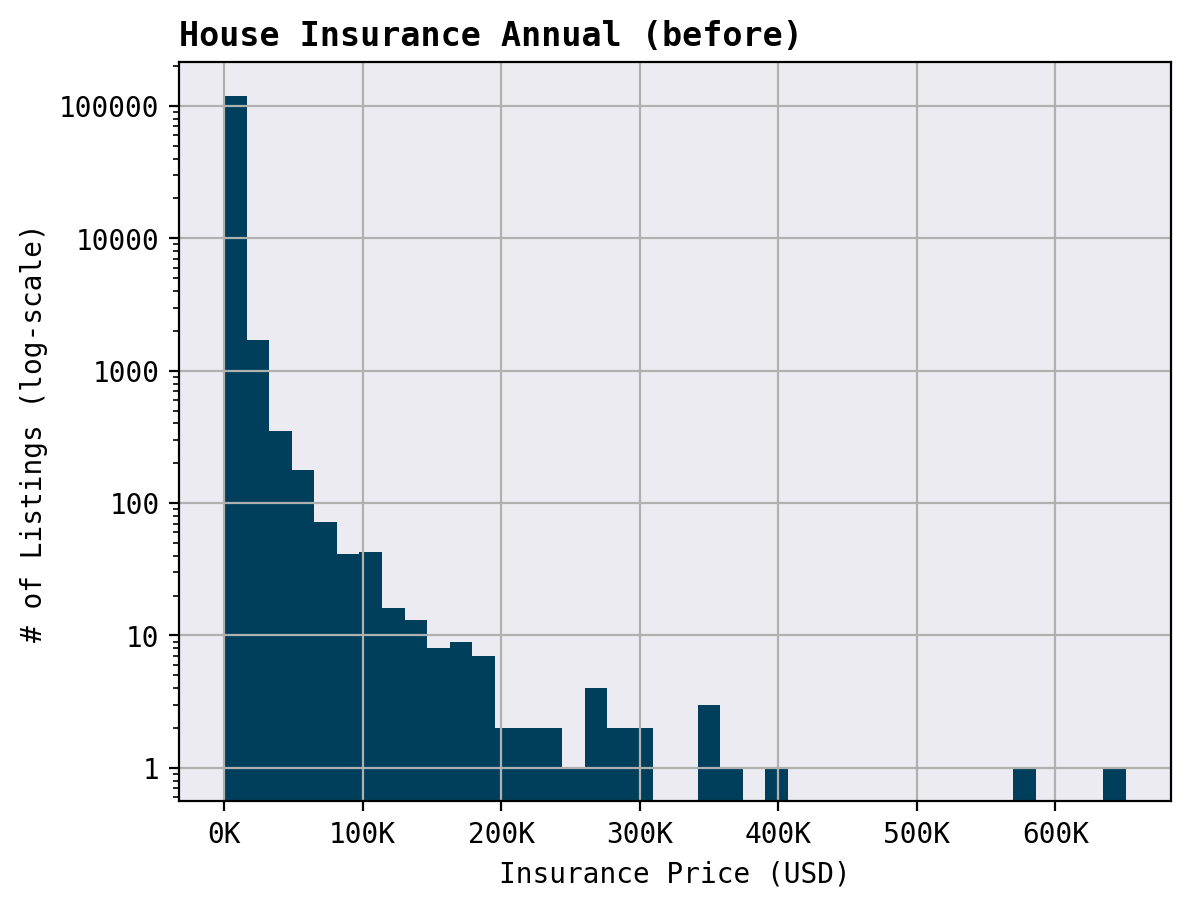

In [226]:
column='annual_house_insurance'
title='House Insurance Annual (before)'
xlabel='Insurance Price (USD)'
ylabel='# of Listings (log-scale)'
log=True
xtickformat='USD Thousands'

histogram(column, title, xlabel, ylabel, log, df, xtickformat=xtickformat)

In [227]:
# source for ratio: https://www.bankrate.com/insurance/homeowners-insurance/estimate-home-insurance/

# Empty list of values.
list_ = []

for i, row in df.iterrows():
    
    if not pd.isna(row['annual_house_insurance']):
        list_.append(row['annual_house_insurance'])
    else:
        # If null, transform the estimate based on the price.
        estimate = row['price'] / 175 # used to mimic a $1,500/yr average for $250K homes, assuming linear trend.
        list_.append(estimate)

# Save value to home.
df['annual_house_insurance'] = list_

In [228]:
# Check to see nulls have been handled.
nullcheck('annual_house_insurance',df=df)

annual_house_insurance
Nulls: 0


<ipython-input-6-e8e7d24ab219>:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(y) for y in plt.gca().get_yticks()])
<ipython-input-6-e8e7d24ab219>:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([str(int(x/1000)) + 'K' for x in plt.gca().get_xticks()])


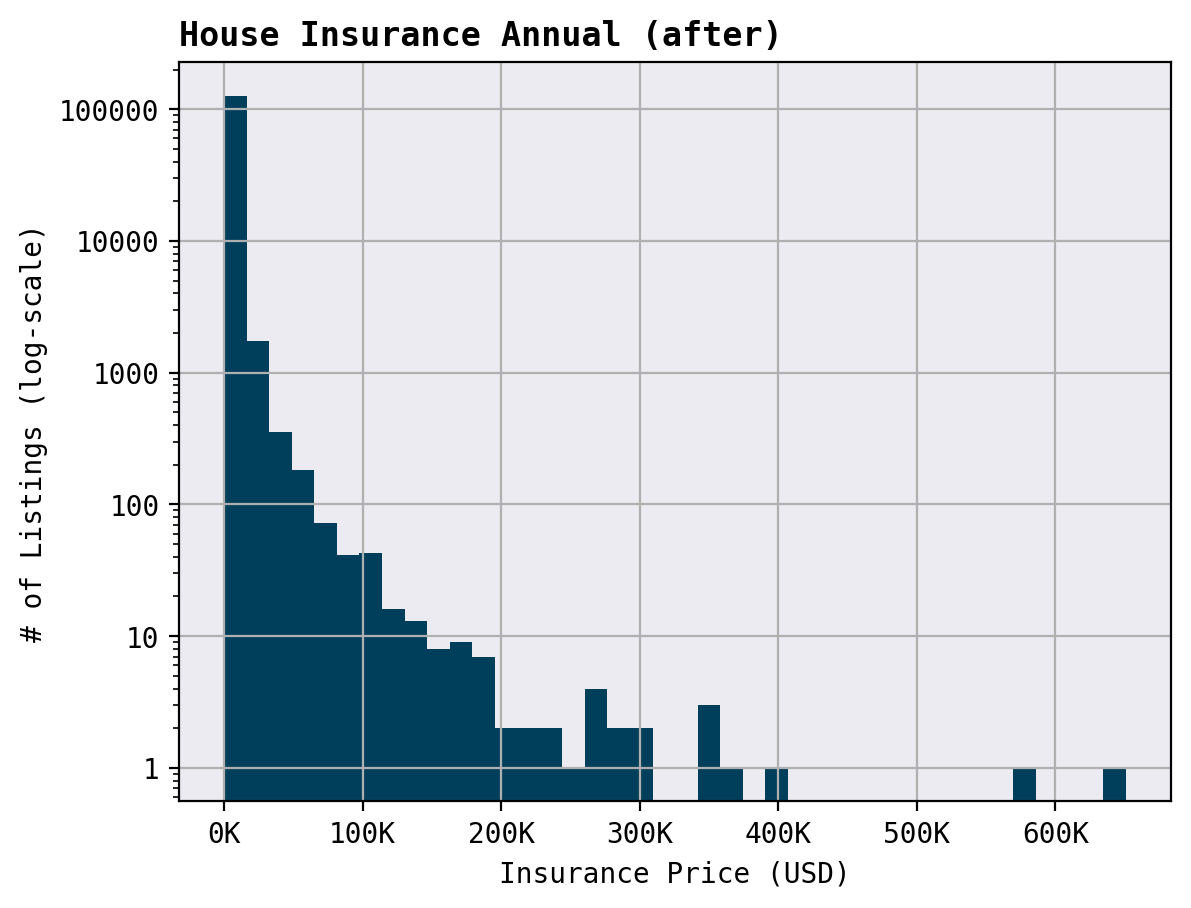

In [229]:
column='annual_house_insurance'
title='House Insurance Annual (after)'
xlabel='Insurance Price (USD)'
ylabel='# of Listings (log-scale)'
log=True
xtickformat='USD Thousands'

histogram(column, title, xlabel, ylabel, log, df, xtickformat=xtickformat)

### price_history

<div class="alert alert-block alert-info"><b>Definition: </b>price_history is a record of the prices for the listing on Zillow.</div>

Do nothing with this yet. We will come back to it later in a future phase of the project.

In [230]:
df[['price_history']].head()

,price_history
2,"[[""2023-10-11"", 2498000], [""1994-06-27"", 308000]]"
3,"[[""2023-03-21"", 5300000], [""2015-11-30"", 21500..."
4,"[[""2023-09-19"", 1499000], [""2013-07-03"", 1900]..."
6,"[[""2023-11-15"", 399000], [""2022-09-19"", 225000..."
9,"[[""2023-10-09"", 1250000], [""2018-04-27"", 59750..."


### description

TODO: Write documentation.

In [231]:
df[['description']].head()

,description
2,Exquisite Equestrian Oasis. The perfect blend ...
3,Saratoga Stables–a magnificent gated 17+ acre ...
4,Lovely Cape Code style home with a Northwest T...
6,Tons of potential in this partially remodeled ...
9,Escape to a serene waterfront cottage with bea...


In [232]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import normalize
import re
import random

def normalize_text(text):
    try:
        # Lowercase
        text = text.lower()
        # Remove punctuation and numbers
        text = re.sub(r'[^a-z\s]', '', text)
        # Tokenize and remove stop words
        tokens = [word for word in text.split() if word not in ENGLISH_STOP_WORDS]
        return ' '.join(tokens)
    except:
        return ' '

def get_ngrams(df, n, sample_size):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(df['description'])
    ngrams = vectorizer.get_feature_names_out()
    
    # Randomly sample n-grams if sample_size is less than the number of n-grams
    if sample_size < len(ngrams):
        sampled_indices = random.sample(range(len(ngrams)), sample_size)
        sampled_ngrams = [ngrams[i] for i in sampled_indices]
        sampled_X = X[:, sampled_indices]
    else:
        sampled_ngrams = ngrams
        sampled_X = X
    
    return sampled_X, sampled_ngrams

def correlate_ngrams_with_price(df, ngrams, X):
    correlations = []
    for i, ngram in tqdm(enumerate(ngrams), total=len(ngrams), desc="Calculating ngram correlations..."):
        freq = X[:, i].toarray().flatten()
        corr = np.corrcoef(freq, df['price'])[0, 1]
        correlations.append((ngram, corr))
    return sorted(correlations, key=lambda x: abs(x[1]))

def find_highest_correlated_ngrams(df, sample_size=100, top_n=10, reverse=True):
    # Normalize descriptions
    
    print('Normalizing text...')
    df['description'] = df['description'].apply(normalize_text)
    
    all_correlations = []
    for n in range(1, 4):  # 1-gram, 2-gram, 3-gram
        print(f'Fetching {n}-grams...')
        X, ngrams = get_ngrams(df, n, sample_size)
        correlations = correlate_ngrams_with_price(df, ngrams, X)
        all_correlations.extend(correlations)
    
    # Sort and return top n correlations
    return sorted(all_correlations, key=lambda x: abs(x[1]), reverse=True)[:top_n]

In [233]:
#top_ngrams = find_highest_correlated_ngrams(listings, sample_size=100000, top_n=500, reverse=True)
top_ngrams = [('robjohns', 0.24368217712409768), ('dolena', 0.24368217712409768), ('perched usable', 0.24368217712409768), ('important examples los', 0.24368217712409768), ('options vast endless', 0.1935434642017464), ('posibillites', 0.19103652855562844), ('community design exclusive', 0.19103652855562844), ('idl', 0.18816922091038235), ('estate', 0.18170230889641048), ('stewarded', 0.17541315094407997), ('lucite', 0.17426445733492693), ('arclinea', 0.17348797903280597), ('promisesas', 0.17348797903280597), ('vigilantly', 0.17348797903280597), ('crystalsstepping', 0.17348797903280597), ('installation movie', 0.17348797903280597), ('la contessina', 0.17348797903280597), ('icecold vodkatasting', 0.17348797903280597), ('marble block kitchen', 0.17348797903280597), ('downtown ocean best', 0.17348797903280597), ('brand arclinea entertainers', 0.17348797903280597), ('bathrooms magnificent guest', 0.17348797903280597), ('macassar', 0.16646557225240538), ('vegetableherb', 0.16248307067002457), ('wine', 0.15267508145477104), ('gillen', 0.1447502995484869), ('bel', 0.1364294463791177), ('elevator', 0.13607496827186846), ('nightclub', 0.1316165679833098), ('gibbons', 0.12921126897927904), ('manalapan', 0.128654094513155), ('cloaked', 0.12418726580436804), ('seats car', 0.122812556091561), ('masterpiece', 0.12249203191362777), ('stance', 0.12232507037779954), ('encantada', 0.12222439052983211), ('beverly', 0.12179067815856814), ('enthusiasts butterfly house', 0.11833539481821945), ('ocean', 0.11769638994193865), ('private', 0.11528781748401702), ('guest', 0.11296683923725254), ('agentbrokerage', 0.11162334906143448), ('cellar', 0.11094835978901645), ('infinity', 0.11094266897848669), ('expansive', 0.1089811109240799), ('grasscarpeted', 0.1089343861452787), ('oceantointracoastal', 0.1089343861452787), ('intracoastalview', 0.1089343861452787), ('designed', 0.1078060021657647), ('chefs', 0.10747879277614236), ('parties grand', 0.10580071658763174), ('sauna garages', 0.10580071658763174), ('rear outdoor lanai', 0.10580071658763174), ('wine cellar dedicated', 0.10580071658763174), ('court tennis house', 0.10580071658763174), ('regencystyle', 0.1058007165876317), ('expert designers', 0.1058007165876317), ('ultraprivate acres', 0.1058007165876317), ('reserve fivebedroom guest', 0.1058007165876317), ('art deco gates', 0.1058007165876317), ('imposing main house', 0.1058007165876317), ('mansions dotting nearby', 0.1058007165876317), ('luxury', 0.104525383722975), ('unparalleled', 0.10325496082570147), ('marble', 0.1008639649343528), ('architect', 0.10076173304214747), ('theater', 0.10045016934957174), ('outside scenery', 0.09981412089317532), ('purdy', 0.09934553637745917), ('staff', 0.09924761748613313), ('luxurious', 0.09871923062716942), ('massage room', 0.09842192650386314), ('custom', 0.09811990686572428), ('magnificent', 0.09747496309643254), ('extraordinary', 0.09571511018526765), ('lawns', 0.09497890177455755), ('populous', 0.09396726801711548), ('glass', 0.09368736116483728), ('helipads', 0.09326603835704424), ('privately owned island', 0.09326603835704424), ('members multiple', 0.09248861275094303), ('east pompano', 0.09248861275094303), ('beach hillsboro', 0.09248861275094303), ('lease affiliations', 0.09248861275094303), ('stream delray beach', 0.09248861275094303), ('listed broker disregard', 0.09248861275094303), ('bar', 0.09223485404849563), ('idx', 0.09193432746748278), ('crestron', 0.091920505805412), ('fireplace', 0.09128506318971205), ('malibus', 0.09127100966364893), ('cooperating', 0.09099888246446047), ('broker title', 0.09086689908364848), ('affiliations', 0.09039846153845885), ('malibu', 0.09037512975608626), ('shores east', 0.0903056718167428), ('pianoblack', 0.09013236879939698), ('cinemagrade', 0.09013236879939698), ('blue plastered', 0.09013236879939698), ('shower zeroedge', 0.09013236879939698), ('management upper', 0.09013236879939698), ('security fireplaces just', 0.09013236879939698), ('oversized marble slabs', 0.09013236879939698), ('gourmet', 0.08992204076430095), ('iconic', 0.08971712655336499), ('stunning', 0.08903355944914307), ('published', 0.08887693183209634), ('infinityedge', 0.0882205068296216), ('company representatives', 0.0870345297637282), ('unvarnished', 0.08699243190263459), ('handhewed', 0.08699243190263459), ('aged white', 0.08699243190263459), ('edge fortunate', 0.08699243190263459), ('unobstructed sunrise sunset', 0.08699243190263459), ('suite includes sheltered', 0.08699243190263459), ('gillens', 0.08637196533022042), ('mielegaggenau', 0.08637196533022042), ('appliances temperature', 0.08637196533022042), ('bespoke terrazzo', 0.08637196533022042), ('topoftheline mielegaggenau appliances', 0.08637196533022042), ('experience perfect relaxation', 0.08637196533022042), ('appliances temperature controlled', 0.08637196533022042), ('panoramic', 0.08632989167725114), ('disclaims', 0.08613201769187533), ('sale listing listing', 0.08613201769187533), ('ranch', 0.08588565222518305), ('santaquins', 0.0851606021529104), ('living', 0.08488979968957941), ('default', 0.08475457278387348), ('participates', 0.08458169996394181), ('indooroutdoor', 0.08456839486385814), ('estateif', 0.08449176359563271), ('locations hillsborough', 0.08449176359563271), ('hillsborough nearly', 0.08449176359563271), ('best best onceinalifetime', 0.08449176359563271), ('accessibility sets', 0.08436178552410756), ('steam', 0.08419885630452882), ('renowned', 0.08380482667158287), ('court', 0.0836990868611695), ('architectural', 0.08335900219314785), ('primary', 0.08283642949612148), ('statistics', 0.08252749713361418), ('main residence', 0.08227982696277113), ('design', 0.08211180350368372), ('subzero', 0.08201765717074973), ('spaces', 0.081286350651768), ('massage', 0.08096865421230823), ('compelled', 0.0807313601264566), ('barbaracaliforniathis', 0.0807313601264566), ('barbaracalifornia', 0.0807313601264566), ('pacific jewel', 0.0807313601264566), ('air west', 0.08073136012645629), ('rarefied', 0.08073136012645628), ('antiquities', 0.08073136012645628), ('parkin', 0.08073136012645628), ('decade result', 0.08073136012645628), ('intimate bathed natural', 0.08073136012645628), ('rooms wsoaring ceilings', 0.08073136012645628), ('generation offering', 0.08073136012645622), ('plans renowned architects', 0.08073136012645622), ('giannetti', 0.080731360126456), ('cottage stables', 0.080731360126456), ('best natural features', 0.080731360126456), ('oceano', 0.08072509278734104), ('sauna', 0.0799953069771723), ('terrace', 0.07988097711201958), ('gold marble', 0.07969839168010241), ('kitchen staff', 0.0796931152028695), ('expressly', 0.07938644118222518), ('saota', 0.07935486480139467), ('teak', 0.07898850996592031), ('dramatic', 0.07895023799899667), ('raton', 0.07889222162463638), ('prestigious', 0.07861089979689995), ('breathtaking', 0.07858251257994829), ('land united', 0.07857082614803933), ('stateoftheart', 0.07851608590488829), ('spacious motor', 0.07851293067963368), ('portuguese', 0.07842121779250445), ('dep city naples', 0.07822442448033906), ('point allowing unequalled', 0.07822442448033906), ('ensuite', 0.07813222522550776), ('kitchen', 0.07761371733873587), ('airs', 0.07738627983461036), ('palm waterway', 0.07684353142547255), ('acres', 0.07674791045062769), ('italian', 0.0766553434164699), ('beach', 0.07535436389405531), ('terraces', 0.0746842832223828), ('pacific', 0.0746667582040522), ('oceanfront', 0.07464865046953698), ('rare', 0.07464007255530862), ('gaggenau', 0.07456271496945276), ('finishes', 0.07431614515855975), ('calculations', 0.0743015992812761), ('headquarters home', 0.07428645546842533), ('gascoigne', 0.0738372870996329), ('bilbao', 0.0738372870996329), ('translucency', 0.0738372870996329), ('remotemonitored', 0.0738372870996329), ('guggenheim', 0.0738372870996329), ('nilesdesigned', 0.0738372870996329), ('properties homes design', 0.0738372870996329), ('luxury stainless faucets', 0.0738372870996329), ('separate structures created', 0.0738372870996329), ('assured home wellgated', 0.0738372870996329), ('appreciated include exposed', 0.0738372870996329), ('motor', 0.07345829775283186), ('bottle', 0.07315731558143929), ('prequalified', 0.07312571152965809), ('zeroedge', 0.07286667964242205), ('main', 0.07282236649339624), ('pompano', 0.07266679479071156), ('stone', 0.07222787479586659), ('glass seamlessly blend', 0.07198020487350282), ('holdouts', 0.07195708536504458), ('attempts', 0.07195708536504458), ('gvrr', 0.07195708536504458), ('controversy', 0.07195708536504458), ('protest', 0.07195708536504458), ('inheld', 0.07195708536504458), ('saloons', 0.07195708536504458), ('unstable geological', 0.07195708536504458), ('william woodward', 0.07195708536504458), ('ickes longer', 0.07195708536504458), ('rockefeller jr', 0.07195708536504458), ('ranch mormon', 0.07195708536504458), ('history national parks', 0.07195708536504458), ('stunning silhouette tetons', 0.07195708536504458), ('event taken associated', 0.07195708536504458), ('valley fell love', 0.07195708536504458), ('topoftheline', 0.07188721844641617), ('lot', -0.07174656487146724), ('transactions', 0.07162240547668405), ('elegant', 0.07140873605588588), ('boca', 0.07118013343996527), ('crestron home', 0.07108059992292162), ('worldclass', 0.07059693181778495), ('cantilever', 0.0704337922661145), ('balcony', 0.07020248241491317), ('omissions', 0.070145339569523), ('feet', 0.07011336169516218), ('wet', 0.06990366663084131), ('wolf', 0.06987961679562481), ('sf', 0.06948296966400098), ('necklace', 0.0689349977910297), ('ultimate', 0.06892370315173209), ('walls', 0.06871503258432579), ('doors', 0.06869675912004082), ('entertaining', 0.0686139603714875), ('staircase', 0.06857381257878278), ('soaring', 0.06835913310629141), ('hammam', 0.06819668189586844), ('house hammam', 0.06819668189586844), ('kitchen wellnessfocused', 0.06819668189586844), ('include catering', 0.06819668189586844), ('africa', 0.06812421453479622), ('contemporary', 0.06766613084600973), ('errors', 0.06752907805357662), ('loggia', 0.0674430815479127), ('utopian', 0.06737302170962611), ('craftsmanship', 0.06732417876789099), ('fireplaces', 0.06726796821288718), ('disregard', 0.06726255017346311), ('impactglass', 0.06714700560597374), ('lavish', 0.06712059318103522), ('lawns trophy', 0.06705837183983471), ('fabric covered acoustic', 0.06705837183983471), ('largest flat', 0.06674802411152894), ('gaviota', 0.06669392370076939), ('butlers', 0.06655703208165002), ('commencement', 0.06636595510389753), ('exceptional', 0.06625983885227525), ('island privately', 0.06608783210061933), ('ceilings automated', 0.06602135677601499), ('formal', 0.06601194637175442), ('blufftop', 0.0660024062820095), ('santa', 0.06582521106010233), ('mosss', 0.0656897462497509), ('away gardens', 0.0656897462497509), ('enduring allure tudor', 0.0656897462497509), ('work art large', 0.0656897462497509), ('elegance', 0.06547123583695368), ('property', 0.06510888537774172), ('floortoceiling', 0.06502783088207097), ('delray', 0.06499024909335863), ('dining', 0.0647304532000911), ('features', 0.06450909653742169), ('highceilings open', 0.06443627842669217), ('decks outdoor heated', 0.06443627842669217), ('bauhaus', 0.06427554156012345), ('landslide', 0.06404596293983898), ('legacy property', 0.06400250937352069), ('limestone', 0.0639605046239746), ('precompletion', 0.06380603431761683), ('significant', 0.06364352938074888), ('handplastered', 0.06360520031108073), ('california coast', 0.06339192572261083), ('ipe', 0.06332132737064051), ('square', 0.06291559612915465), ('opulence', 0.0628394087004661), ('gros', 0.06277655663049751), ('ventre', 0.06277655663049751), ('screening', 0.06270209772963135), ('endless rare', 0.06248602217649354), ('complete', 0.06242997324252365), ('perched', 0.06240014279332696), ('include', 0.062326619405981214), ('malibu lifestyle', 0.06222783158528986), ('erases', 0.062080108346279424), ('fumed', 0.06192934278057455), ('comestible', 0.06192934278057455), ('interior ph', 0.06192934278057455), ('boasts array thoughtfully', 0.06192934278057455), ('city welcoming abundance', 0.06192934278057455), ('crystal chandeliers cream', 0.06192934278057455), ('architects', 0.06188534366394551), ('interiors', 0.06164687881670785), ('crafted', 0.06158738422474039), ('rockclimbing', 0.06142240262155853), ('vast', 0.06137032370221405), ('sophisticated', 0.061322275949587564), ('andalusianstyle', 0.06130260886904516), ('periodcorrect', 0.06115084269294141), ('experience', 0.06086591900679528), ('entertainers', 0.06079859703825502), ('oneofakind', 0.06056266055124789), ('gardens', 0.06041286653047236), ('including', 0.06041200135904139), ('opulent', 0.06031602299005586), ('reminiscent', 0.06014886427035965), ('belair', 0.059943834032787566), ('baths', 0.0598435161465136), ('floor', 0.059594274692722805), ('heated', 0.059586461084839774), ('media', 0.059521023568898775), ('highend', 0.05882794117388083), ('closets', 0.05880793317499706), ('fivediamond', 0.05873439128518836), ('furnished turnkey masterpiece', 0.05855396197885121), ('caretakers', 0.05853946439951205), ('imposing', 0.05844324260756149), ('tennis court tree', 0.0583146508102772), ('private estate conceptual', 0.058168939311398216), ('handcarved', 0.05805186570832083), ('buccaneer palm', 0.05795801960368071), ('detached bdba', 0.05788832239515151), ('reina', 0.05788477704450609), ('calculated', 0.05754283213306301), ('copyright', 0.05750994250064631), ('quarters', 0.05749475393344969), ('coastline', 0.05745245102002082), ('hills', 0.05736660505304276), ('inspired', 0.057235961224903535), ('bottles', 0.057155142608483055), ('ft feature', 0.05708707314926013), ('surfrider', 0.057036980570679144), ('albanese', 0.0568725947175066), ('sofia', 0.05685865507054438), ('cabana', 0.05682434933144179), ('company', 0.05681574540821527), ('level', 0.05672819659961227), ('units', 0.05667317508277517), ('francisco', 0.056624189225233025), ('onceinalifetime', 0.05655824701152487), ('singular', 0.05642029543045907), ('srd', 0.05628561703641948), ('dishwashers', 0.056233711826703586), ('unequalled', 0.05616085029311303), ('tub', 0.05604188518027048), ('modern', 0.05600421673732332), ('represented', 0.055930502344076), ('refrigerated wine', 0.05590383709909059), ('disclaimer', 0.05590228941797219), ('mtii', 0.05566200366528084), ('bacara', 0.05566200366528084), ('pristine pieces', 0.05566200366528084), ('landscapes hope', 0.05566200366528084), ('hope experience', 0.05566200366528084), ('caspernatrona', 0.05566200366528069), ('stalk', 0.05566200366528069), ('ideal launching', 0.05566200366528069), ('afternoon hottest', 0.05566200366528069), ('point visiting', 0.05566200366528069), ('guaranteed broker agents', 0.05566200366528069), ('caspernatrona county international', 0.05566200366528069), ('private leases acres', 0.05566200366528069), ('location middle wyoming', 0.05566200366528069), ('austin creed terminates', 0.05566200366528069), ('camouflage', 0.055662003665280686), ('monocle', 0.055662003665280686), ('harvardwestlake', 0.055662003665280686), ('estate holmby hills', 0.055662003665280686), ('large marble bath', 0.05566200366528065), ('watercut', 0.05566200366528064), ('precision watercut', 0.05566200366528064), ('offers elegant lavish', 0.05566200366528064), ('development bocas', 0.05566200366528039), ('ocean ave nearly', 0.05566200366528039), ('private street ocean', 0.05566200366528039), ('alley gym indoor', 0.0555993302741277), ('netto', 0.05559933027412748), ('hummel', 0.05559933027412748), ('beachcasual', 0.05559933027412748), ('oceantobay', 0.05559933027412748), ('extensive protection', 0.05559933027412748), ('unparalleled enter', 0.05559933027412748), ('located prestigious incomparable', 0.05559933027412748), ('dunes offer extensive', 0.05559933027412748), ('morell', 0.055536656882974544), ('sanctuary', 0.05551600013696651), ('massive', 0.05545690854448424), ('representatives', 0.055262364073916784), ('sophistication', 0.05523815992701855), ('windows', 0.05504613561979954), ('offering', 0.05480528217798691), ('waterfall', 0.054730962388901815), ('lauderdale', 0.05469771569553584), ('incredible', 0.05461248751498245), ('museumquality', 0.05458771109912735), ('discerning', 0.05439592579136262), ('levels', 0.054294755915851055), ('balconies', 0.05423447166386235), ('unmatched', 0.054083267114394706), ('kiteboarding', 0.05398985764925765), ('enclave', 0.0539189410307029), ('curated', 0.05366178370671627), ('barn', 0.05364918654015409), ('ns', 0.05358336033324242), ('bay', 0.05358116161331164), ('california', 0.05352952145381329), ('powder', 0.05342390363375195), ('yacht', 0.05332006476150418), ('cabinetry', 0.05329082730096666), ('glass opening', 0.053213633075147856), ('gates', 0.05317320119691723), ('dockssafe', 0.0531550680191629), ('design connection', 0.0531550680191629), ('bridge west pacific', 0.0531550680191629), ('creates extraordinary sense', 0.0531550680191629), ('appointed technically sophisticated', 0.0531550680191629), ('featuring', 0.053144787255008694), ('swatt', 0.05302972123685755), ('theater guest suite', 0.05302972123685755), ('seamlessly', 0.05288795529528843), ('cooney', 0.052800105773500285), ('guestready', 0.05270413341371395), ('retained', 0.05269502821082977), ('billionaires', 0.05269496682466252), ('waterfront', 0.05265881541764384), ('timeless', 0.05255277821299762), ('equipped', 0.05255036334308828), ('surfer', 0.052528334107633655), ('coast wave', 0.052528334107633655), ('fivebedroom upper', 0.052528334107633655), ('parts enormous', 0.052528334107633655), ('decks echo', 0.052528334107633655), ('echo shape', 0.052528334107633655), ('plus wide semicircular', 0.052528334107633655), ('gesner offered sale', 0.052528334107633655), ('woodplank ceilings rest', 0.052528334107633655), ('just breathtaking', 0.05247914331381846), ('total', 0.0524789662319909), ('places world', 0.05247372007035703), ('belgian', 0.052458601549650125), ('barns', 0.05241911407107144), ('ranch headquarters', 0.052174928245516256), ('terzani', 0.05212801393381387), ('sarkela', 0.05212801393381387), ('dornbracht bath', 0.05212801393381387), ('sarkela corporation', 0.05212801393381387), ('sixbedroom', 0.05193377961356239), ('mizner', 0.05192852210005766), ('residences', 0.05189455235771679), ('high', 0.05186582558855815), ('viewings available', 0.051750388561950994), ('citytoocean', 0.05159177964867667), ('intrepid', 0.05150314588253815), ('clad', 0.05143032549119434), ('documentary', 0.05131695616065142), ('waterfrontage', 0.051237477620581603), ('natural', 0.051235679634463925), ('security', 0.05122331034687869), ('seating', 0.05103551101273895), ('unobstructed', 0.050940671095848065), ('enthusiasts equipped topoftheline', 0.05088883162272331), ('thoughtfully considered', 0.0508548023940854), ('faring', 0.050854375391144624), ('ranch simply', 0.050842824324806676), ('decadent', 0.050806136608538804), ('gated compound', 0.050655732585467496), ('beery', 0.05064339835099522), ('current form', 0.05064339835099504), ('unique', 0.05053150170539727), ('unstable', 0.050506016013480606), ('uptick', 0.050399655494114376), ('silicon', 0.05037291674137043), ('lease periods', 0.05035514007140971), ('grand teton national', 0.05035251838797155), ('marfil', 0.050348085306566266)]

In [234]:
print(top_ngrams[:20])

[('robjohns', 0.24368217712409768), ('dolena', 0.24368217712409768), ('perched usable', 0.24368217712409768), ('important examples los', 0.24368217712409768), ('options vast endless', 0.1935434642017464), ('posibillites', 0.19103652855562844), ('community design exclusive', 0.19103652855562844), ('idl', 0.18816922091038235), ('estate', 0.18170230889641048), ('stewarded', 0.17541315094407997), ('lucite', 0.17426445733492693), ('arclinea', 0.17348797903280597), ('promisesas', 0.17348797903280597), ('vigilantly', 0.17348797903280597), ('crystalsstepping', 0.17348797903280597), ('installation movie', 0.17348797903280597), ('la contessina', 0.17348797903280597), ('icecold vodkatasting', 0.17348797903280597), ('marble block kitchen', 0.17348797903280597), ('downtown ocean best', 0.17348797903280597)]


In [235]:
selected_ngrams = [
    'dolean','options vast endless','possibilities','community design exclusive',
    'estate','stewarded','lucite','arclinea','marble block kitchen','downtown ocean best',
    'brand arclinea entertainers','bathrooms magnificient guest','macassar','wine',
    'masterpiece','private','cellar','infinity','expansive','intracoastalview','designed',
    'chefs','parties grand','court tennis house','regencystyle','art deco gates','imposing main house',
    'mansions dotting nearby','luxury','unparalleled','marble','architect','theater','outside scenery',
    'staff','massage room','custom','magnificent','extraordinary','privately owned island','gourmet',
    'iconic','stunning','infinityedge','panoramic','unobstructued sunrise sunset','aged white',
    'experience perfect relaxation','indooroutdoor','court','architectural','subzero','rarefied',
    'antiquities','sauna','terrace','saota','italian'
]

In [236]:
def add_ngram_columns(df, selected_ngrams):
    df['description'] = df['description'].apply(normalize_text)
    for ngram in tqdm(selected_ngrams, desc="creating ngram features in listing dataset..."):
        ngram_column_name = 'ngram_' + ngram
        df[ngram_column_name] = df['description'].apply(lambda x: int(ngram in x))
    return df

df = add_ngram_columns(df, selected_ngrams)

creating ngram features in listing dataset...: 100%|██████████| 58/58 [00:07<00:00,  8.24it/s]


### hasPrivatePool

<div class="alert alert-block alert-info"><b>Definition: </b>hasPrivatePull says whether or not the listing has its own pool.</div>

This seems to be a legacy column. Drop it.

In [237]:
# Quick groupby.
groupit('hasPrivatePool',df=df)

Series([], dtype: int64)


In [238]:
# Null check.
nullcheck('hasPrivatePool',df=df)

hasPrivatePool
Nulls: 128960


In [239]:
# Drop column.
df.drop(columns=['hasPrivatePool'],inplace=True)

### attic

<div class="alert alert-block alert-info"><b>Definition: </b>attic says whether or not the home has an attic.</div>

Another legacy column. Drop it.

In [240]:
# Quick group by.
groupit('attic')

Series([], dtype: int64)


In [241]:
# Check nulls
nullcheck('attic')

attic
Nulls: 264498


In [242]:
# Drop column.
df.drop(columns=['attic'],inplace=True)

### similarHomes

<div class="alert alert-block alert-info"><b>Definition: </b>similarHomes is a list of zillowIds that the current home is similar to.</div>


Do nothing with this yet.

In [243]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128960 entries, 2 to 265306
Columns: 116 entries, zillowId to ngram_italian
dtypes: bool(4), float64(31), int64(58), object(23)
memory usage: 111.7+ MB


In [244]:
df.head()

,zillowId,homeStatus,streetAdress,city,state,zipcode,price,bedrooms,bathrooms,yearBuilt,zestimate,homeType,livingArea,hasGarage,parkingCapacity,sewer,hasHeating,fireplaces,hasWaterfrontView,isSeniorCommunity,levels,lotSize,hoaFee,buyersFeePerc,daysOnZillow,views,favorites,latitude,longitude,mainPhoto,brokerage,percSellFaster,propertyTax,mortgageRate,listingUserId,agentName,agentRating,agentRecentSales,agentReviewsCount,photosList,isForeclosure,isBankOwned,rentZestimate,totalActualRent,annual_house_insurance,price_history,description,similarHomes,termsCash,termsConventional,termsFHA,termsVA,schoolAverageDistance,schoolContainsCharter,schoolRatingElementary,schoolRatingMiddleSchool,schoolRatingHighSchool,hasPatioPorch,ngram_dolean,ngram_options vast endless,ngram_possibilities,ngram_community design exclusive,ngram_estate,ngram_stewarded,ngram_lucite,ngram_arclinea,ngram_marble block kitchen,ngram_downtown ocean best,ngram_brand arclinea entertainers,ngram_bathrooms magnificient guest,ngram_macassar,ngram_wine,ngram_masterpiece,ngram_private,ngram_cellar,ngram_infinity,ngram_expansive,ngram_intracoastalview,ngram_designed,ngram_chefs,ngram_parties grand,ngram_court tennis house,ngram_regencystyle,ngram_art deco gates,ngram_imposing main house,ngram_mansions dotting nearby,ngram_luxury,ngram_unparalleled,ngram_marble,ngram_architect,ngram_theater,ngram_outside scenery,ngram_staff,ngram_massage room,ngram_custom,ngram_magnificent,ngram_extraordinary,ngram_privately owned island,ngram_gourmet,ngram_iconic,ngram_stunning,ngram_infinityedge,ngram_panoramic,ngram_unobstructued sunrise sunset,ngram_aged white,ngram_experience perfect relaxation,ngram_indooroutdoor,ngram_court,ngram_architectural,ngram_subzero,ngram_rarefied,ngram_antiquities,ngram_sauna,ngram_terrace,ngram_saota,ngram_italian
2,23352313.0,FOR_SALE,7001 Palm Lane,Anacortes,WA,98221,2498000.0,4.0,3.0,2000.0,NaN,SingleFamily,3788.0,True,4.0,sewer,True,2.0,False,False,1.0,10.300000,0.0,2.5,125.0,1219.0,40.0,48.441994,-122.591225,https://photos.zillowstatic.com/fp/8a6b6abe798...,COMPASS,0.25,0.83,6.606,X1-ZUyt9ezy9pvtop_61q4w,Eileen Hebert,5.0,1.0,259.0,"[""https://photos.zillowstatic.com/fp/8a6b6abe7...",False,False,NaN,0.0,10491.6,"[[""2023-10-11"", 2498000], [""1994-06-27"", 308000]]",exquisite equestrian oasis perfect blend luxur...,"[84763318, 23352179, 23377656, 23387845, 20536...",False,True,False,False,3.200000,False,9.0,5.0,9.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,23380009.0,FOR_SALE,14820 Gibralter Road,Anacortes,WA,98221,5300000.0,5.0,6.0,2001.0,NaN,SingleFamily,5577.0,True,4.0,sewer,True,4.0,False,False,1.0,17.010000,0.0,2.5,276.0,2146.0,127.0,48.429980,-122.587870,https://photos.zillowstatic.com/fp/3a101f623ea...,"Windermere R.E. Northeast, Inc",0.22,0.83,6.606,X1-ZUz3sd58bhvnd5_3qul1,bryanloveless5250,5.0,0.0,9.0,"[""https://photos.zillowstatic.com/fp/3a101f623...",False,False,NaN,0.0,22260.0,"[[""2023-03-21"", 5300000], [""2015-11-30"", 21500...",saratoga stablesa magnificent gated acre eques...,"[2055432779, 2053658449, 228491857, 82573373, ...",False,True,False,False,4.033333,False,9.0,5.0,9.0,False,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,23352179.0,FOR_SALE,7270 Old Brook Lane,Anacortes,WA,98221,1499000.0,5.0,4.0,1983.0,1391500.0,SingleFamily,2968.0,True,2.0,sewer,True,2.0,False,False,2.0,9.010000,0.0,2.5,94.0,936.0,29.0,48.460000,-122.587746,https://photos.zillowstatic.com/fp/99488e836da...,Windermere RE Anacortes Prop.,0.30,0.83,6.606,X1-ZUz4p08auiqhhl_3wgux,Colleen Craig,5.0,0.0,9.0,"[""https://photos.zillowstatic.com/fp/99488e836...",False,False,5818.0,0.0,6295.8,"[[""2023-09-19"", 1499000], [""2013-07-03"", 1900]...",lovely cape code style home northwest twist po...,"[23358076, 23377656, 23358089, 23387845, 25075...",False,True,False,False,2.633333,False,9.0,5.0,9.0,False,0,0,0,0,0,0,0,0,0

### Save data.

That's it for this step -- not too exciting, but the data is in much better shape for early analysis. I'll save the data for the next step.

In [245]:
df.to_csv('cleaned_zillow_data.csv')